# Reinforcement Learning: BlackJack 

In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math as m
from tabulate import tabulate
import numpy as np
import warnings
warnings.filterwarnings('ignore')

###  State Action Pair class

This class stores all possible combinations of states and actions in dictionary format. 

A state is a combination of:
Total of the Players Cards,
The Dealers Up Card,
If the player has an ace being used as a 11

An action action, on the other hand, is one of two actions: hit of stand.

Therefore a state action pair is all the above combined.

The keys of the dictionary follow the following pattern:
PlayerTotal-DealerTotal-AceAs11-Action
(Total of Player Cards)-(Dealer Card)-(0:No, 1:Yes)-(0:Stand, 1:Hit)

Each key has an array associated with it. The first val of the array stores the amount of times the state action pain has been visited. The second value is the current reward of a action. It is used to decide if the algorithm should hit or stand.



In [2]:
# Key Encoding:
# PlayerTotal-DealerTotal-AceAs11-Action
# (Total of Player Cards)-(Dealer Card)-(0:No, 1:Yes)-(0:Stand, 1:Hit)

# Dict Value:
# [Counts, Probability]
class stateActionVal:
    def __init__(self):
        self.counts = {}
        for total in range(12, 21):
            for dealerCard in range(2, 12):
                key = str(total) + "-" + str(dealerCard) + '-0-0'
                self.counts[key] = [0, 0]
                key = str(total) + "-" + str(dealerCard) + '-0-1'
                self.counts[key] = [0, 0]
                key = str(total) + "-" + str(dealerCard) + '-1-0'
                self.counts[key] = [0,0]
                key = str(total) + "-" + str(dealerCard) + '-1-1'
                self.counts[key] = [0, 0]

    def incCount(self, key):
        self.counts[key][0] += 1

    def updProb(self, key, outcome):
        self.counts[key][1] += outcome 
    
    def printDict(self):
        for key, val in self.counts.items():
            print("Key: ", key ,", Iterations: ",  val[0], ", Prob: ", val[1])

### Card Class

To be able to build a deck, a card class was created. The class has 2 attributes representing the suit and rank of a card

In [3]:
class card:
    def __init__(self, suit, rank):
        self.suit = suit # ♧, ♢, ♥, ♤
        self.rank = rank # 2, 3, 4, 5, 6, 7, 8, 9, 10, J, Q, K, A

### Deck Class

A deck is a set of 52 cards ranging over all combinations of suits and ranks. The class has functionality to:
- Print the deck
- Shuffle the deck
- Get the card from the top of the deck

In [4]:
class deck:
    def __init__(self):
        self.cards = []
        self.setDeck()
        
    def setDeck(self):
        self.cards = []
        suits = ["♧", "♢", "♥", "♤"]
        ranks = [2, 3, 4, 5, 6, 7, 8, 9, 10, "J", "Q", "K", "A"]

        for suit in suits:
            for rank in ranks:
                self.cards.append(card(suit, rank))  # init deck
    
    def printDeck(self):
        for card in self.cards:
            print(card.rank, card.suit)
    
    def shuffle(self):
        random.shuffle(self.cards) # change card order

    def getRandomCard(self):
        temp = self.cards[0]
        del self.cards[0] # delete a card form the deck
        return temp

### Player Class

The player class creates an instance that will be receiving cards throughout a blackjack round. This can be a user, Ai, or dealer. The class has 3 attributes:
- A list of cards currently held by the player
- The total value of the cards
- A boolean value indicating if the user has an ace or not being used as an 11

Functions:
- addCard: adds a card to the players hand
- hit: picks the card to be added to the players hand
- clear: resets the players hand

In [5]:
class player:
    def __init__(self):
        self.cards = [] # cards currently in hand
        self.total = 0 # card total
        self.hasAce = False # True if an ace is being used as a 11
    
    def addCard(self, card):
        self.cards.append(card)
        if(card.rank == "J" or card.rank == "Q" or card.rank == "K"):
            self.total += 10
        elif(card.rank == "A" and self.hasAce == False):
            self.total += 11
            self.hasAce = True
        else:
            if card.rank == 'A' and self.hasAce: # you can not have 2 aces as 11, as that would make a total of 22
                self.total += 1 # use the ace as a one
            else:
                self.total += int(card.rank)
        
        if self.total > 21 and self.hasAce == True:
            self.hasAce = False
            self.total -= 10 # 11 - 10 = 1
    
    def hit(self, myDeck):
        self.addCard(myDeck.getRandomCard())
    
    
    def clear(self):
        self.cards = []
        self.total = 0
        self.hasAce = False

### BlackJack class

The blackjack class stores everything needed to play a round of blackjack. Its attributes are: the player, the dealer and the deck of cards being used. 

The class makes use of 5 functions to play a round:
- newRound: sets up the environment for a new round to be played
- hitDealer: gives cards to the dealer
- hiPlayer: gives cards to the player
- outcome: prints the outcome of the round
- playRound: combines all of the above functions to play a round


In [6]:
class blackJackRound:
    def __init__(self, deck, player, dealer):
        self.player = player
        self.dealer = dealer
        self.deck = deck
        self.newRound()
        
    
    def newRound(self):
        self.player.clear() # init found
        self.dealer.clear()
        self.deck.setDeck()
        self.deck.shuffle()
        self.hitPlayerBool = True

        self.player.hit(self.deck) # give player 2 cards
        self.player.hit(self.deck)
        self.dealer.hit(self.deck) # give dealer 1 card
    
    def hitDealer(self):
        if(self.player.total <= 21): # dealer will only hit if player is not bust
            while(self.dealer.total < 17): # dealer will always hit till his total is greather than 17
                self.dealer.hit(self.deck)
    
    def hitPlayer(self):
        while(self.hitPlayerBool):
            if(self.player.total == 21):
                self.hitPlayerBool = False
            elif(self.player.total < 12):
                #Ai go hererererere
                self.player.hit(self.deck)
            else:
                self.hitPlayerBool = False
    
    def outcome(self): # print outcome
        print("Player: ", self.player.total)
        print("Dealer: ", self.dealer.total)

        if(self.player.total <= 21 and (self.player.total > self.dealer.total or self.dealer.total > 21)): # player wins
            print("Player wins")
        elif(self.player.total == self.dealer.total): # player and dealer same total
            print("Draw")
        else:
            print("Dealer wins")
    
    def playRound(self): # play full round
        self.newRound()
        self.hitPlayer()
        self.hitDealer()
        self.outcome()

## AI Algorithm Implementation

### Epsilon values 

In [7]:
def E1(k):
    return 0.1
def E2(k):
    return 1/k
def E3(k):
    return m.e ** (-k/1000)
def E4(k):
    return m.e ** (-k/10000)

### Epsilon Greedy Policy 

In [8]:
def epsilonGreedy(state, epsilonVal, stateAcVal): #state will be and array [PlayerTotal, DealerCard, hasAce]
        s1 = str(state[0])+"-"+str(state[1])+"-"+str(int(state[2]))+"-0"
        s2 = str(state[0])+"-"+str(state[1])+"-"+str(int(state[2]))+"-1"
        a1 = stateAcVal.counts[s1]
        a2 = stateAcVal.counts[s2]

        if a1[1] < a2[1]:
            worseOption = s1
            bestOption = s2
        else:
            worseOption = s2
            bestOption = s1

        if random.uniform(0, 1) < epsilonVal:
            return worseOption
        else:
            return bestOption

### Greedy Policy

In [9]:
def argmax(state, stateAcVal):
    s1 = str(state[0])+"-"+str(state[1])+"-"+str(int(state[2]))+"-0"
    s2 = str(state[0])+"-"+str(state[1])+"-"+str(int(state[2]))+"-1"
    a1 = stateAcVal.counts[s1]
    a2 = stateAcVal.counts[s2]

    if a1[1] < a2[1]:
        return s2
    else:
        return s1

### SARSA Algorithm 

In [10]:
class SARSA:
    def __init__(self):
        self.stateActionVal = stateActionVal()
        self.counts = []
    
    def training(self, numOfEps, eFunc):
        discountFactor = 1
        dealer = player()
        p = player()
        d = deck()
        b = blackJackRound(d, p, dealer)

        countWins = [0]
        countLose = [0]
        countDraw = [0]
        count1000 = 0
    
        for k in range(1, numOfEps):
            if k % 1000 == 0:
                countWins.append(0)
                countLose.append(0)
                countDraw.append(0)
                count1000 += 1

            b.newRound()
            e = eFunc(k)
            while b.player.total < 12:
                b.player.hit(b.deck)
            
            if b.player.total != 21:
                sa = epsilonGreedy([b.player.total, b.dealer.total, b.player.hasAce], e, self.stateActionVal)
                learningFactor = 1/(self.stateActionVal.counts[sa][0] + 1)

            while b.player.total < 21:
                # Execute action an state s
                if sa[-1] == 1:
                    b.player.hit(b.deck)
                else:
                    self.stateActionVal.counts[sa][0] += 1
                    break
                
                # Get reward n form s`
                if b.player.total < 22:
                    n = 0
                    # Get next action a`
                    a = epsilonGreedy([b.player.total, b.dealer.total, b.player.hasAce], e, self.stateActionVal)

                     # Get Q(s`, a`) from table
                    saPrime = self.stateActionVal[a][1] 
                
                    # update
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + learningFactor*(n + discountFactor*saPrime - self.stateActionVal.counts[sa][1])
                else:
                    self.stateActionVal.counts[sa][1] -= 1

                #setting new sa
                sa = saPrime
            
            b.hitDealer()
            #b.outcome()
            if(b.player.total <= 21 and (b.player.total > b.dealer.total or b.dealer.total > 21)):
                self.stateActionVal.counts[sa][1] += 1
                countWins[count1000] += 1
            elif(b.player.total == b.dealer.total):
                self.stateActionVal.counts[sa][1] += 0
                countDraw[count1000] += 1
            elif(b.player.total <= 21):
                self.stateActionVal.counts[sa][1] -= 1
                countLose[count1000] += 1

        self.counts = [countWins, countDraw, countLose]

    def printCounts(self):
        for x in range(len(self.counts[0])):
            print("Set:", x, ", Wins: ", self.counts[0][x], ", Draw: ", self.counts[1][x], ", Lose: ", self.counts[2][x])


### Monte Carlo - on policy control 

In [49]:
class monteCarloControl:
    def __init__(self):
        self.stateActionVal = stateActionVal()
        self.counts = []

    # This is method is used specifically for the exploring start
    def explStart(self, numLoop, eFunc):
        discountFactor = 1
        dl = player()
        pl = player()
        d = deck()
        b = blackJackRound(d, pl, dl)
        setCounter = 1
        countWins = [0]
        countLose = [0]
        countDraw = [0]
        count1000 = 0

        for k in range(1, numLoop):
            if k % 1000 == 0:
                countWins.append(0)
                countLose.append(0)
                countDraw.append(0)
                count1000 += 1

            b.newRound()
            G = 0
            visitedSA = []
            cumulativeReward = []
            e = eFunc(k) # Calculating the new epsilon value
            roundEnd = False # Used to indicate when a final state has been reached (stand or total 21+)

            sampleEpisode = random.choice(list(self.stateActionVal.counts.keys())) # Sampling a random state for the episode
            split = sampleEpisode.split('-') # Decoding the dictionary key and splitting it
            b.player.total = int(split[0]) # Setting the player's total to the random total
            b.player.hasAce = bool(split[2]) # Seeing if the player has an ace or not
            b.dealer.total = int(split[1])
            firstAction = bool(split[3]) # Randomly selecting if the player hits or stands
            
            tempKey = sampleEpisode # tempKey stores the current state in terms of the dictionary key format
            visitedSA.append(tempKey) # Adding the state saved as a tempKey in the visited state action pairs

            if firstAction == 1: # Player hits
                b.player.hit(b.deck) # Taking the hit action
                if b.player.total >= 21: # Checking if a final state has been reached
                    roundEnd = True
            else: # Player stands
                roundEnd = True
            
            while not roundEnd:
                sa = epsilonGreedy([b.player.total, b.dealer.total,b.player.hasAce], e, self.stateActionVal) # Using the e-greedy policy to see take the next action
                visitedSA.append(sa)
                if sa[-1] == 1: # Hits   
                    b.player.hit(b.deck)
                    if b.player.total > 21:
                        roundEnd = True
                else: # Stands
                    roundEnd = True

            b.hitDealer()
            if(b.player.total <= 21 and (b.player.total > b.dealer.total or b.dealer.total > 21)):
                countWins[count1000] += 1
                rewards = 1
                G = discountFactor * G + rewards 
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])
            elif(b.player.total == b.dealer.total):
                countDraw[count1000] += 1
                rewards = 0
                G = discountFactor * G + rewards
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])
            elif(b.player.total <= 21):
                countLose[count1000] += 1
                rewards = -1
                G = discountFactor * G + rewards
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])
        self.counts = [countWins, countDraw, countLose]

    # This is method is used specifically for the no exploring start
    def noExplStart(self, numLoop, eFunc):
        discountFactor = 1
        dl = player()
        pl = player()
        d = deck()
        b = blackJackRound(d, pl, dl)
        setCounter = 1
        countWins = [0]
        countLose = [0]
        countDraw = [0]
        count1000 = 0

        for k in range(1, numLoop):
            if k % 1000 == 0:
                countWins.append(0)
                countLose.append(0)
                countDraw.append(0)
                count1000 += 1

            b.newRound()
            G = 0
            visitedSA = []
            cumulativeReward = []
            e = eFunc(k) # Calculating the new epsilon value
            roundEnd = False # Used to indicate when a final state has been reached (stand or total 21+)

            sampleEpisode = random.choice(list(self.stateActionVal.counts.keys())) # Sampling a random state for the episode
            split = sampleEpisode.split('-') # Decoding the dictionary key and splitting it
            b.player.total = int(split[0]) # Setting the player's total to the random total
            b.player.hasAce = bool(split[2]) # Seeing if the player has an ace or not
            b.dealer.total = int(split[1])
            
            tempKey = sampleEpisode # tempKey stores the current state in terms of the dictionary key format
            visitedSA.append(tempKey) # Adding the state saved as a tempKey in the visited state action pairs
            
            while not roundEnd:
                sa = epsilonGreedy([b.player.total, b.dealer.total,b.player.hasAce], e, self.stateActionVal) # Using the e-greedy policy to see take the next action
                visitedSA.append(sa)
                if sa[-1] == 1: # Hits   
                    b.player.hit(b.deck)

                    if b.player.total > 21:
                        roundEnd = True
                else: # Stands
                    roundEnd = True

            b.hitDealer()
            if(b.player.total <= 21 and (b.player.total > b.dealer.total or b.dealer.total > 21)):
                countWins[count1000] += 1
                rewards = 1
                G = discountFactor * G + rewards 
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])
            elif(b.player.total == b.dealer.total):
                countDraw[count1000] += 1
                rewards = 0
                G = discountFactor * G + rewards
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])
            elif(b.player.total <= 21):
                countLose[count1000] += 1
                rewards = -1
                G = discountFactor * G + rewards
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])
        self.counts = [countWins, countDraw, countLose]


### SARSAMAX Algorithm

In [12]:
class SARSAMAX():
    def __init__(self):
        self.stateActionVal = stateActionVal()
        self.counts = []
    
    def training(self, numOfEps, eFunc):
        discountFactor = 1
        dealer = player()
        p = player()
        d = deck()
        b = blackJackRound(d, p, dealer)

        countWins = [0]
        countLose = [0]
        countDraw = [0]
        count1000 = 0
    
        for k in range(1, numOfEps):
            if k % 1000 == 0:
                countWins.append(0)
                countLose.append(0)
                countDraw.append(0)
                count1000 += 1

            b.newRound()
            e = eFunc(k)

            #if under 12, hit (no desicion to be made, can't go bust with any card from under 12)
            while b.player.total < 12:
                b.player.hit(b.deck)
            
            while b.player.total < 21:
                # Choose a from s
                sa = epsilonGreedy([b.player.total, b.dealer.total, b.player.hasAce], e, self.stateActionVal)
                learningFactor = 1/(self.stateActionVal.counts[sa][0] + 1)

                # Execute action an state s
                if sa[-1] == 1:
                    b.player.hit()
                else:
                    self.stateActionVal.counts[sa][0] += 1
                    break
                
                # Get reward n form s`
                if b.player.total < 22:
                    #n = 10 - (21 - b.player.total)
                    n=0
                    
                    # Get next action a`
                    a = epsilonGreedy([b.player.total, b.dealer.total, b.player.hasAce], e, self.stateActionVal)

                    # Get Q(s`, a`) from table
                    # saPrime = self.stateActionVal[a][1] # 0 #just get largest Q
                    saPrime = argmax([b.player.total, b.dealer.total, b.player.hasAce], self.stateActionVal)
                
                    # update
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + learningFactor*(n + discountFactor*saPrime - self.stateActionVal.counts[sa][1])
                else:
                    self.stateActionVal.counts[sa][1] -= 1
               

            
            b.hitDealer()
            #b.outcome()
            if(b.player.total <= 21 and (b.player.total > b.dealer.total or b.dealer.total > 21)):
                self.stateActionVal.counts[sa][1] += 1
                countWins[count1000] += 1
            elif(b.player.total == b.dealer.total):
                self.stateActionVal.counts[sa][1] += 0
                countDraw[count1000] += 1
            elif(b.player.total <= 21):
                self.stateActionVal.counts[sa][1] -= 1
                countLose[count1000] += 1

        self.counts = [countWins, countDraw, countLose]

    def printCounts(self):
        for x in range(len(self.counts[0])):
            print("Set:", x, ", Wins: ", self.counts[0][x], ", Draw: ", self.counts[1][x], ", Lose: ", self.counts[2][x])

    def findPerc(self, numEps):
        wins = 0
        for x in range(len(self.counts[0])):
            wins = wins + self.counts[0][x]

        print("Win %: ", (wins/numEps)*100)

### Functions used for creating Outputs

Plot a graph of wins, losses and draws

In [13]:
def plotOutcomes(numOfEps, alg):
    episodes = []
    for x in range(int(numOfEps/1000) + 1):
        episodes.append(x*1000)

    wins = [0]
    draws = [0]
    losses = [0]
    for x in alg.counts[0]:
        wins.append(x)
    for x in alg.counts[1]:
        draws.append(x)
    for x in alg.counts[2]:
        losses.append(x)

    plt.plot(episodes, wins) # wins
    plt.plot(episodes, draws) # draws
    plt.plot(episodes, losses) # losses
    plt.title('Episodes vs winRate')
    plt.xlabel('Episodes')
    plt.ylabel('Rates')
    plt.show()

Plot a bar chart of the number of times each state action pair has been visited

In [14]:
def plotQACounts(sarse):
    vals = list(sarse.stateActionVal.counts.values())
    values = []
    
    for x in vals:
        values.append(x[0])
    
    data = {"keys":list(sarse.stateActionVal.counts.keys()), "vals":values}

    df = pd.DataFrame(data)  
    df_sorted= df.sort_values('vals', ascending=False)

    for x in range(0, 360, 60):
        fig = plt.figure(figsize=(40, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_ylim(0, 16000)
        ax.set_xticklabels(df_sorted[x:x+60]["keys"],rotation=45)
        ax.bar("keys", "vals", data=df_sorted[x:x+60], color ='maroon', width = 0.4, align='center')

Take in 4 algorithms and create a bar chart of the amount of unique state action pairs where visited 

In [65]:
def plotHist(algs, algsTitles):
    counts = []
    for a in algs:
        vals = list(a.stateActionVal.counts.values())
        count = 0
        for x in vals:
            if x != 0:
                count += 1
        counts.append(count)
    
    data = {"keys":algsTitles, "vals":counts}

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar("keys", "vals", data=data, color ='maroon', width = 0.7, align='center')

Print out a strategy table indicating when you should stand or hit

In [16]:
def printStratTable(alg, hasAces):
    table = [[12],[13],[14],[15],[16],[17],[18],[19],[20]]

    for playerTotal in range(12, 21):
        for dealerTotal in range(2, 12):
            a1 = alg.stateActionVal.counts[str(playerTotal)+"-"+str(dealerTotal)+"-"+str(int(hasAces))+"-0"]
            a2 = alg.stateActionVal.counts[str(playerTotal)+"-"+str(dealerTotal)+"-"+str(int(hasAces))+"-1"]

            if(a1[1] < a2[1]):
                table[playerTotal-12].append('H')
            else:
                table[playerTotal-12].append('S')
                
    print(tabulate(table, headers=[' ', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']))



Work out the win chance of the player

In [17]:
def getDealerAdvantage(alg):
    counts = alg.counts[:-100]

    meanWins = sum(alg.counts[0][400:])/100
    meanDraws = sum(alg.counts[1][400:])/100
    meanLosses = sum(alg.counts[2][400:])/100

    dealerAdv = (meanLosses - meanWins)/(meanLosses + meanWins)
    return dealerAdv

## Executing the Algorithms

### MonteCarlo Algorithm: Exploring Starts
#### Training the algorithm
The exploring starts monteCarlo algorithm was trained with an epsilon value of 1/k

In [50]:
numOfEps = 500000
mc = monteCarloControl()
mc.explStart(numOfEps, E2)

#### Wins - Draws - Losses

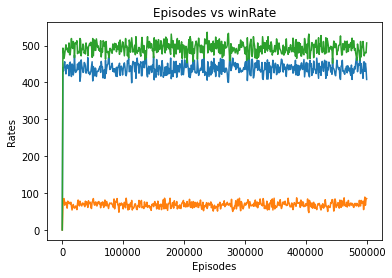

In [51]:
plotOutcomes(numOfEps, mc)

#### Explored states for MonteCarlo Exploring Starts algorithms


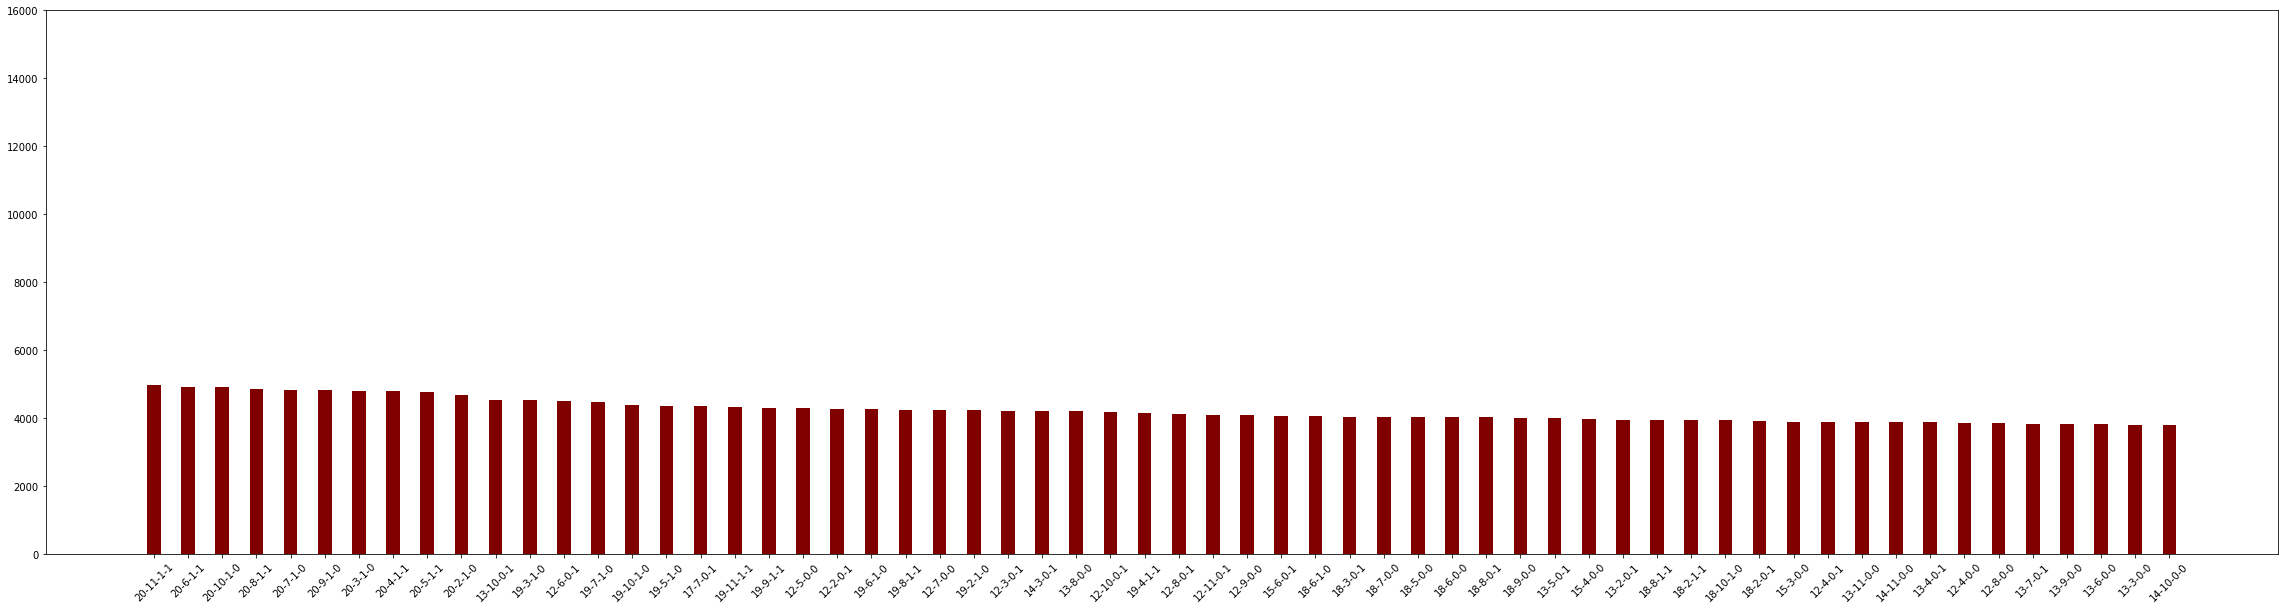

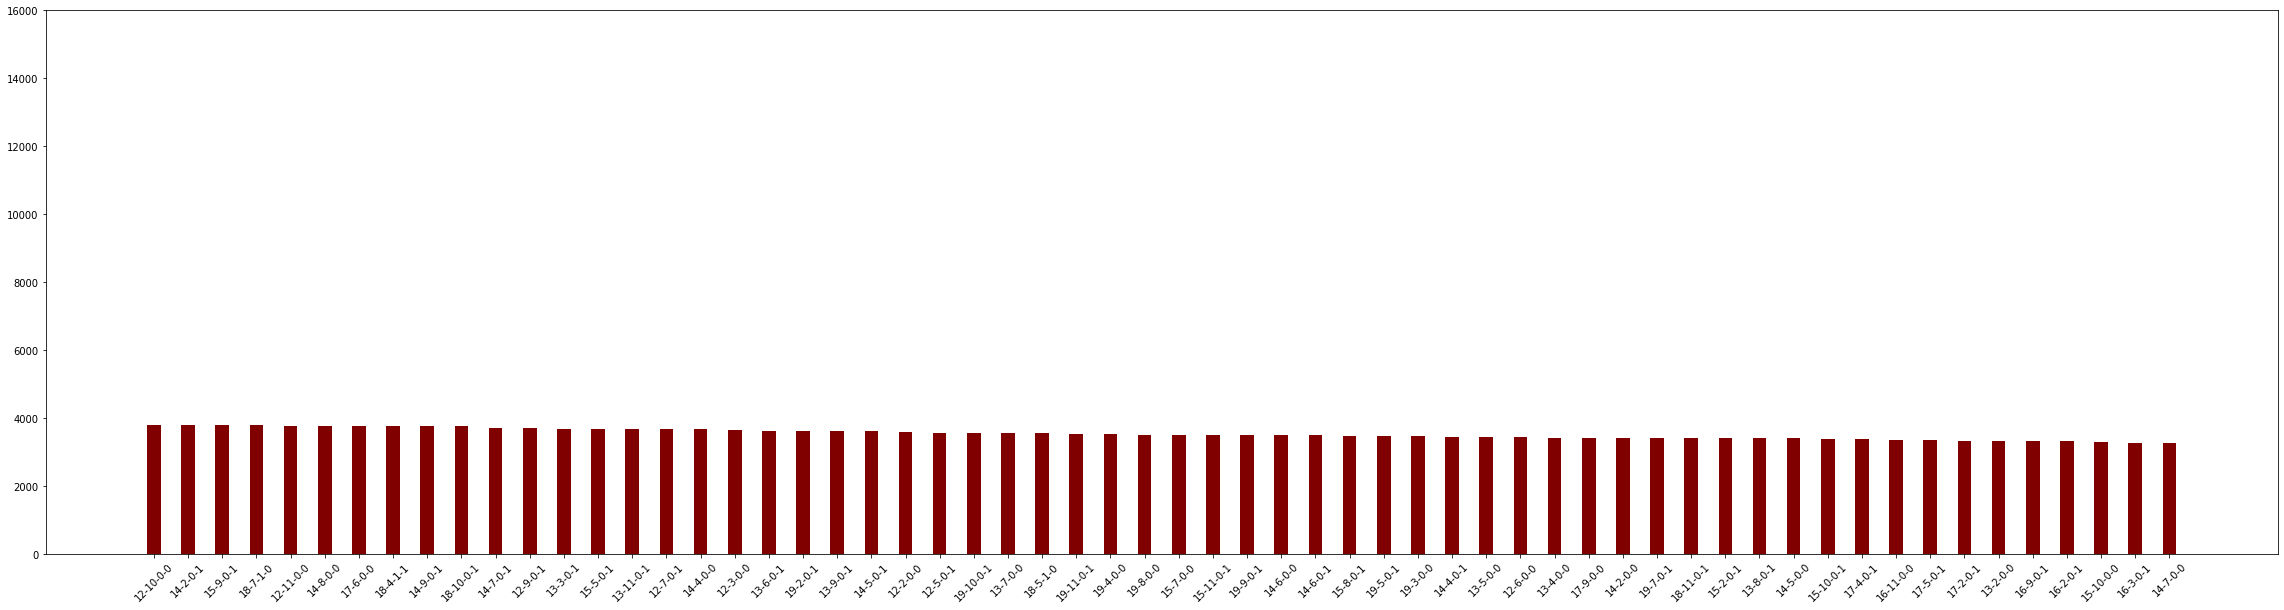

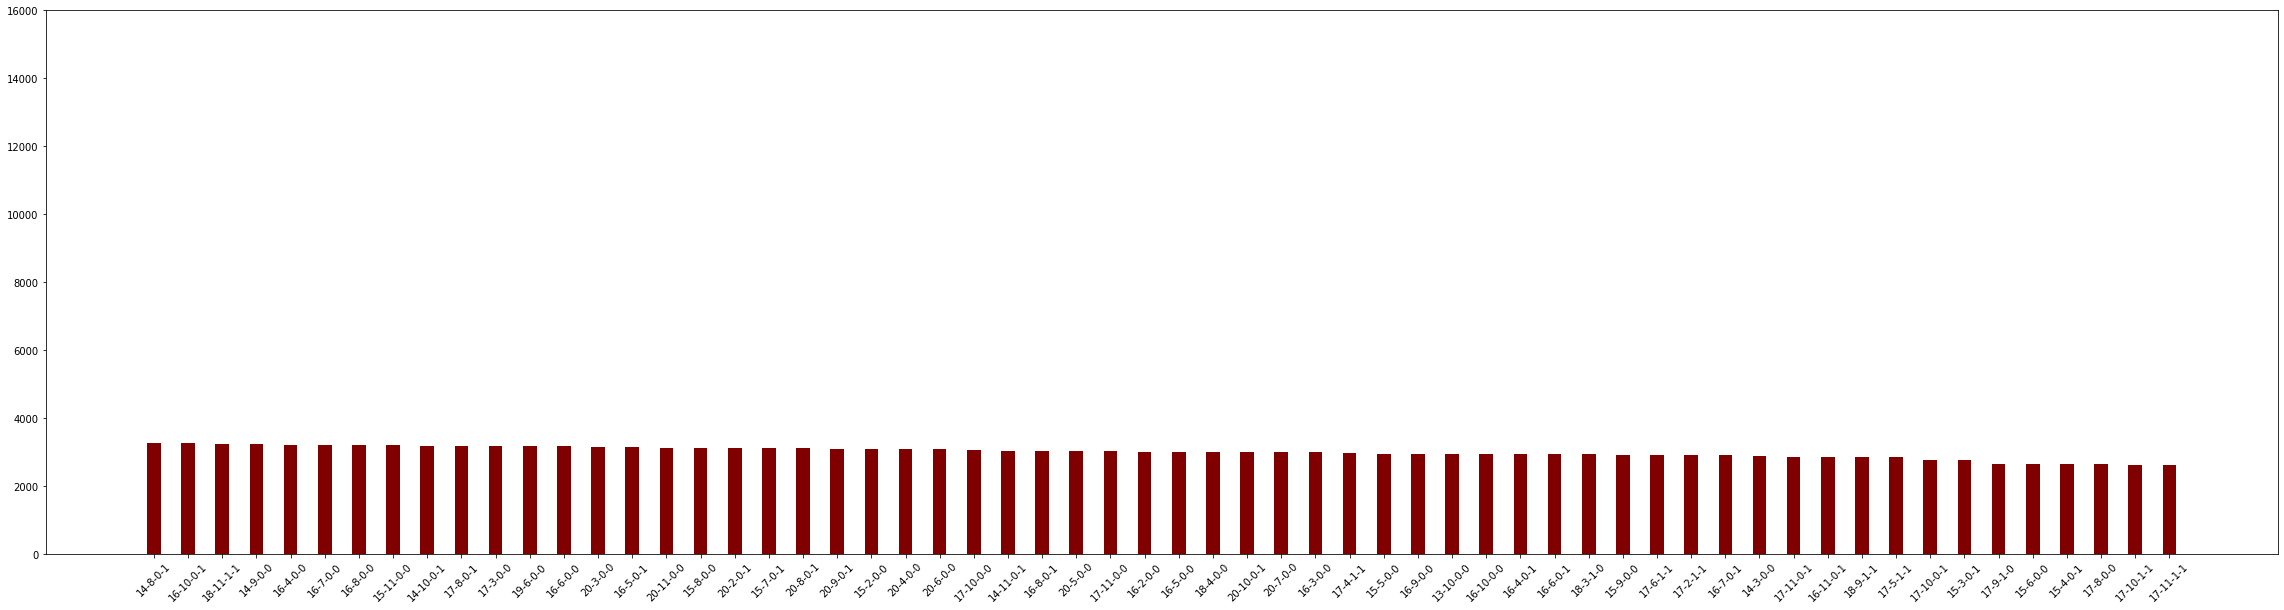

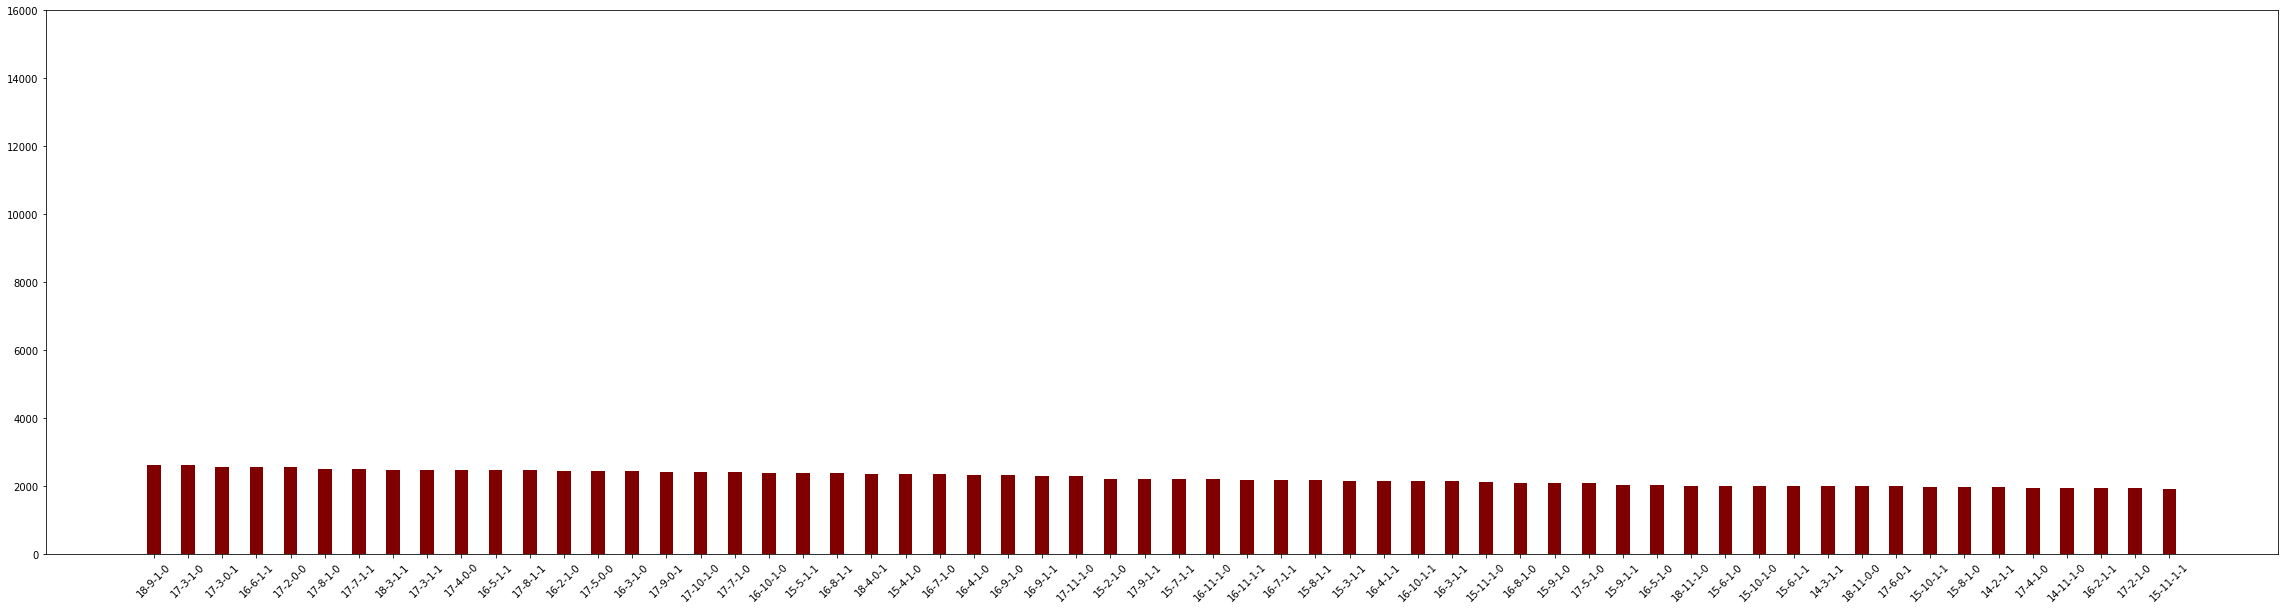

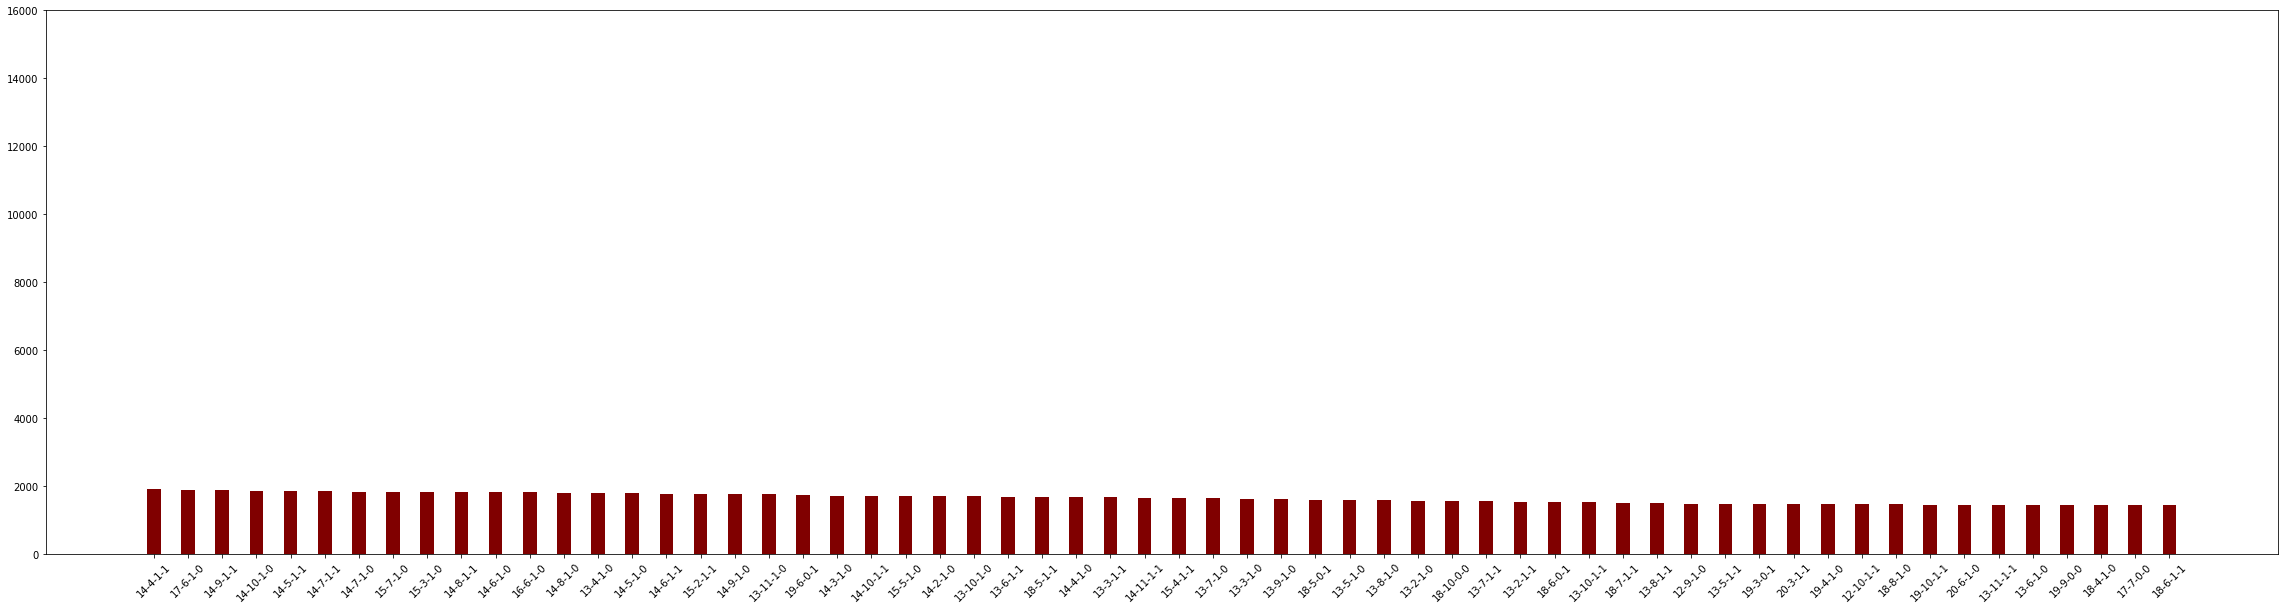

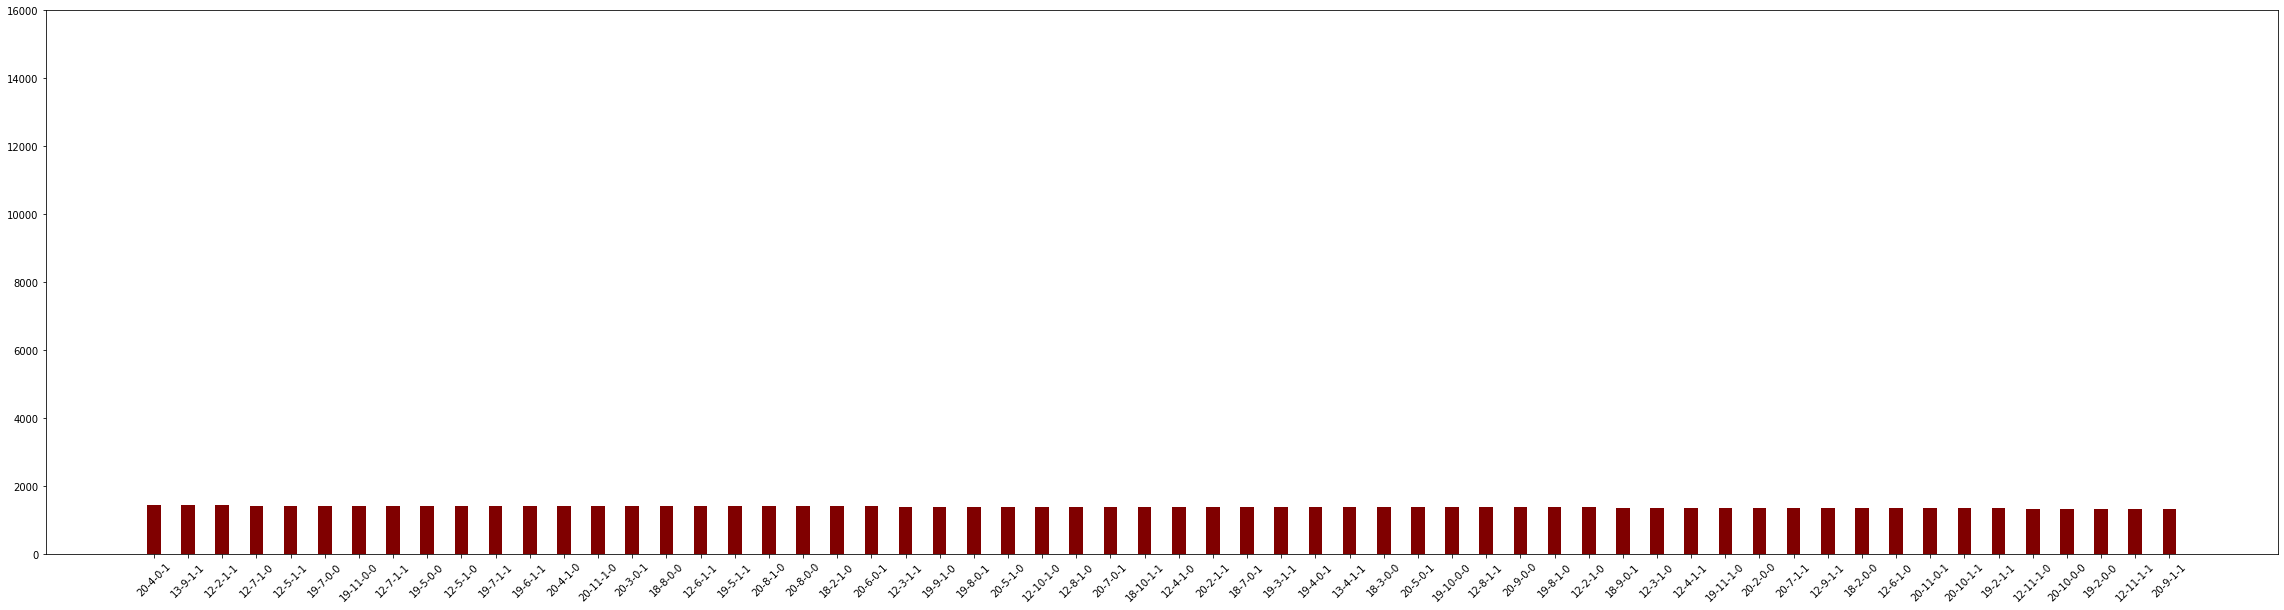

In [52]:
plotQACounts(mc)

#### Strategy table for MonteCarlo Exploring Starts algorithm 

In [53]:
print("With No Aces: ")
printStratTable(mc, 0)
print("\nWith Aces: ")
printStratTable(mc, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    H    S    S    H    S    H    H    S     H
 13  H    S    H    S    S    S    S    H    S     S
 14  S    S    S    H    H    S    S    S    H     H
 15  S    S    S    H    H    H    H    H    H     H
 16  H    H    S    S    S    H    S    H    H     S
 17  S    S    H    S    H    H    S    S    H     S
 18  H    H    H    S    S    S    H    S    H     H
 19  H    S    S    H    S    H    S    H    H     H
 20  H    S    S    S    S    S    H    H    H     S

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    S    H    H    S    S    S    S    S     S
 13  H    H    S    S    H    H    S    S    S     S
 14  H    H    H    S    H    S    S    H    S     S
 15  S    S    S    H    H    S    S    H    H     S
 16  H    S    S    S    H    H    S    S    H     H
 17  H    

### MonteCarlo Algorithm: No Exploring Starts
#### Training the algorithm
The monteCarlo no exploring starts algorithm was trained using 3 different epsilon values 

In [55]:
numOfEps = 500000

mc2 = monteCarloControl()
mc2.noExplStart(numOfEps, E2)

mc3 = monteCarloControl()
mc3.noExplStart(numOfEps, E3)

mc4 = monteCarloControl()
mc4.noExplStart(numOfEps, E4)

#### Wins - Draws - Losses

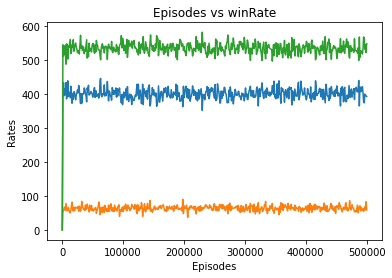

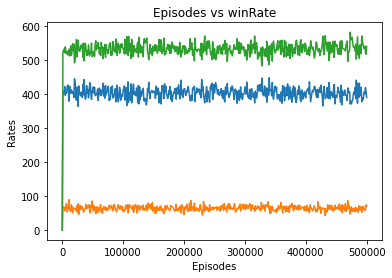

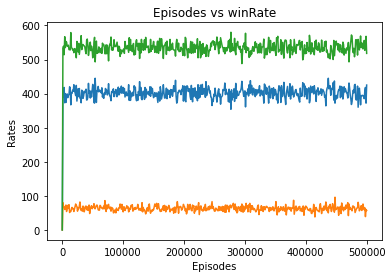

In [56]:
plotOutcomes(numOfEps, mc2)
plotOutcomes(numOfEps, mc3)
plotOutcomes(numOfEps, mc4)

#### Explored states for MonteCarlo Non Exploring Starts algorithm
MonteCarlo Non Exploring Starts with $ ε = 1/k $

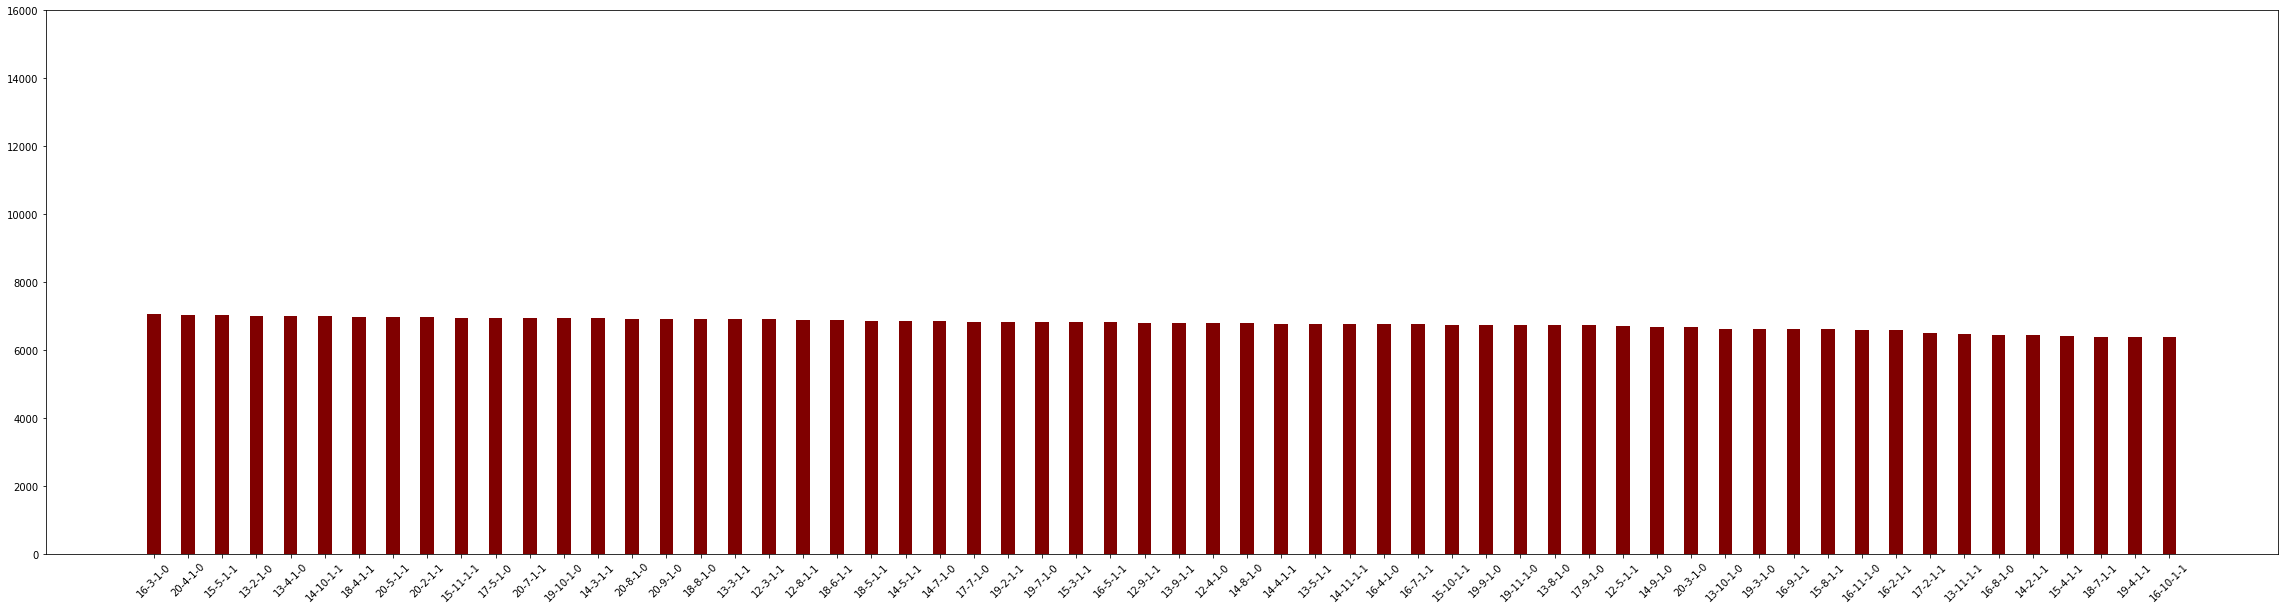

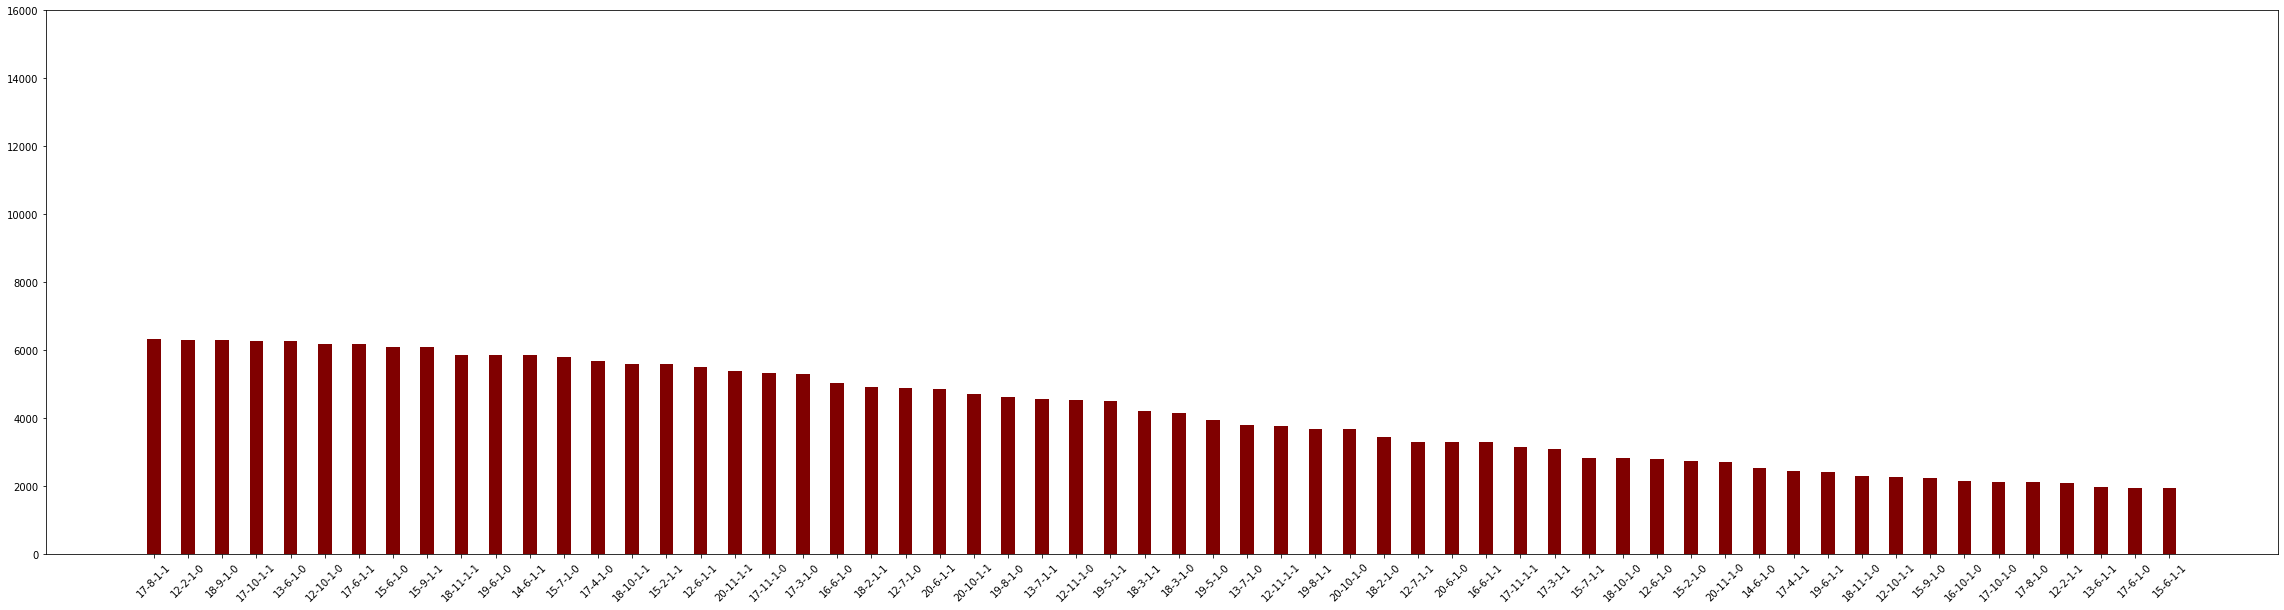

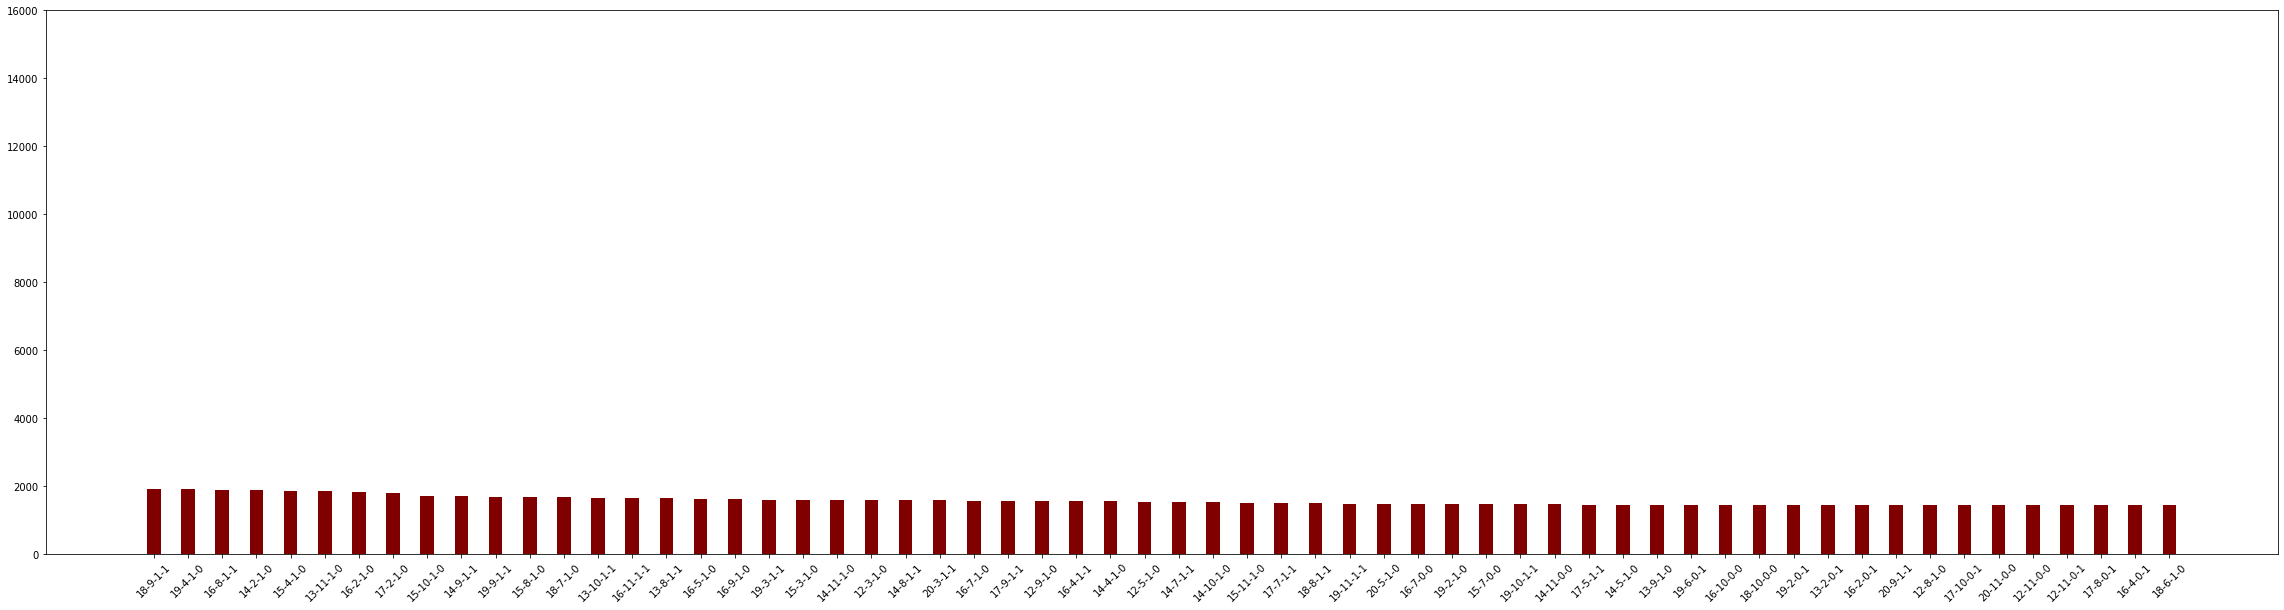

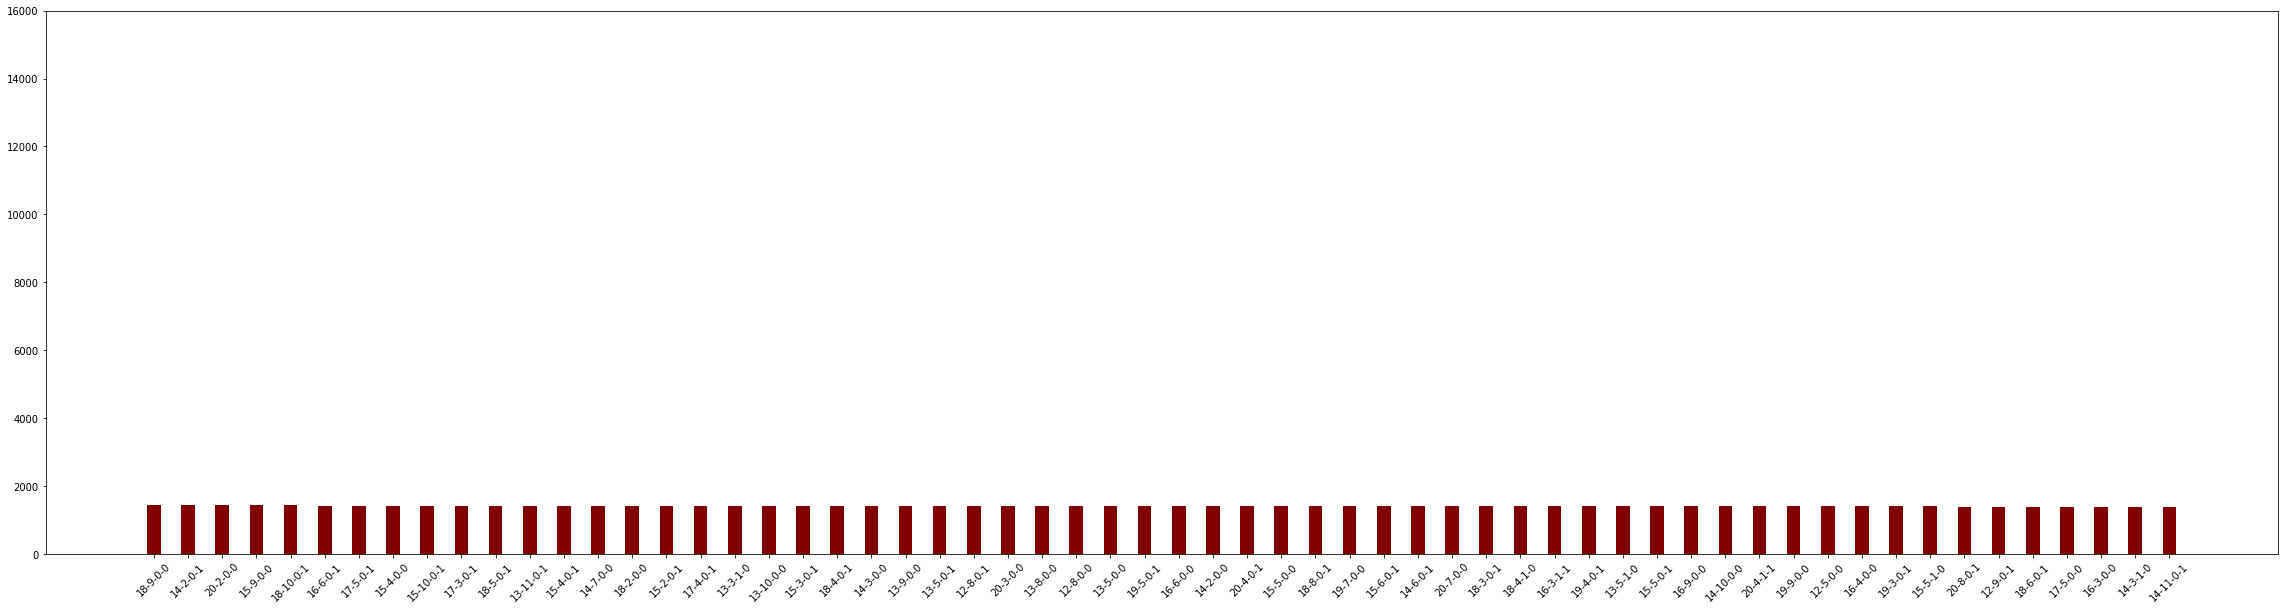

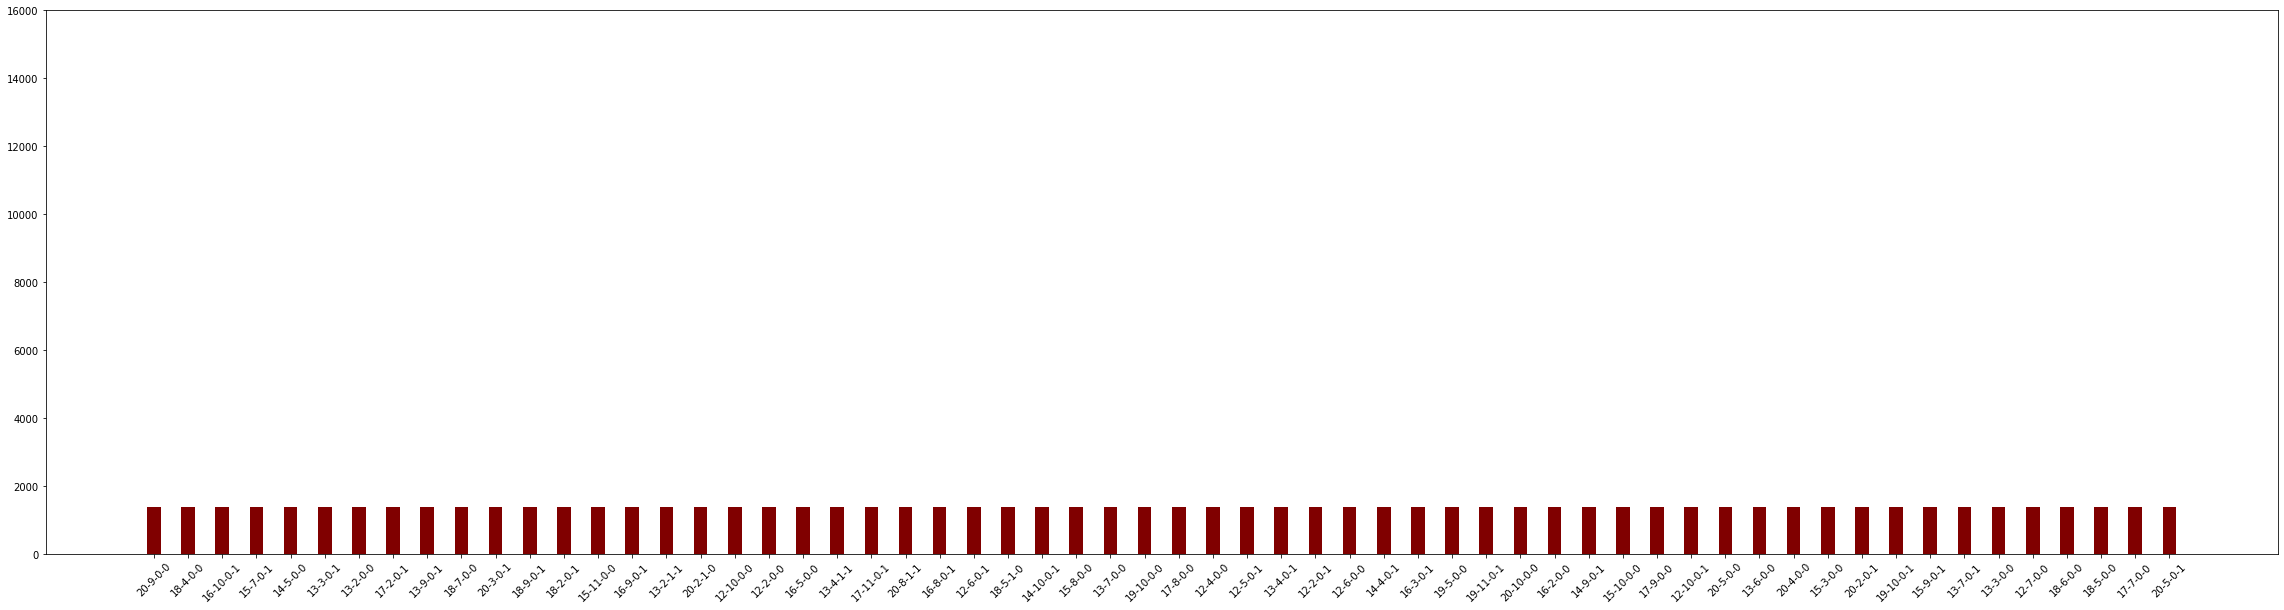

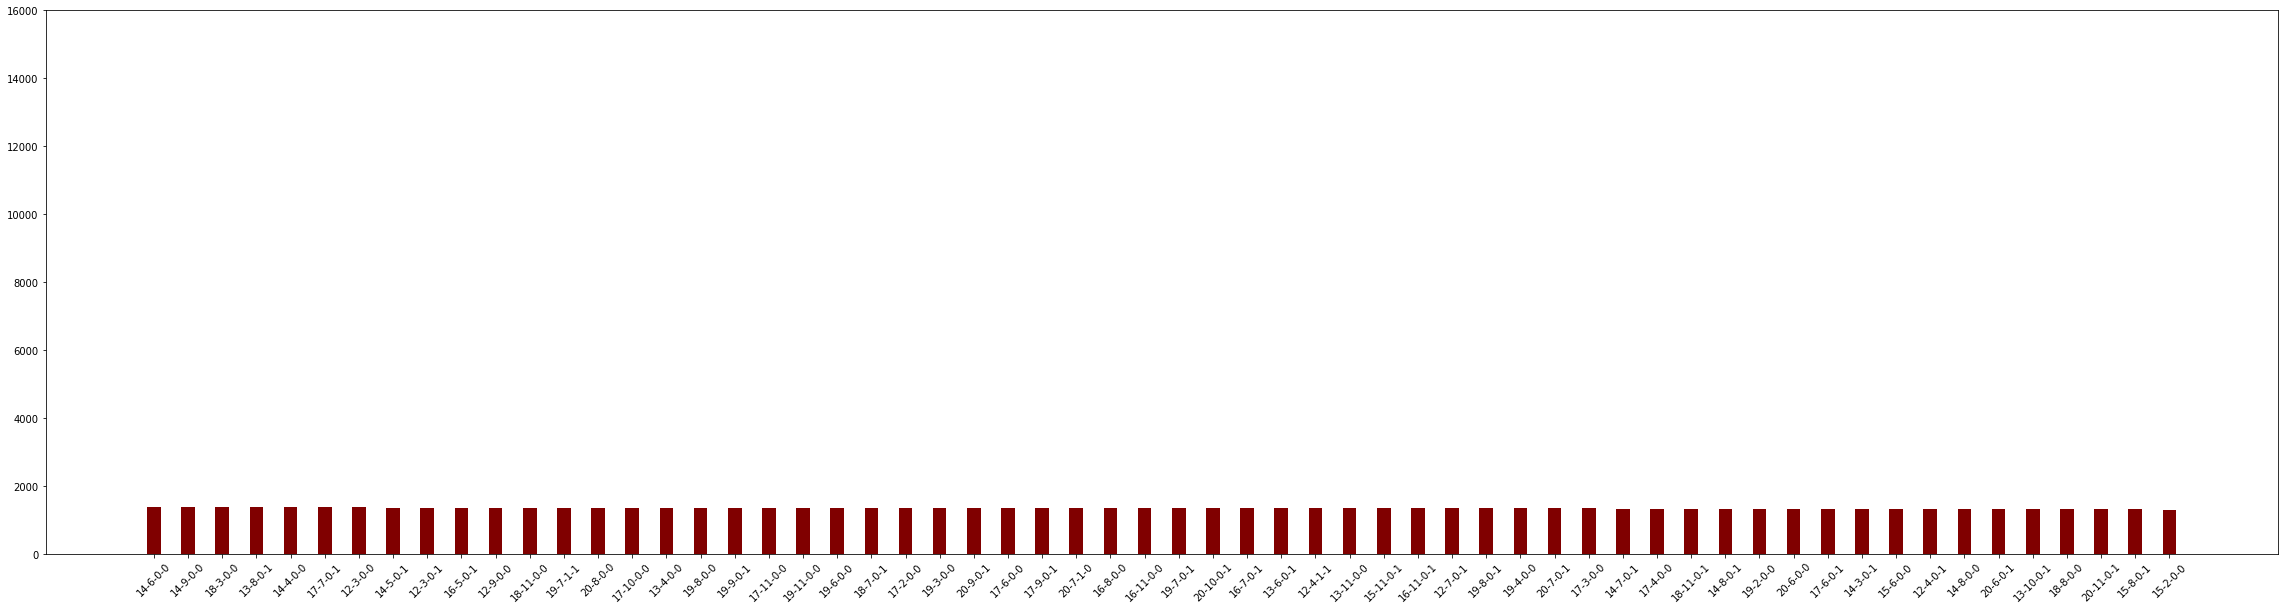

In [58]:
plotQACounts(mc2)

MonteCarlo Non Exploring Starts with $ ε = e^-k/1000 $

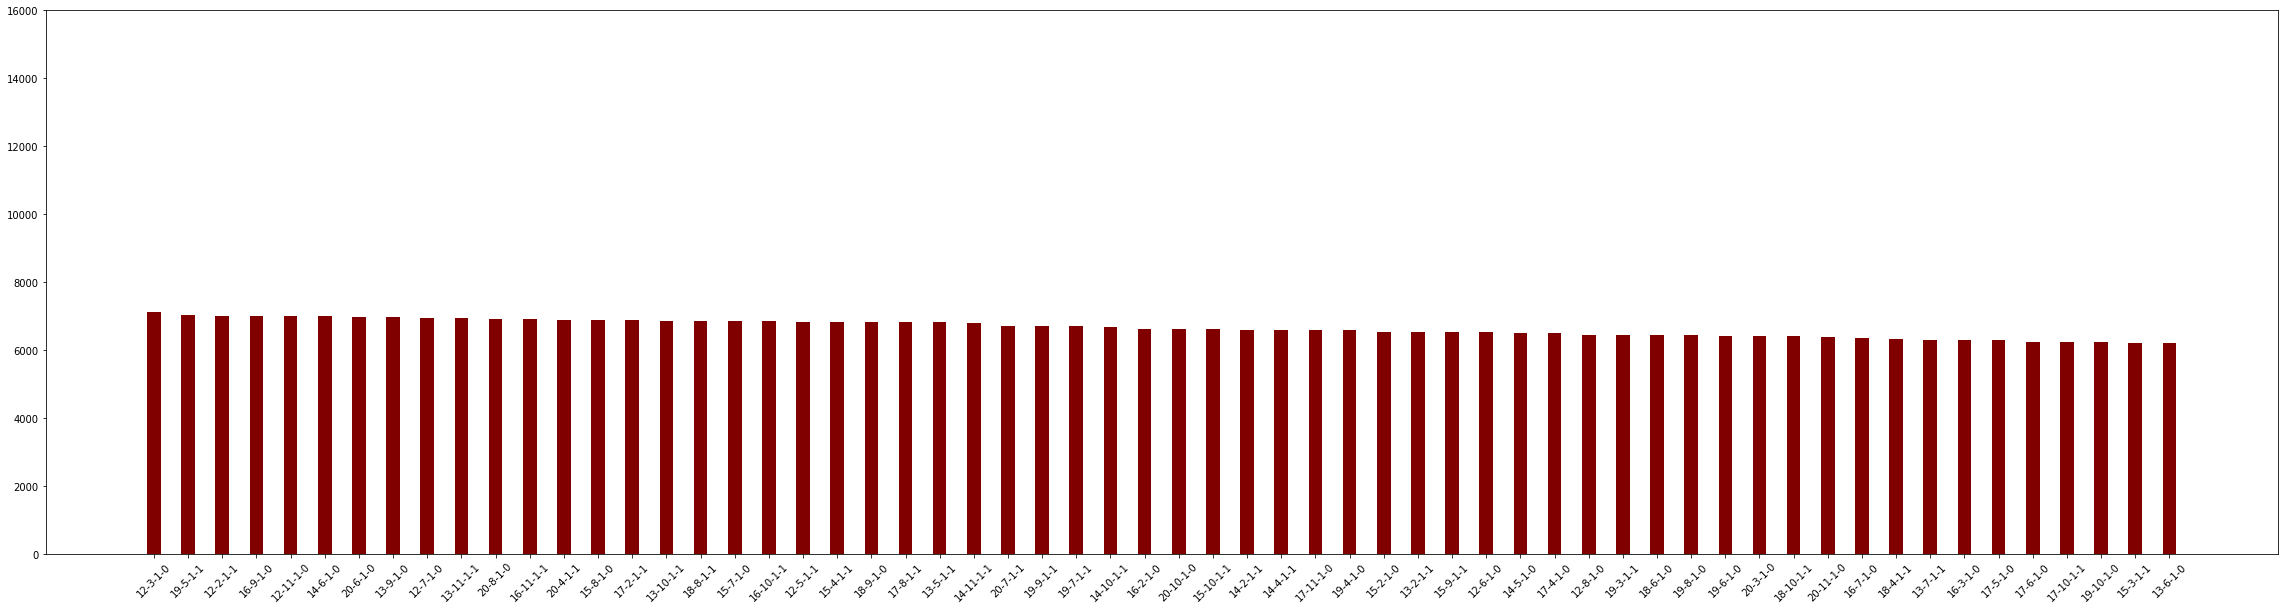

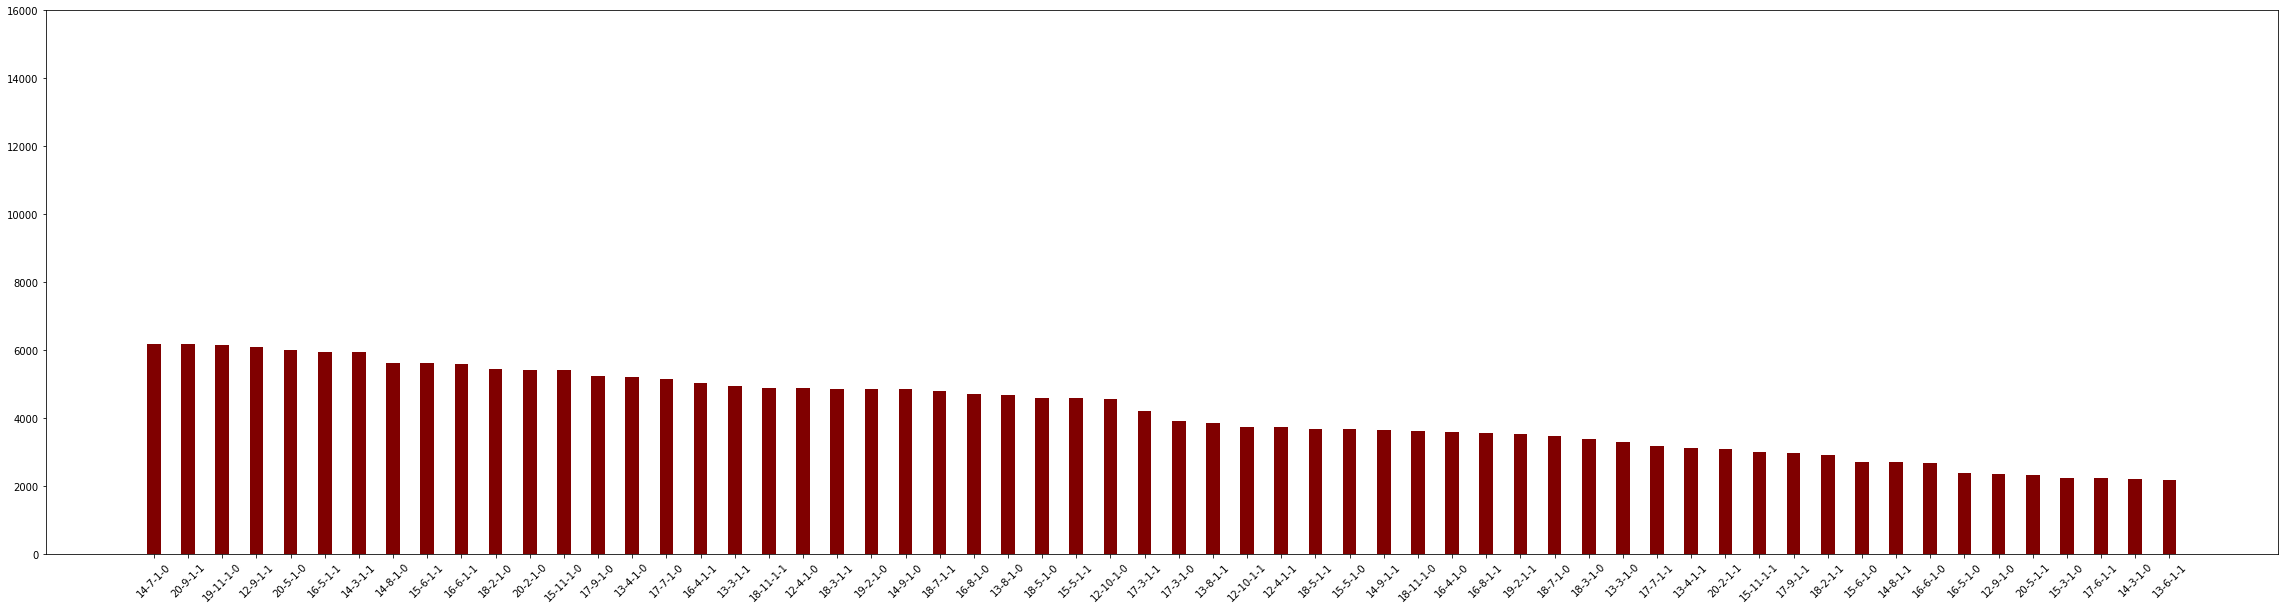

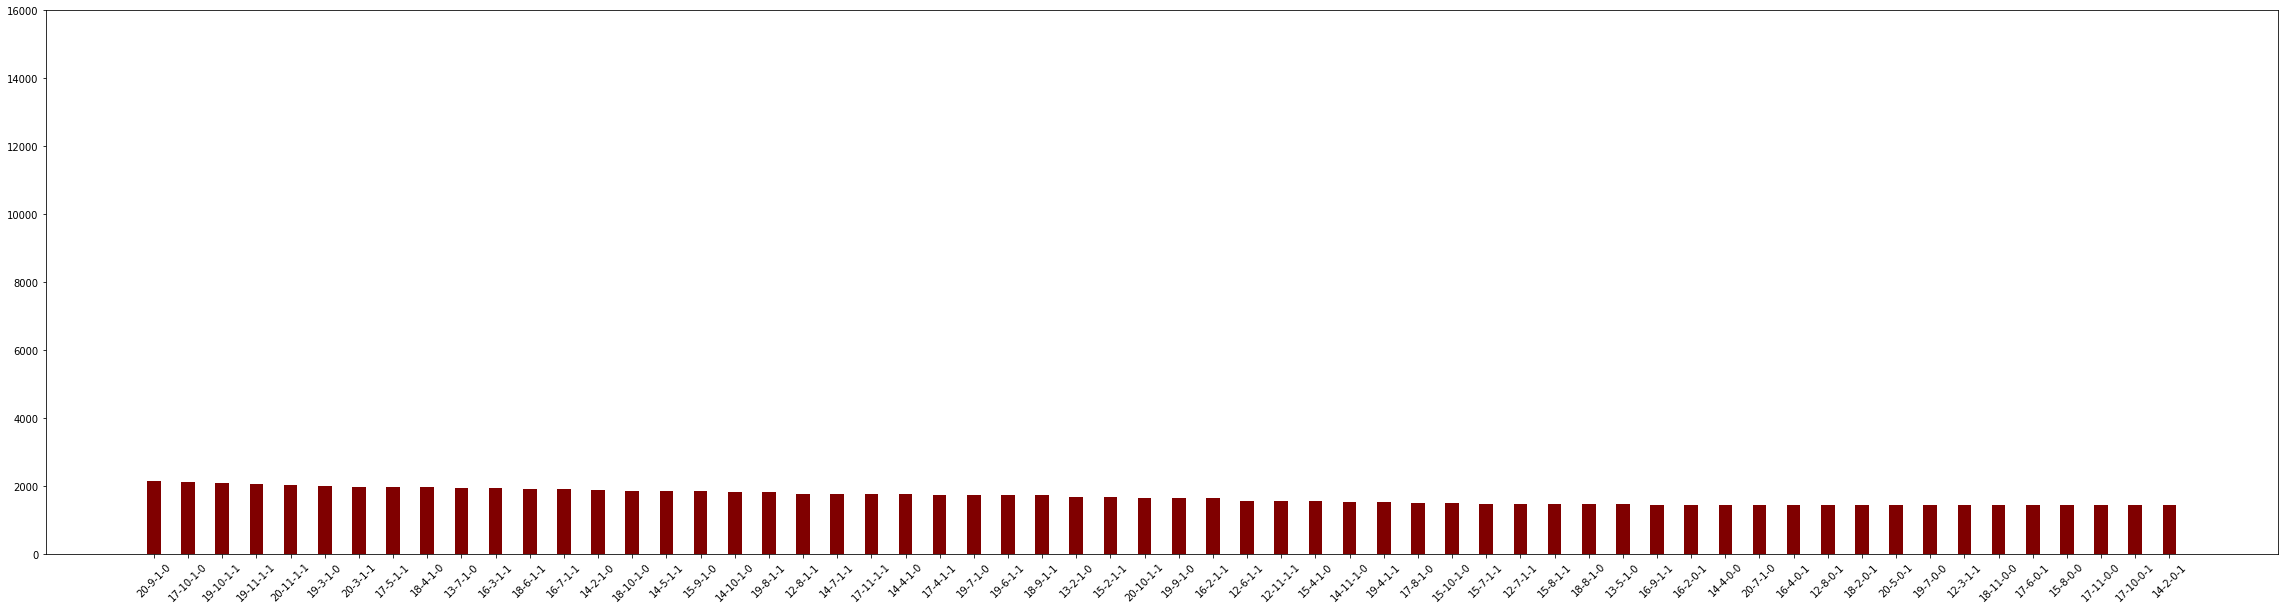

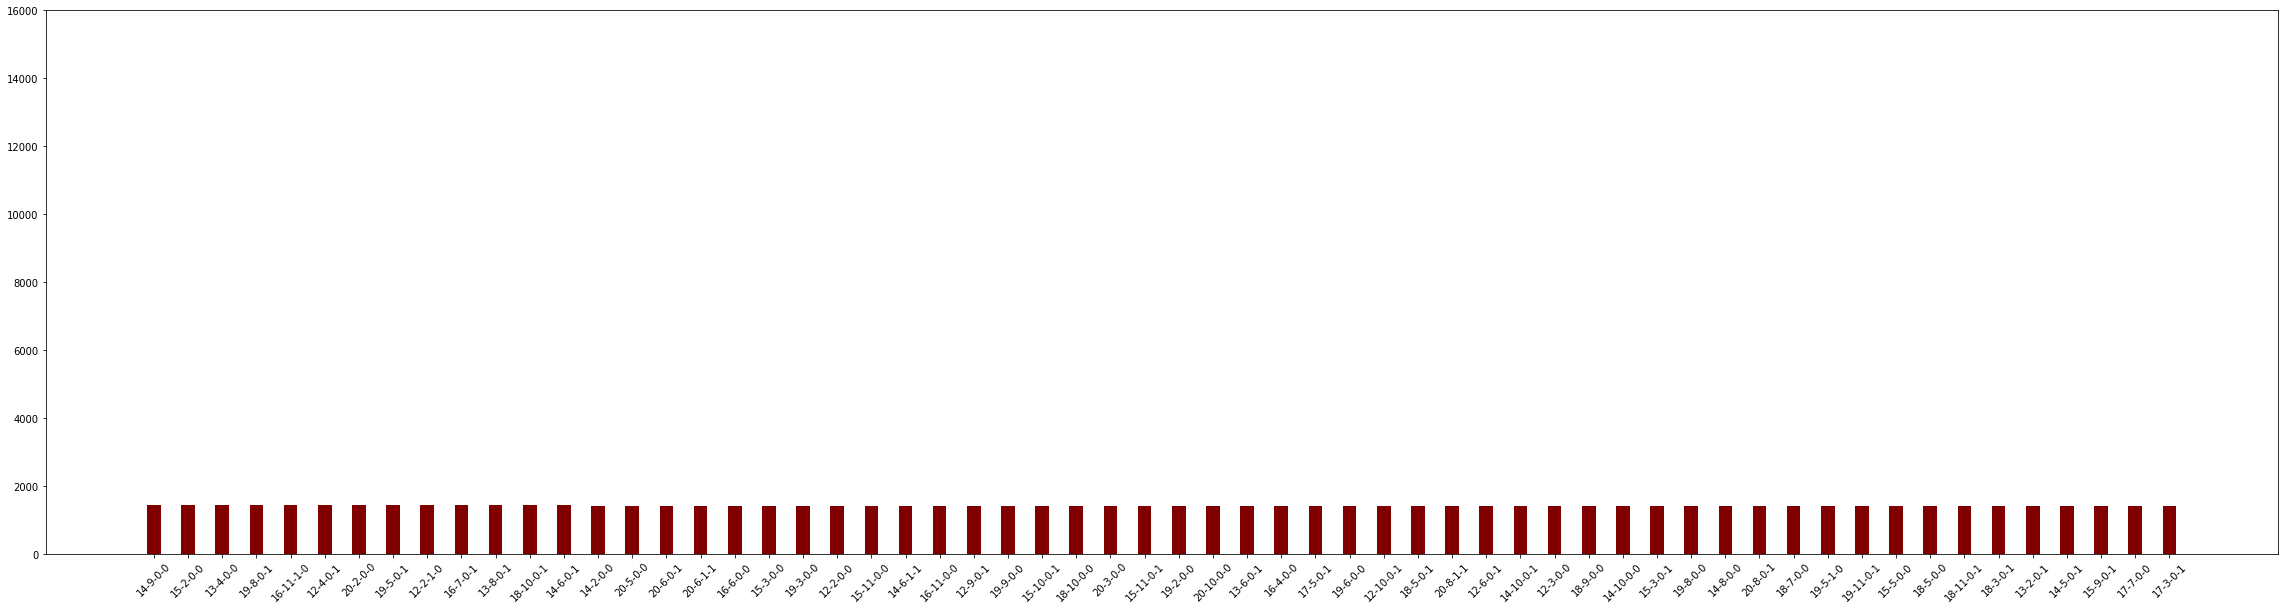

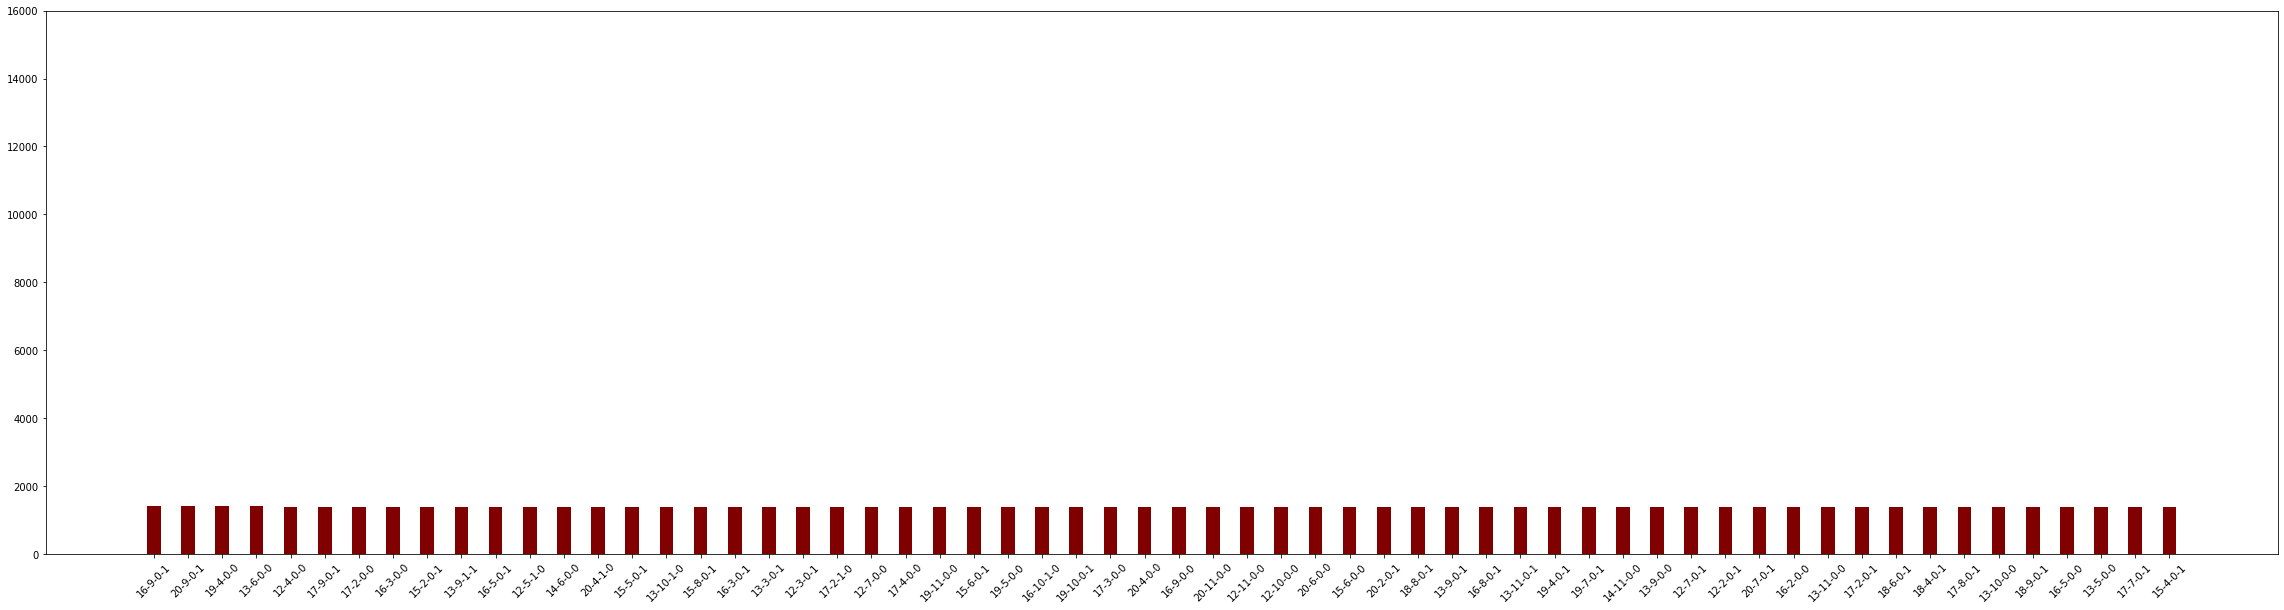

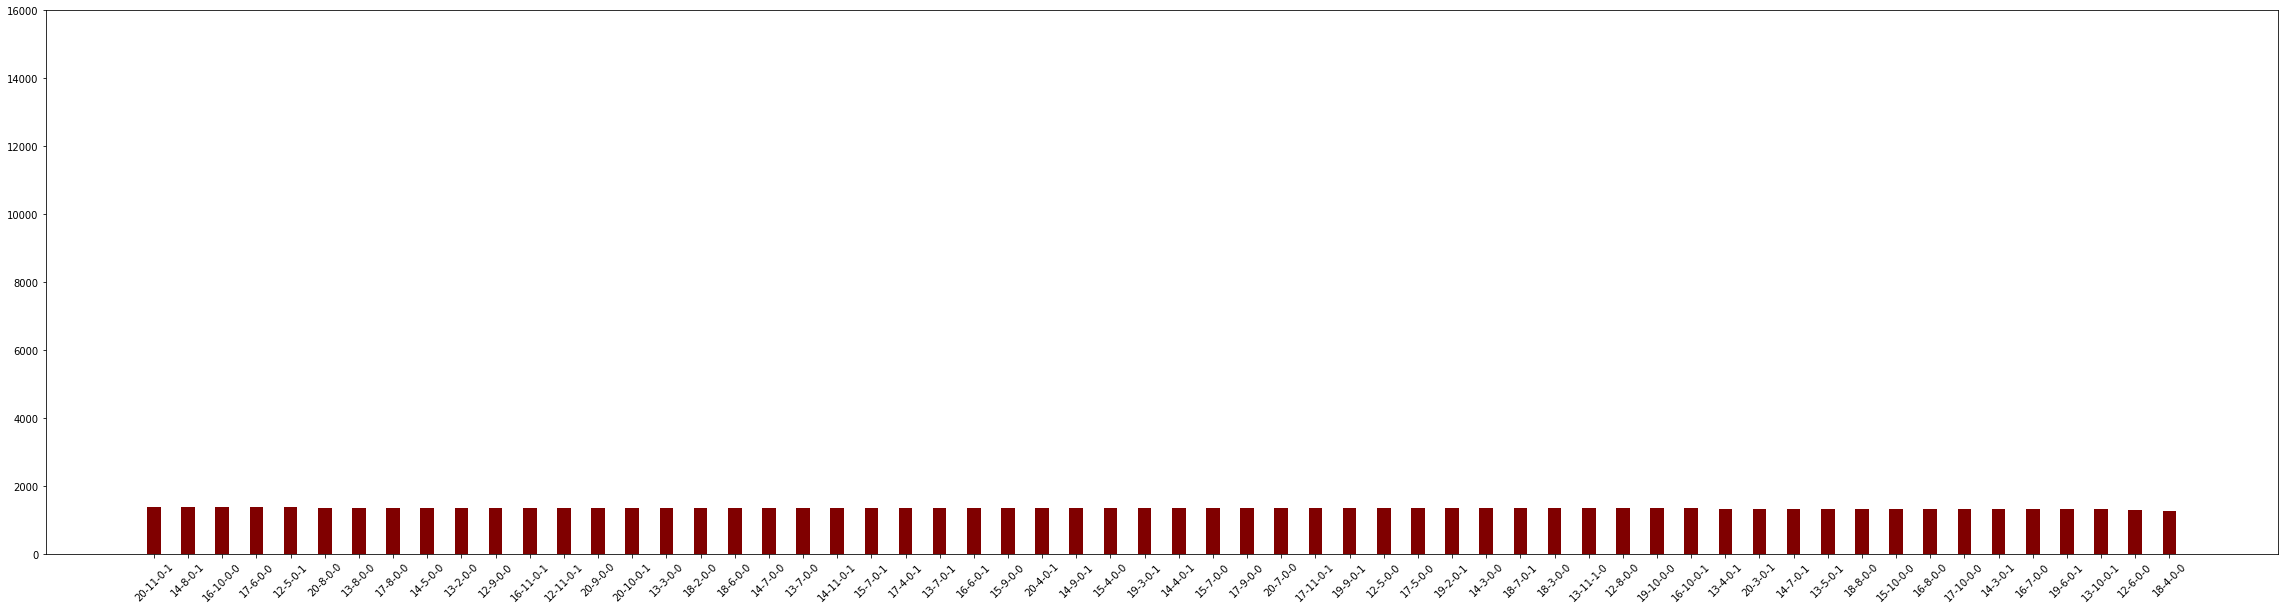

In [59]:
plotQACounts(mc3)

MonteCarlo Non Exploring Starts with $ ε = e^-k/10000 $

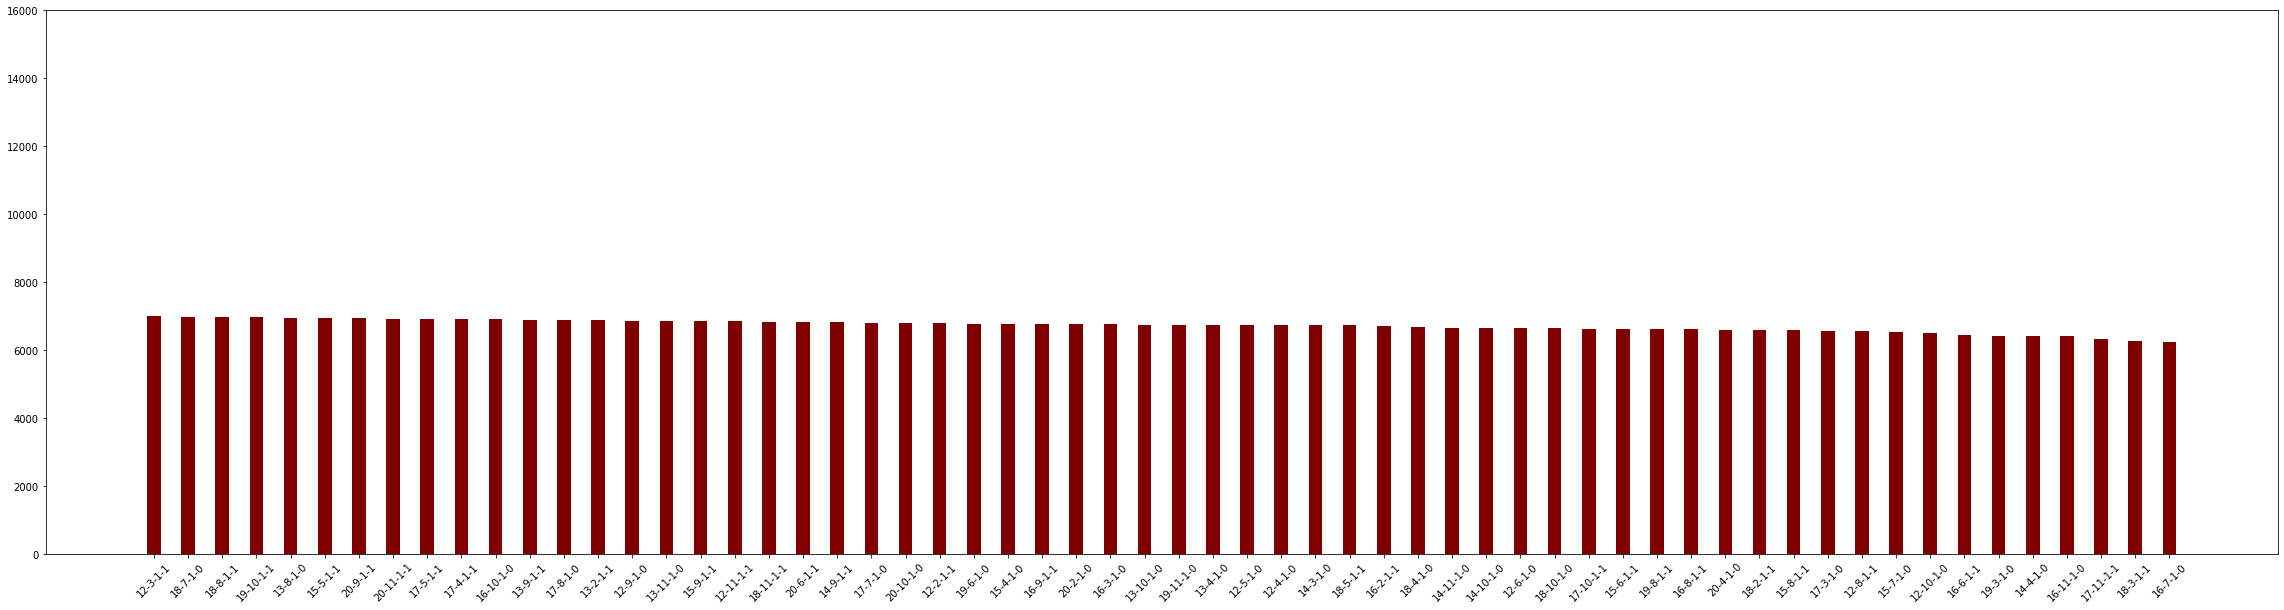

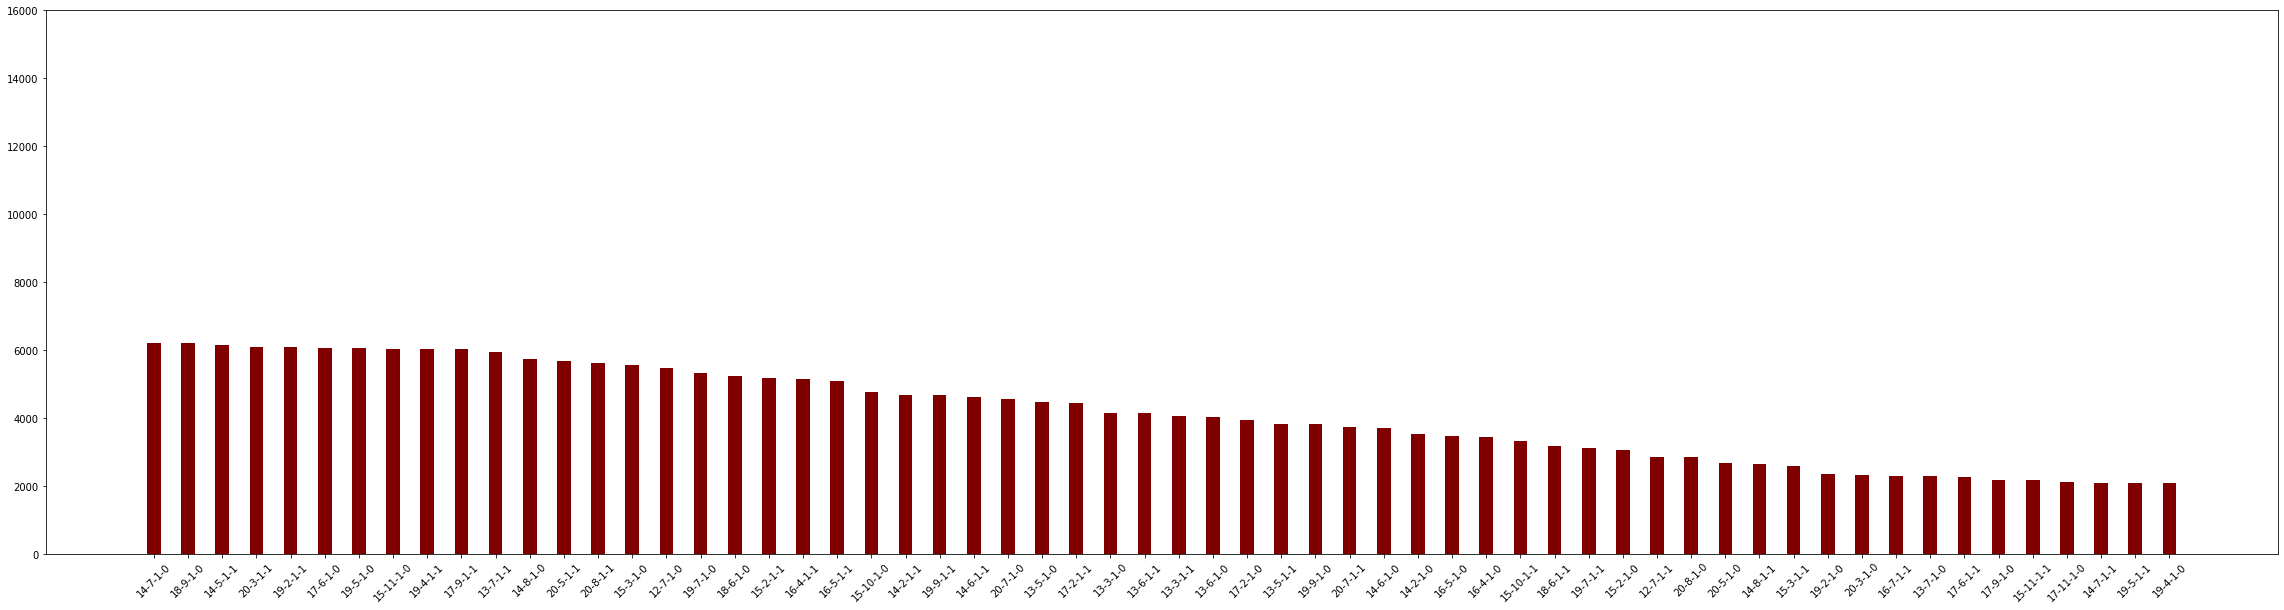

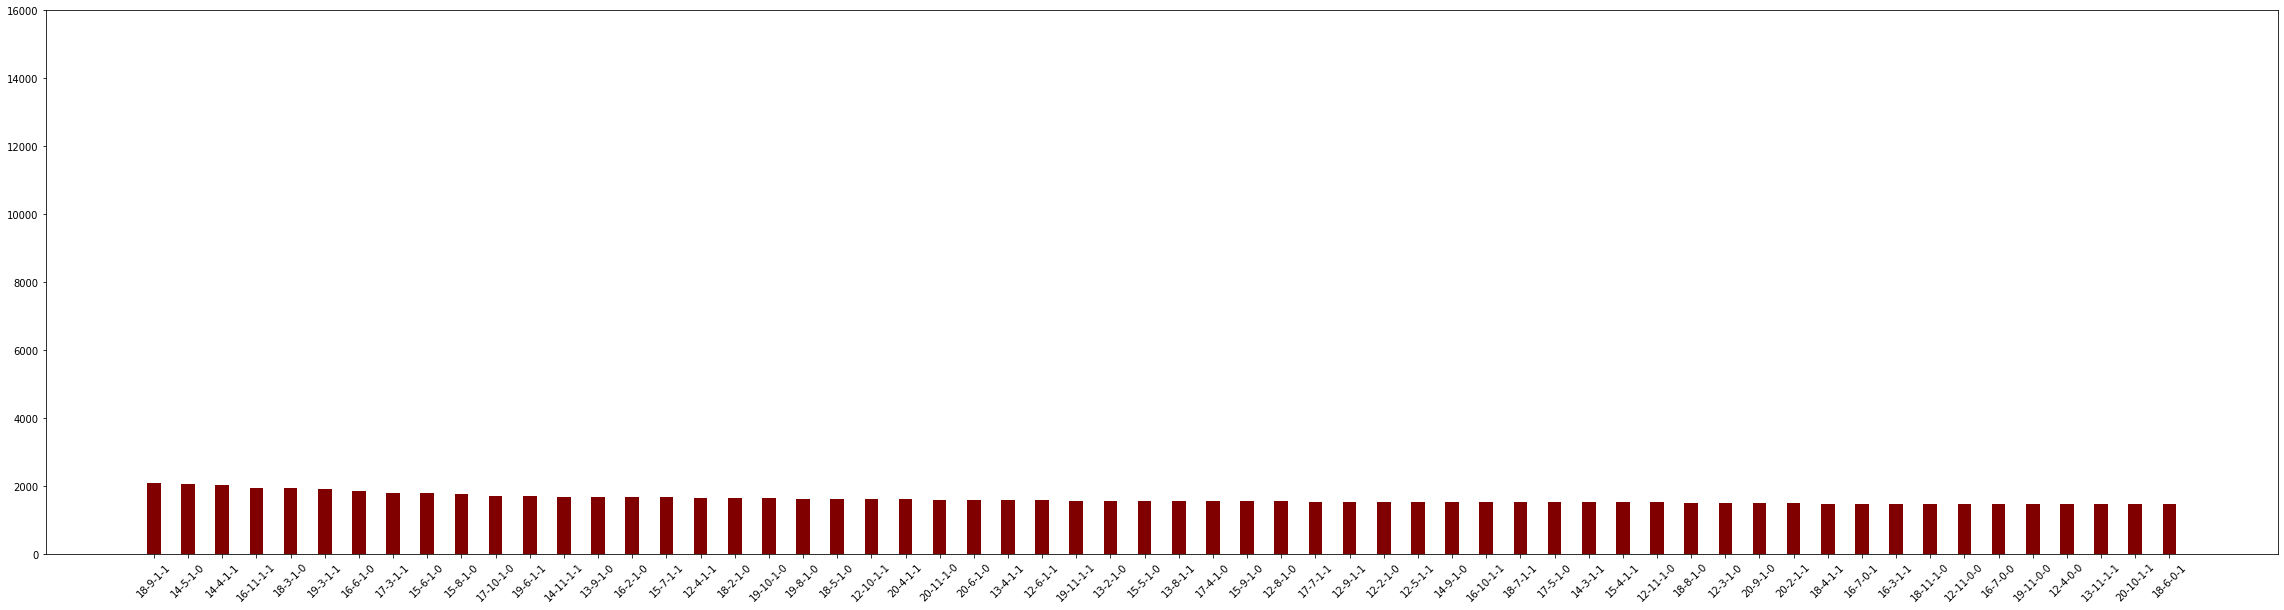

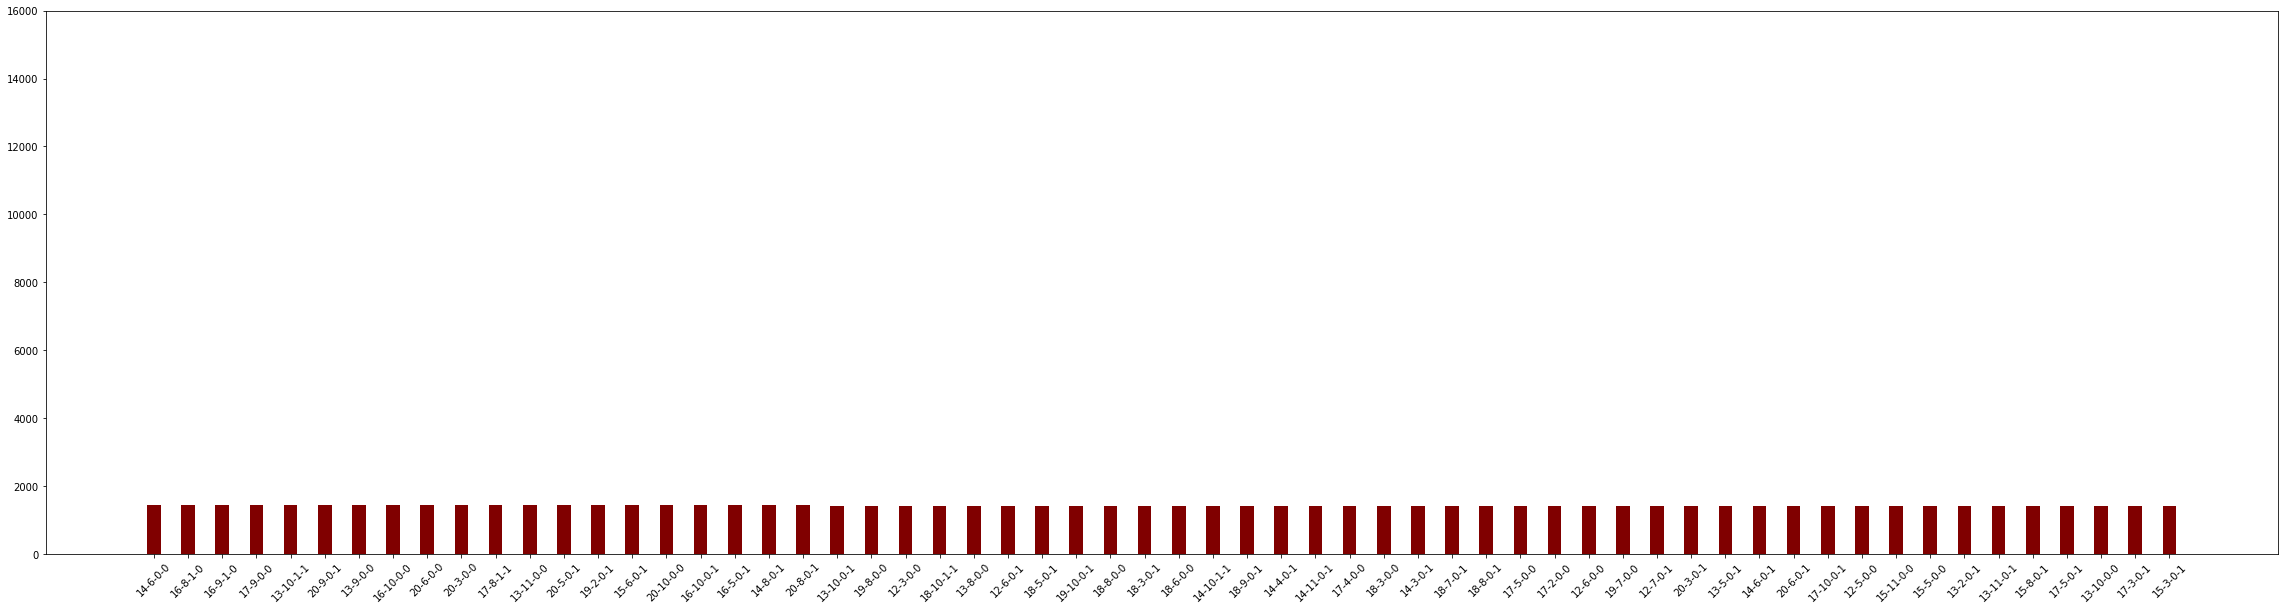

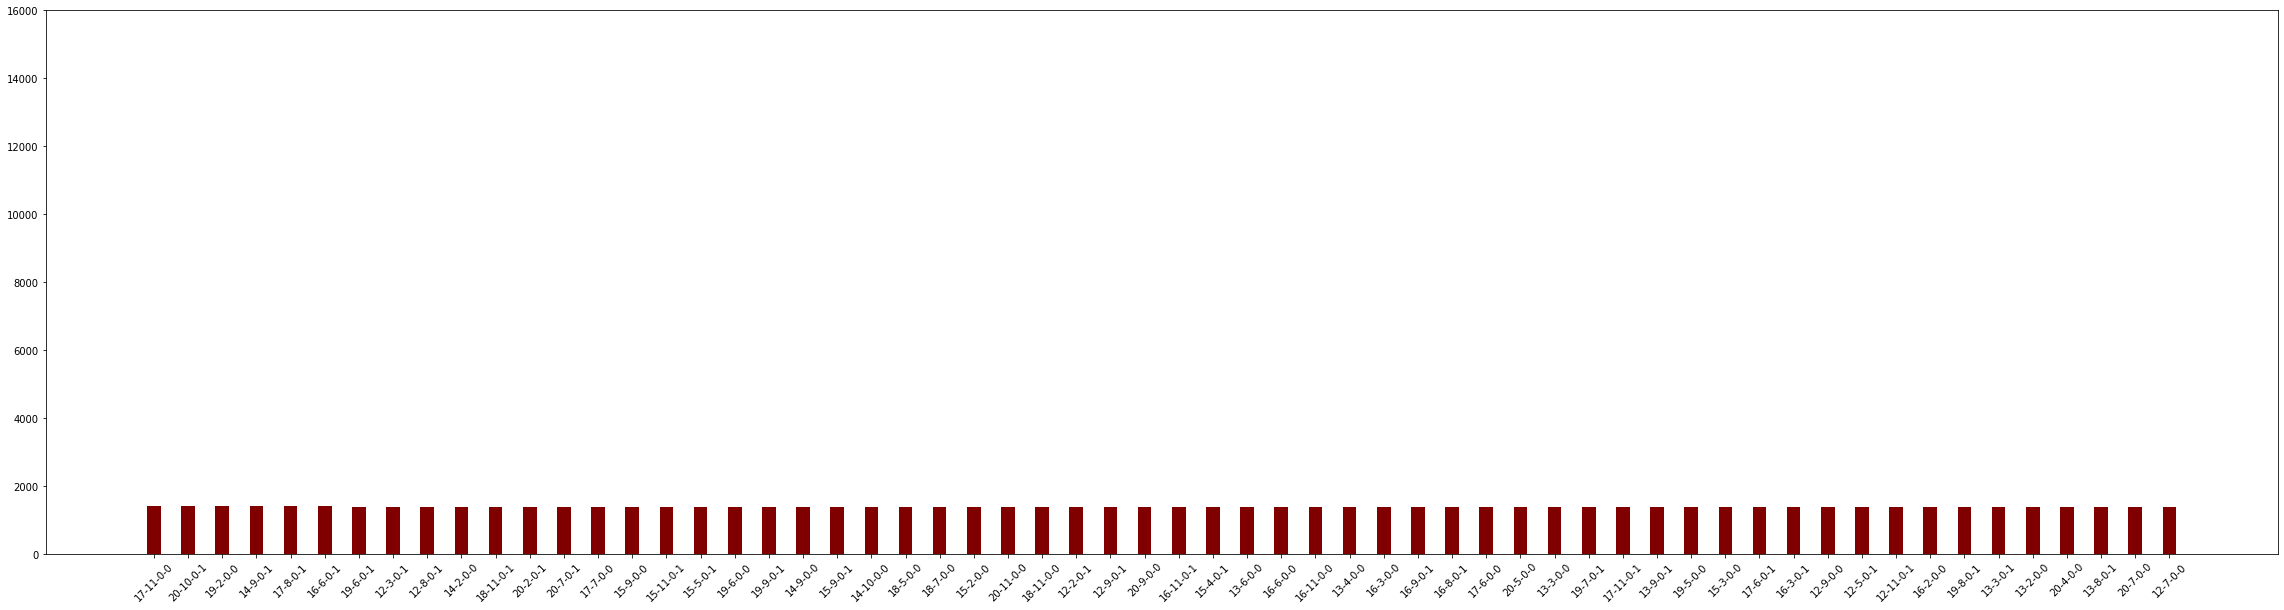

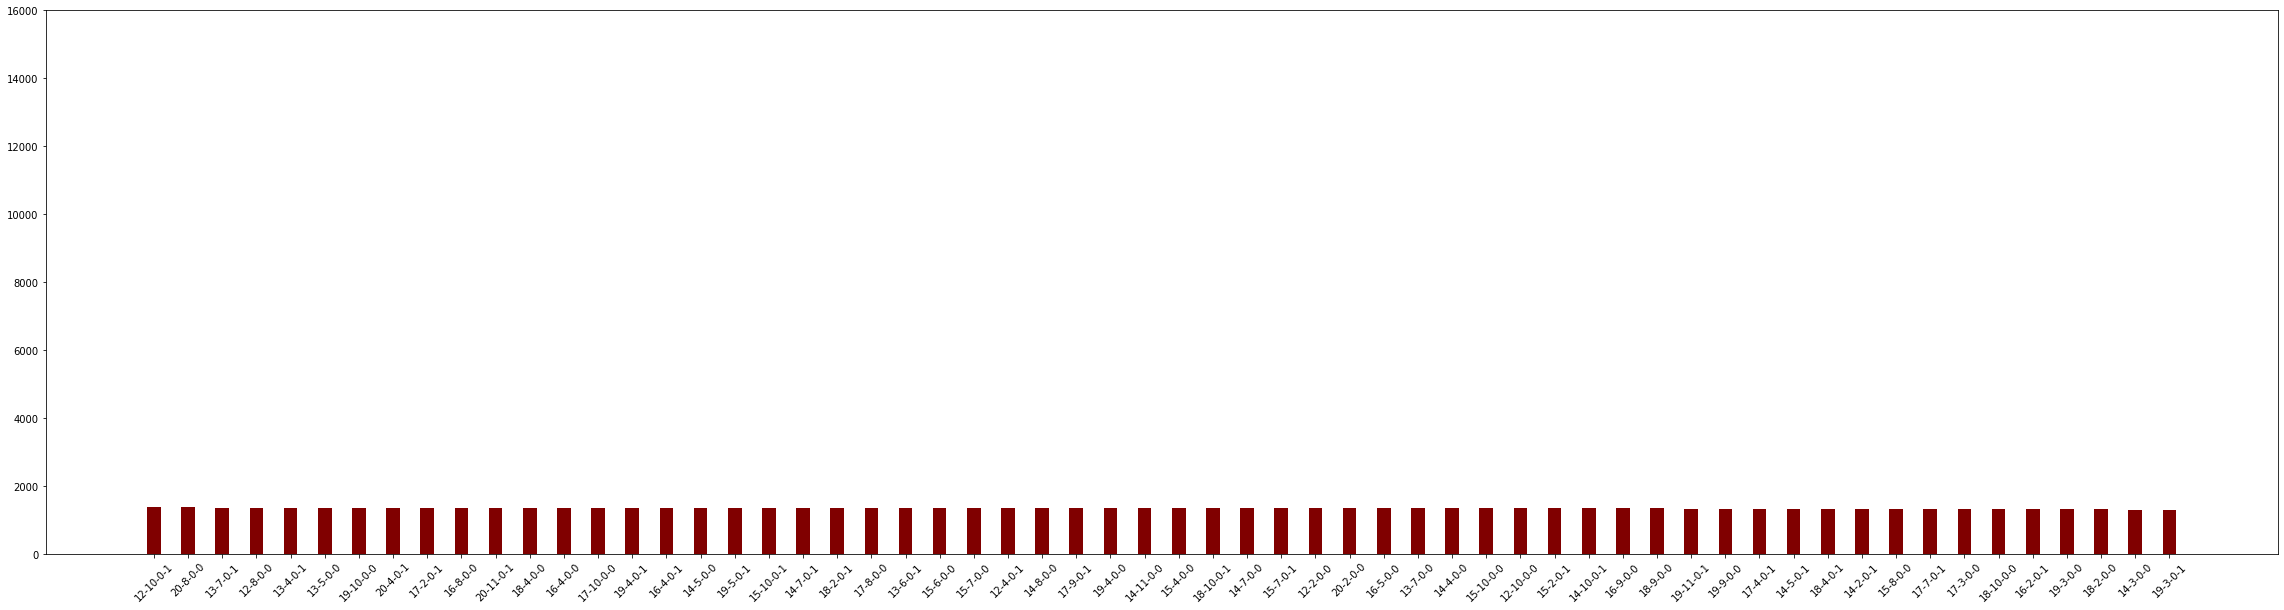

In [60]:
plotQACounts(mc4)

#### Strategy Tables for MonteCarlo Non Exploring Starts algorithm
MonteCarlo Non Exploring Starts with $ ε = 1/k $

In [61]:
print("With No Aces: ")
printStratTable(mc2, 0)
print("\nWith Aces: ")
printStratTable(mc2, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    S    H    H    S    S    S    S    H     S
 13  S    H    S    H    H    S    H    H    S     H
 14  H    S    H    H    S    H    H    S    S     S
 15  S    S    S    H    H    S    H    H    H     S
 16  H    S    S    S    H    H    S    H    H     H
 17  S    S    S    S    H    H    S    H    H     S
 18  H    S    S    S    H    H    H    S    H     S
 19  S    H    H    H    H    S    S    H    H     H
 20  S    H    S    S    H    H    H    H    H     H

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    H    S    H    H    H    H    H    S     H
 13  S    H    S    H    S    H    S    H    S     H
 14  H    H    H    H    H    S    S    S    H     H
 15  H    H    H    H    S    S    H    H    H     H
 16  H    S    S    H    S    H    S    H    H     S
 17  H    

MonteCarlo Non Exploring Starts with $ ε = e^-k/1000 $

In [62]:
print("With No Aces: ")
printStratTable(mc3, 0)
print("\nWith Aces: ")
printStratTable(mc3, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    H    S    H    H    H    H    H    H     H
 13  S    H    S    S    H    S    S    S    H     S
 14  S    S    S    S    S    S    S    H    S     S
 15  H    S    S    H    S    S    S    S    S     H
 16  S    H    S    S    H    S    S    S    H     H
 17  S    S    S    S    S    H    S    S    H     H
 18  S    H    S    H    S    S    H    H    S     H
 19  H    S    H    H    S    H    H    H    S     H
 20  H    S    H    S    H    S    H    H    H     S

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    S    H    H    S    S    S    H    H     S
 13  H    S    H    H    S    H    H    S    H     H
 14  H    H    H    S    S    S    H    S    H     H
 15  S    H    H    S    S    S    S    H    H     S
 16  S    H    H    H    H    S    S    S    H     H
 17  H    

MonteCarlo Non Exploring Starts with $ ε = e^-k/10000 $

In [63]:
print("With No Aces: ")
printStratTable(mc4, 0)
print("\nWith Aces: ")
printStratTable(mc4, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    H    S    H    H    S    H    S    S     H
 13  H    H    H    S    H    H    H    H    S     S
 14  S    S    H    H    H    H    H    H    S     S
 15  H    S    S    S    H    S    S    H    H     H
 16  H    H    S    S    S    H    S    S    S     H
 17  S    H    S    S    S    S    H    H    H     H
 18  H    H    H    S    H    H    H    H    H     S
 19  S    S    S    H    H    H    H    H    H     S
 20  S    H    H    H    S    H    H    S    H     H

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    H    S    S    S    H    H    S    S     H
 13  H    S    S    S    H    H    S    H    S     S
 14  H    S    S    H    S    S    S    H    S     S
 15  H    H    S    H    H    S    H    H    S     S
 16  H    S    S    H    H    S    H    H    S     S
 17  H    

#### Unique state-action pairs for different epsilon values across MonetCarlo algorithms

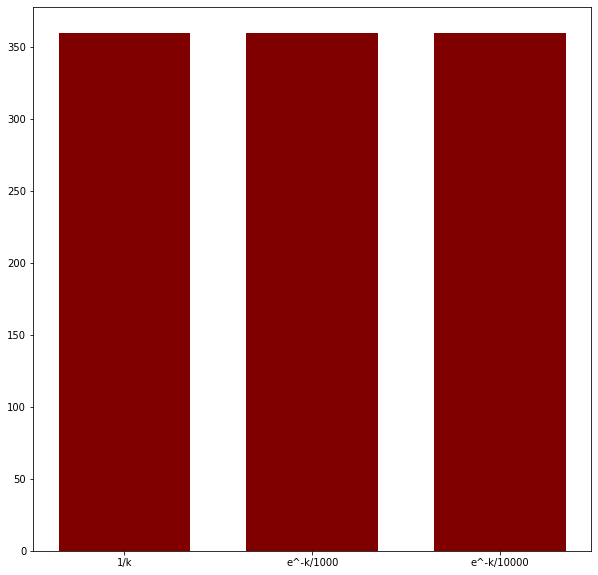

In [66]:
plotHist([mc2, mc3, mc4], ["1/k", "e^-k/1000","e^-k/10000"])

### SARSA Algorithm 

#### Training the algorithm

Training was done using 4 different values for epsilon 

In [20]:
sarsaE1 = SARSA()
sarsaE2 = SARSA()
sarsaE3 = SARSA()
sarsaE4 = SARSA()   


sarsaE1.training(numOfEps, E1)
sarsaE2.training(numOfEps, E2)
sarsaE3.training(numOfEps, E3)
sarsaE4.training(numOfEps, E4)

#### Wins - Draws - Losses

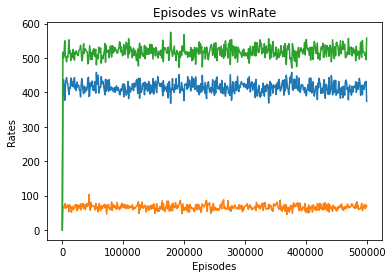

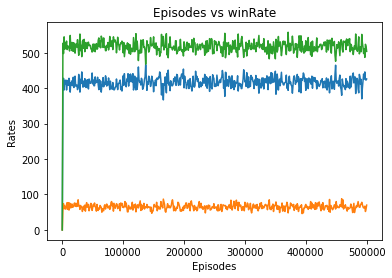

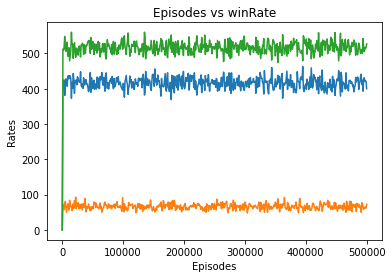

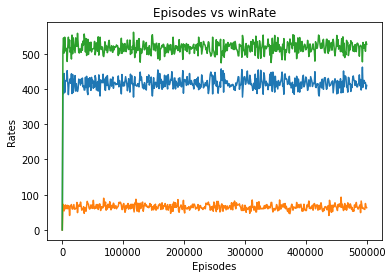

In [21]:
plotOutcomes(numOfEps, sarsaE1)
plotOutcomes(numOfEps, sarsaE2)
plotOutcomes(numOfEps, sarsaE3)
plotOutcomes(numOfEps, sarsaE4)

#### Explored states for sarsa algorithms
Sarsa with: $ ε = 0.1 $

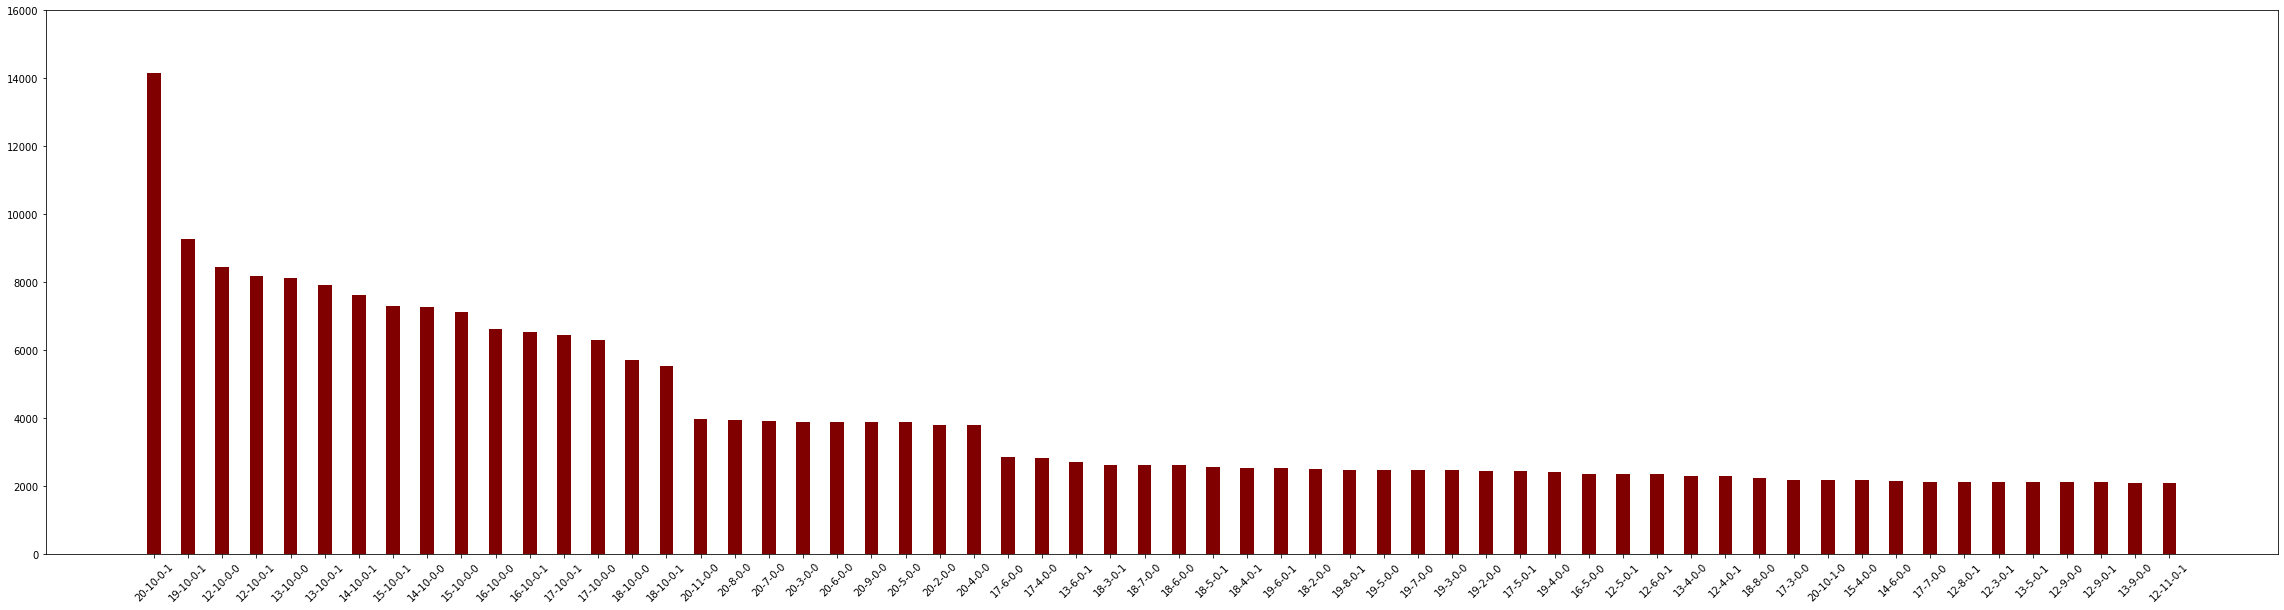

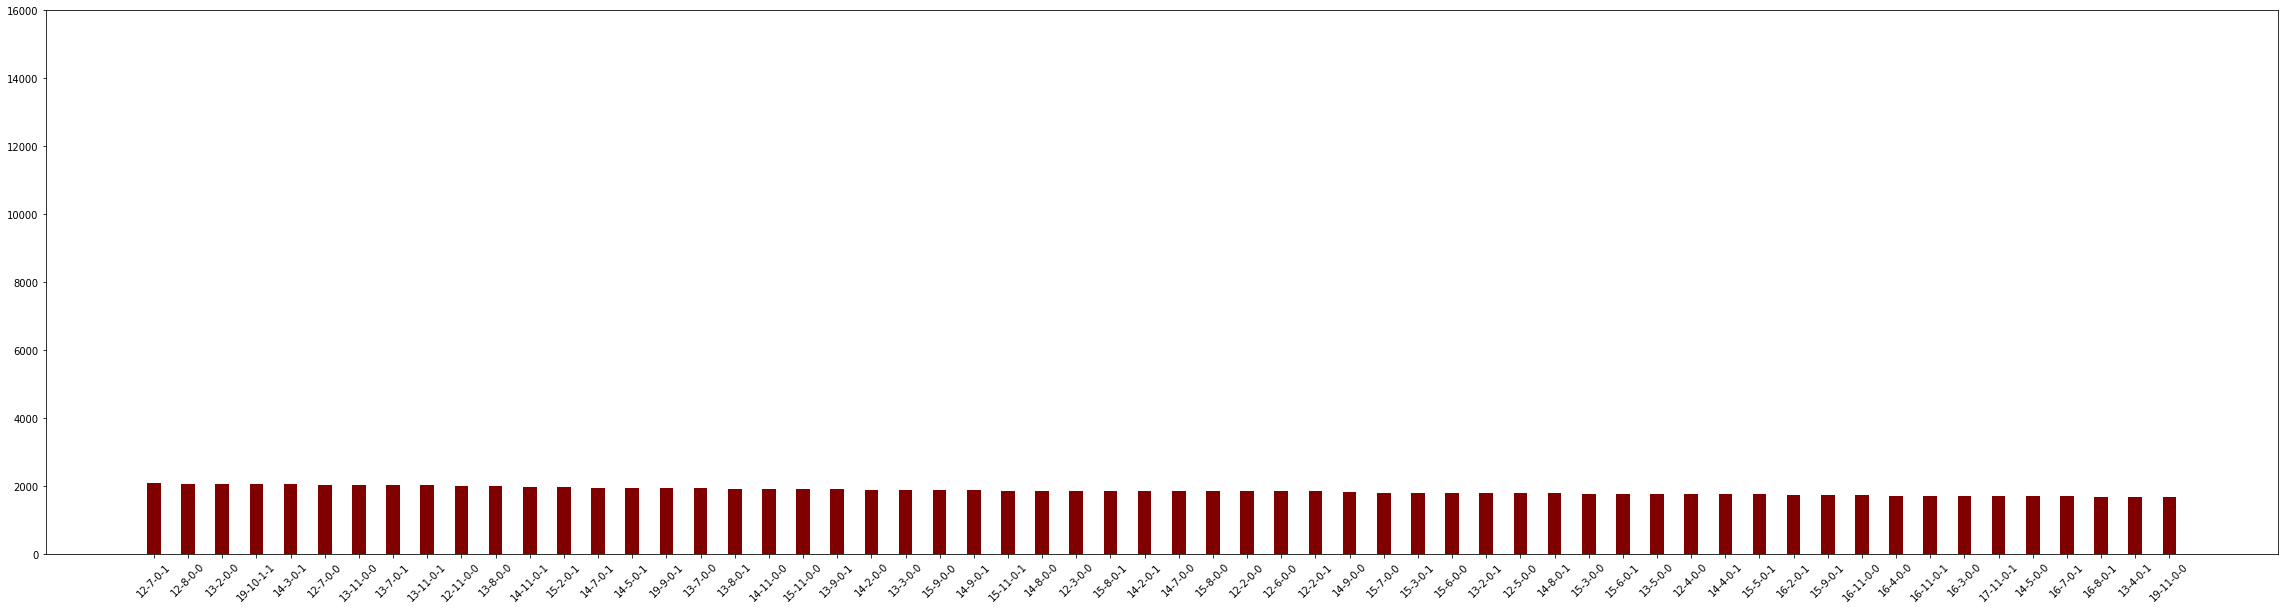

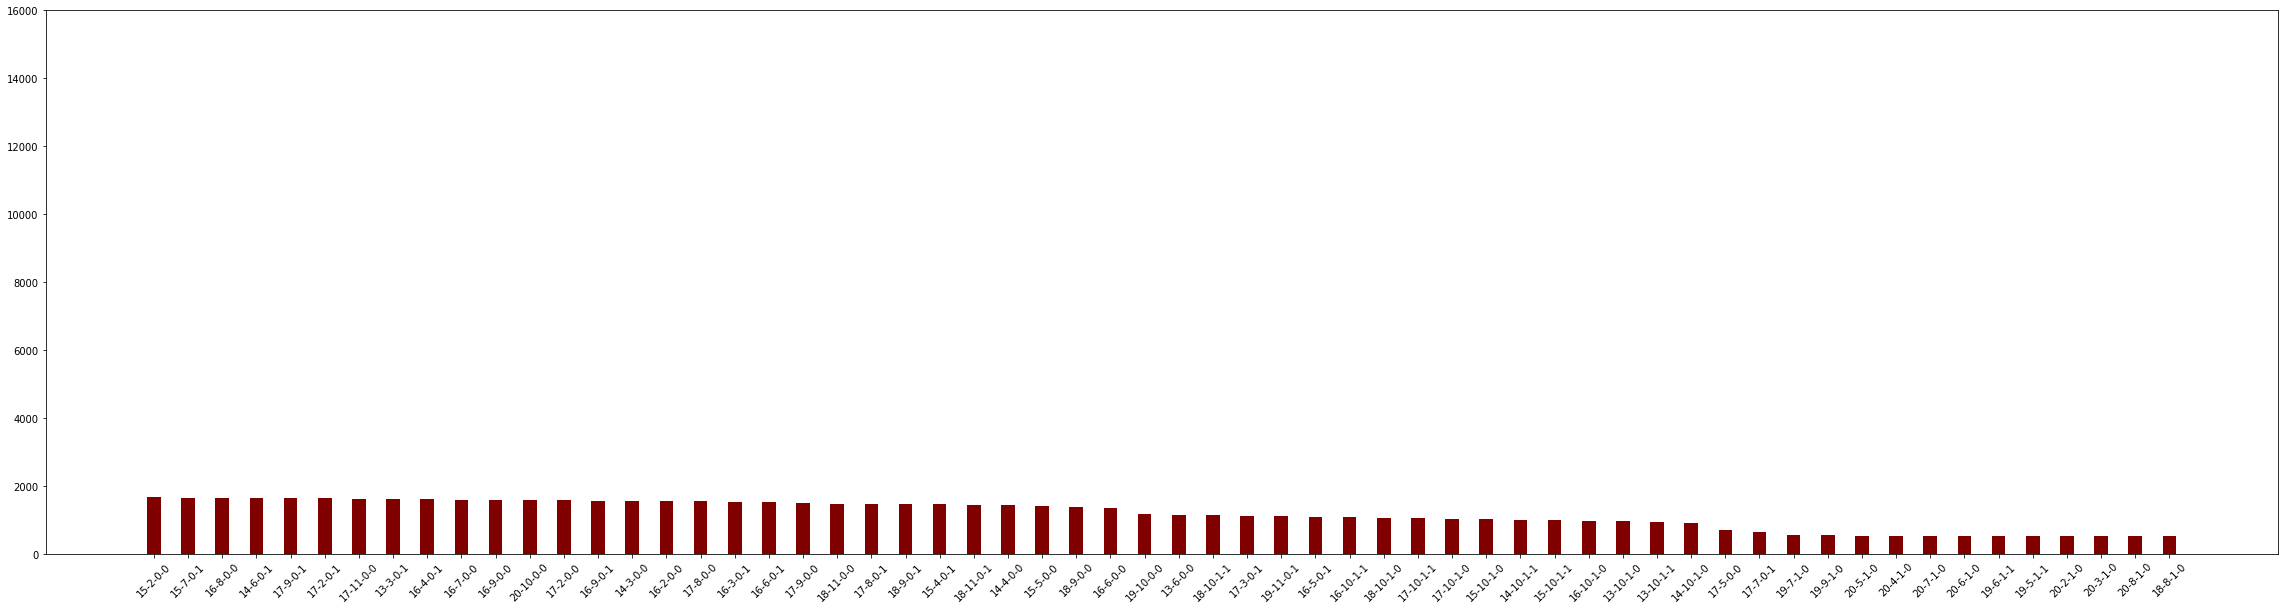

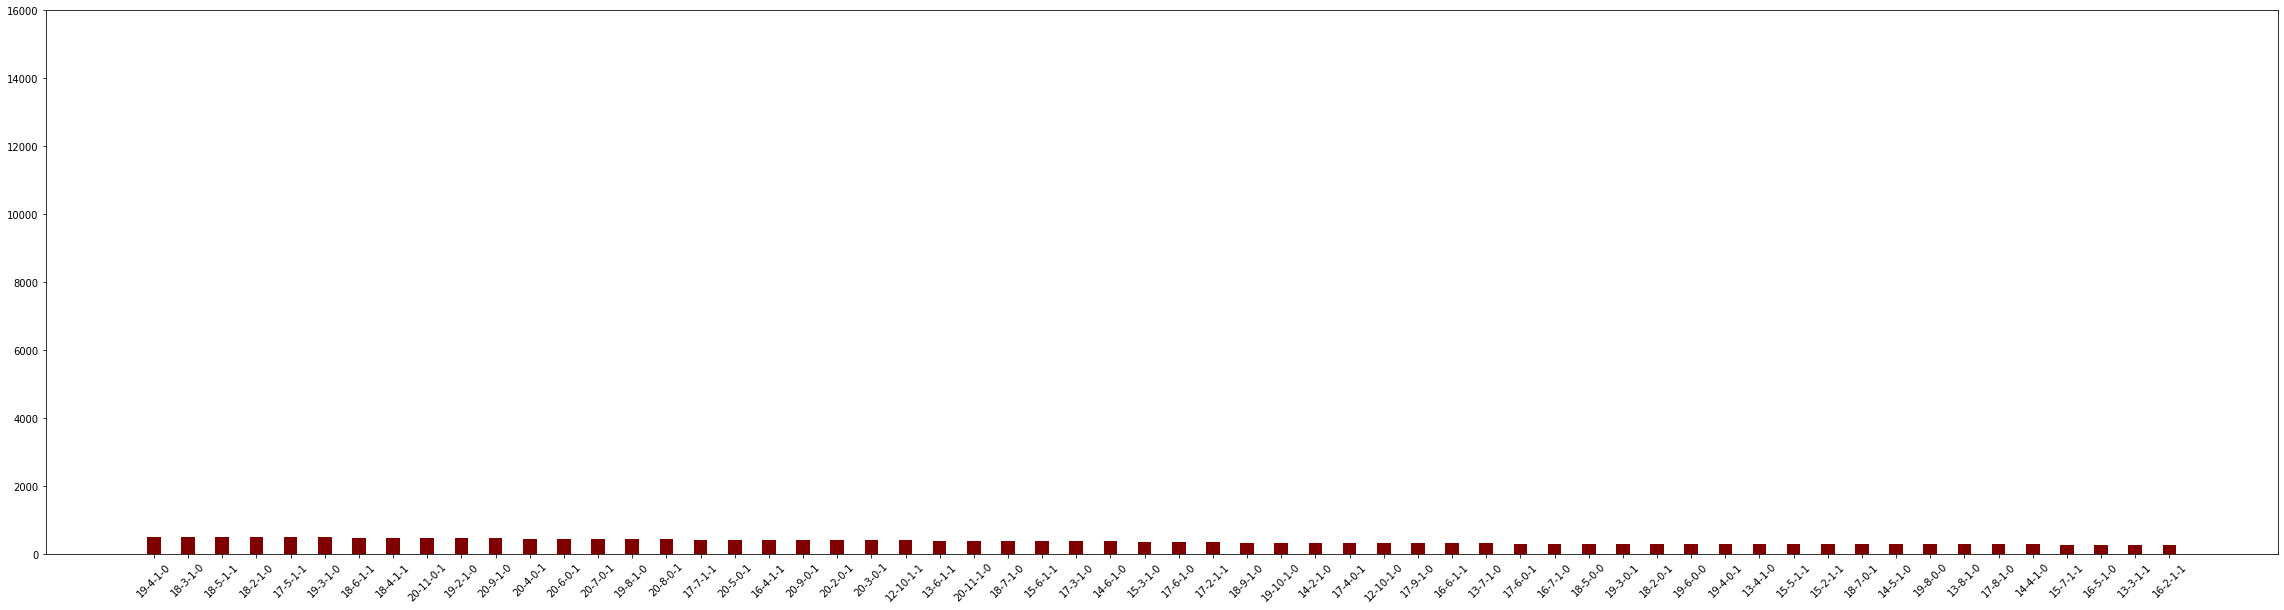

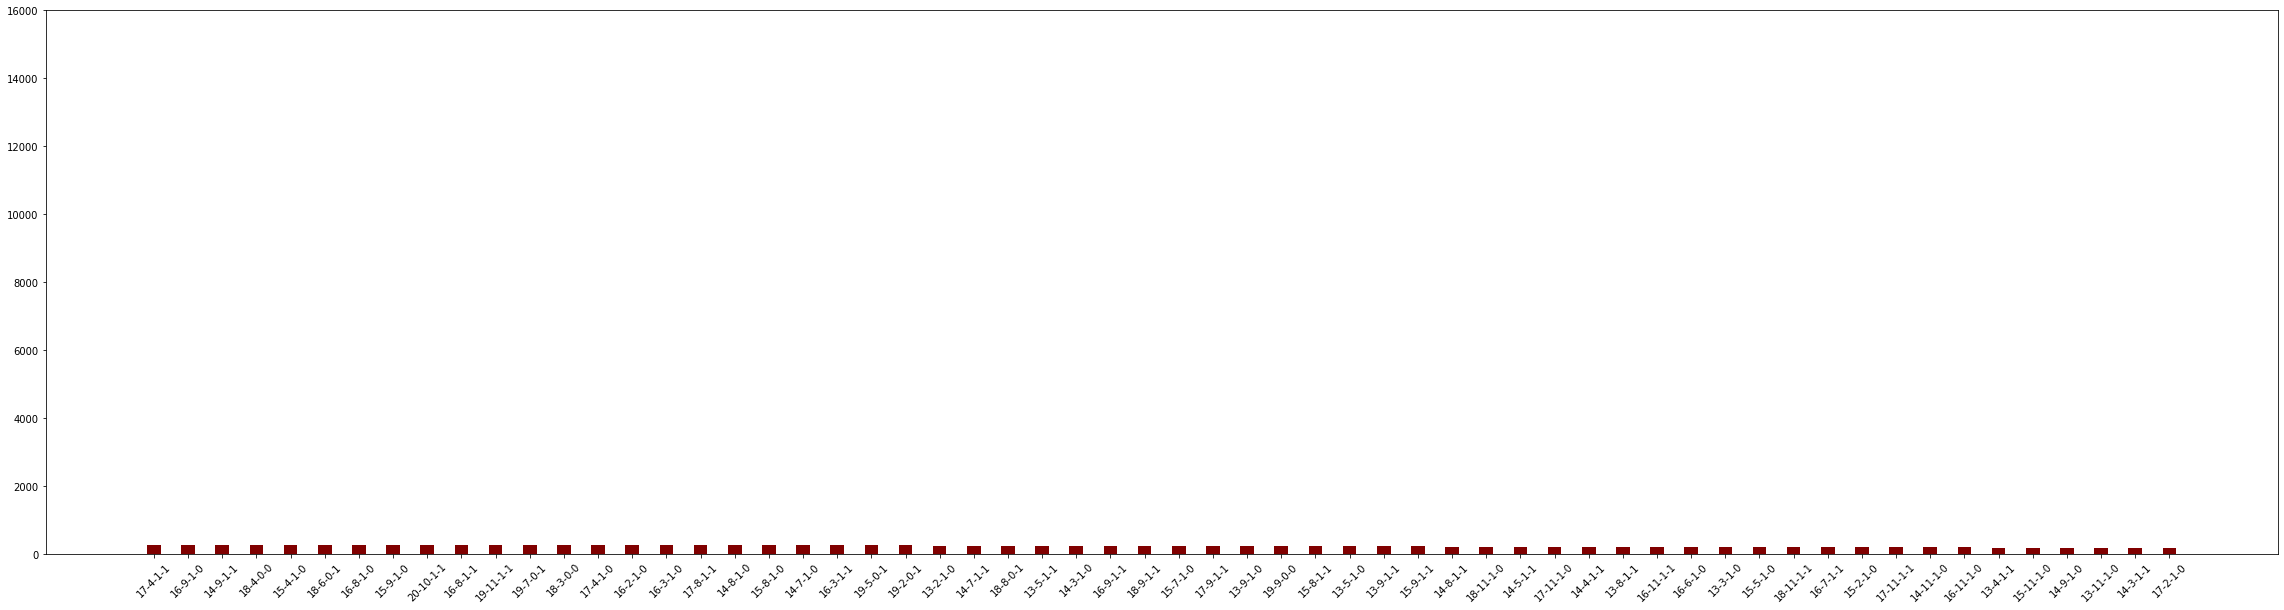

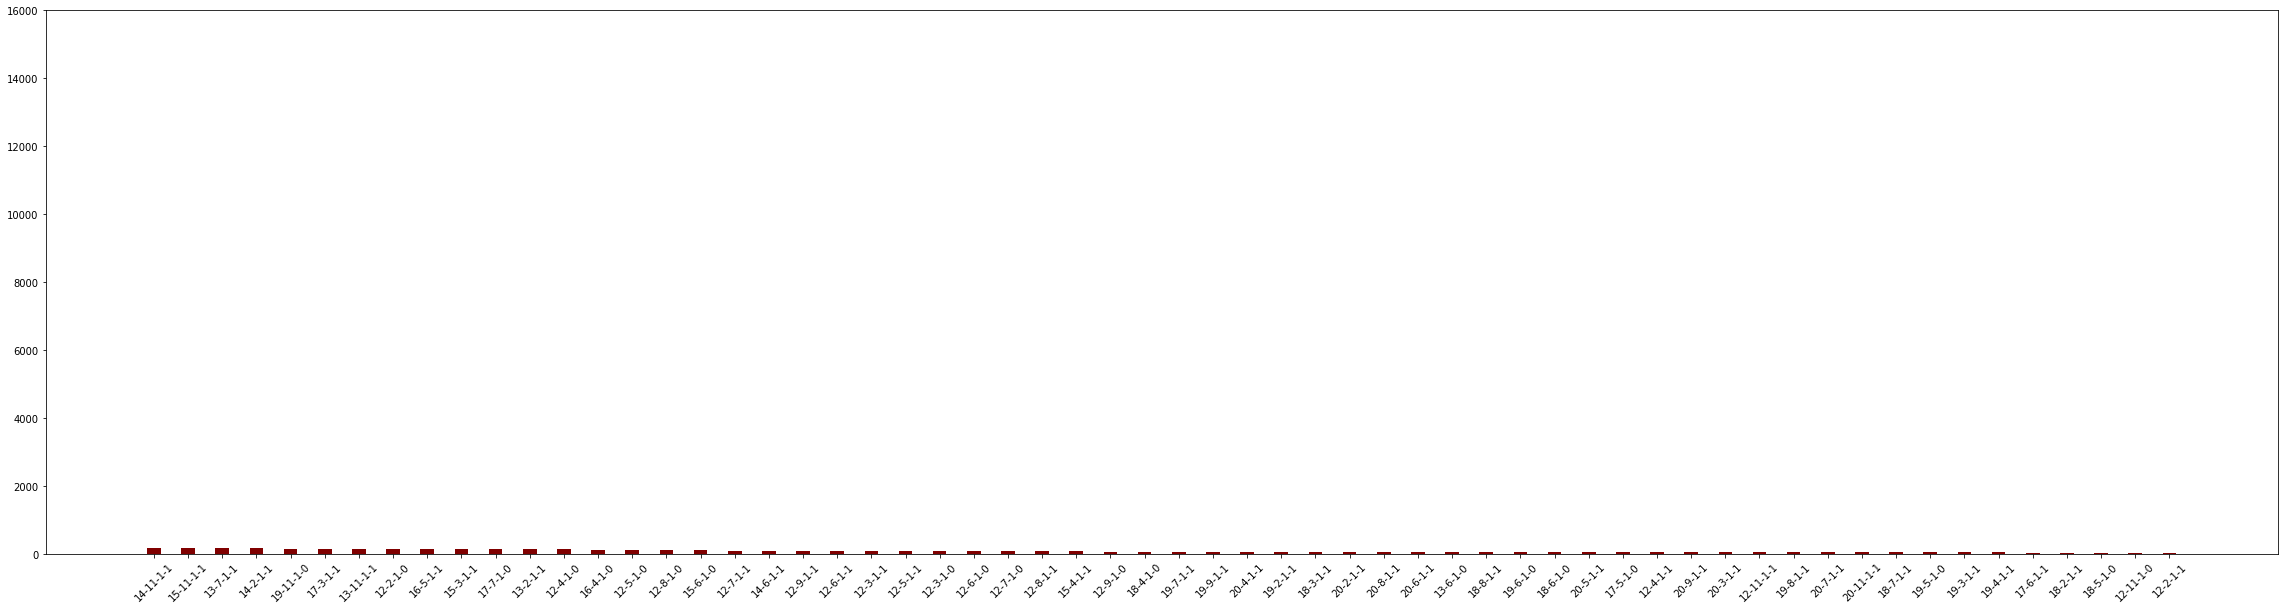

In [22]:
plotQACounts(sarsaE1)

Sarsa with $ ε = 1/k $

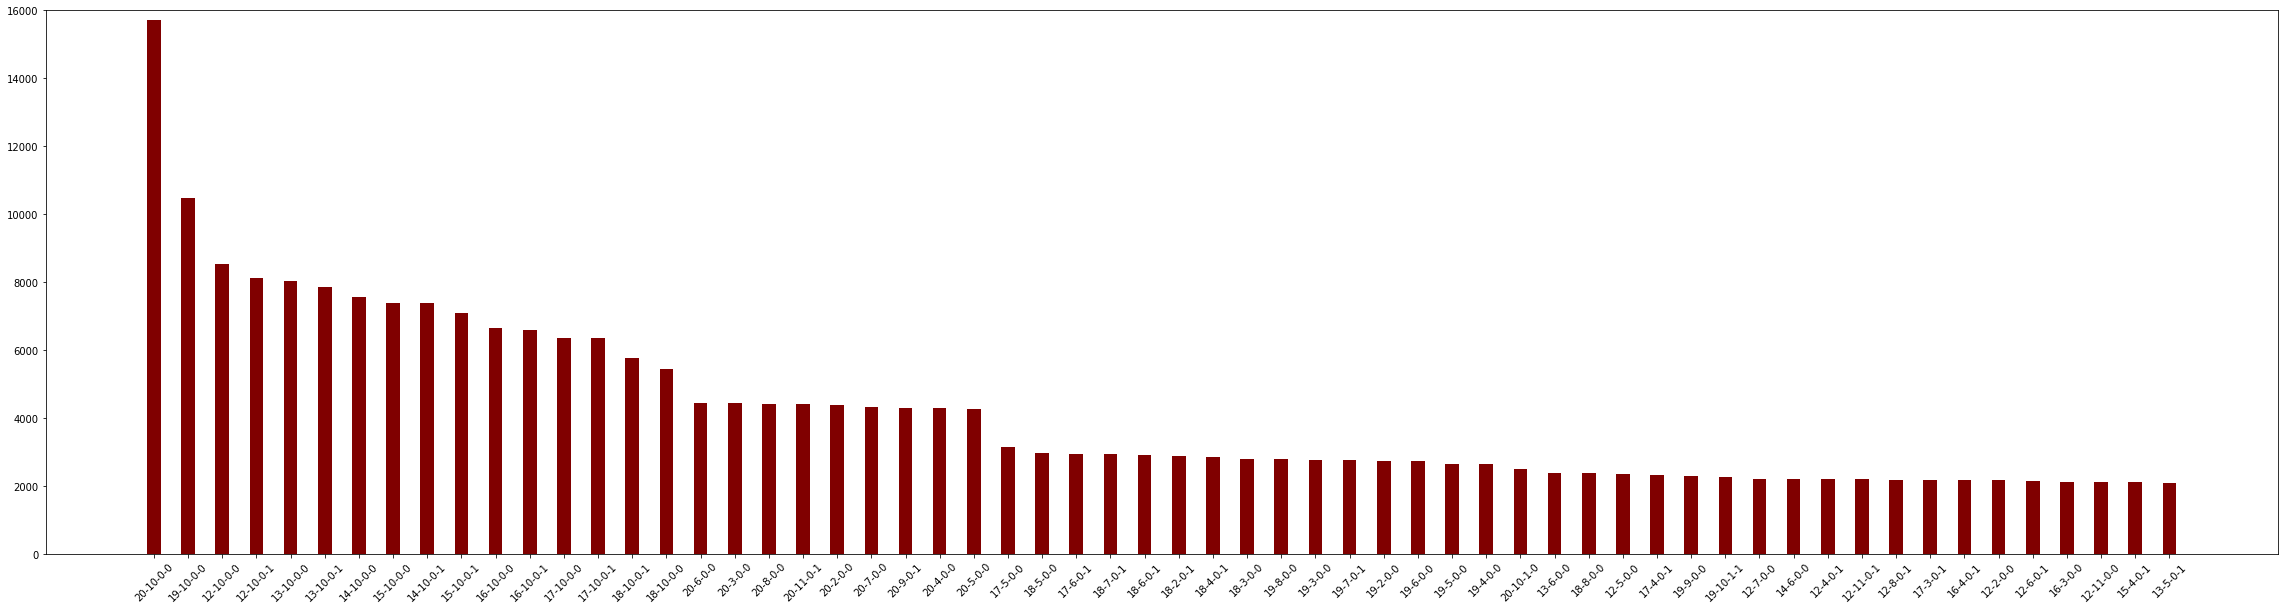

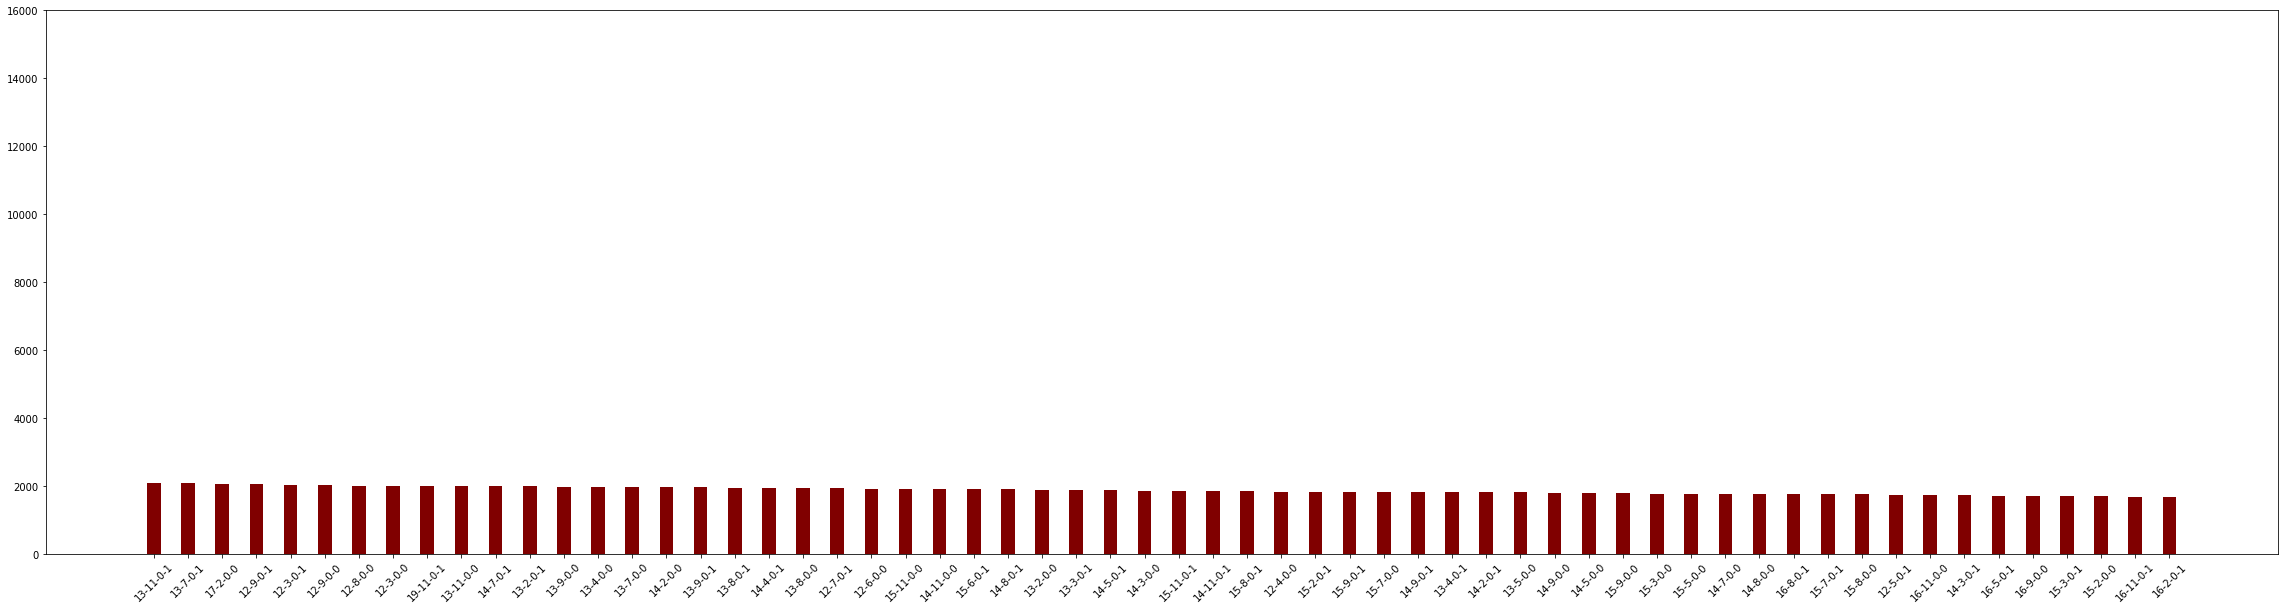

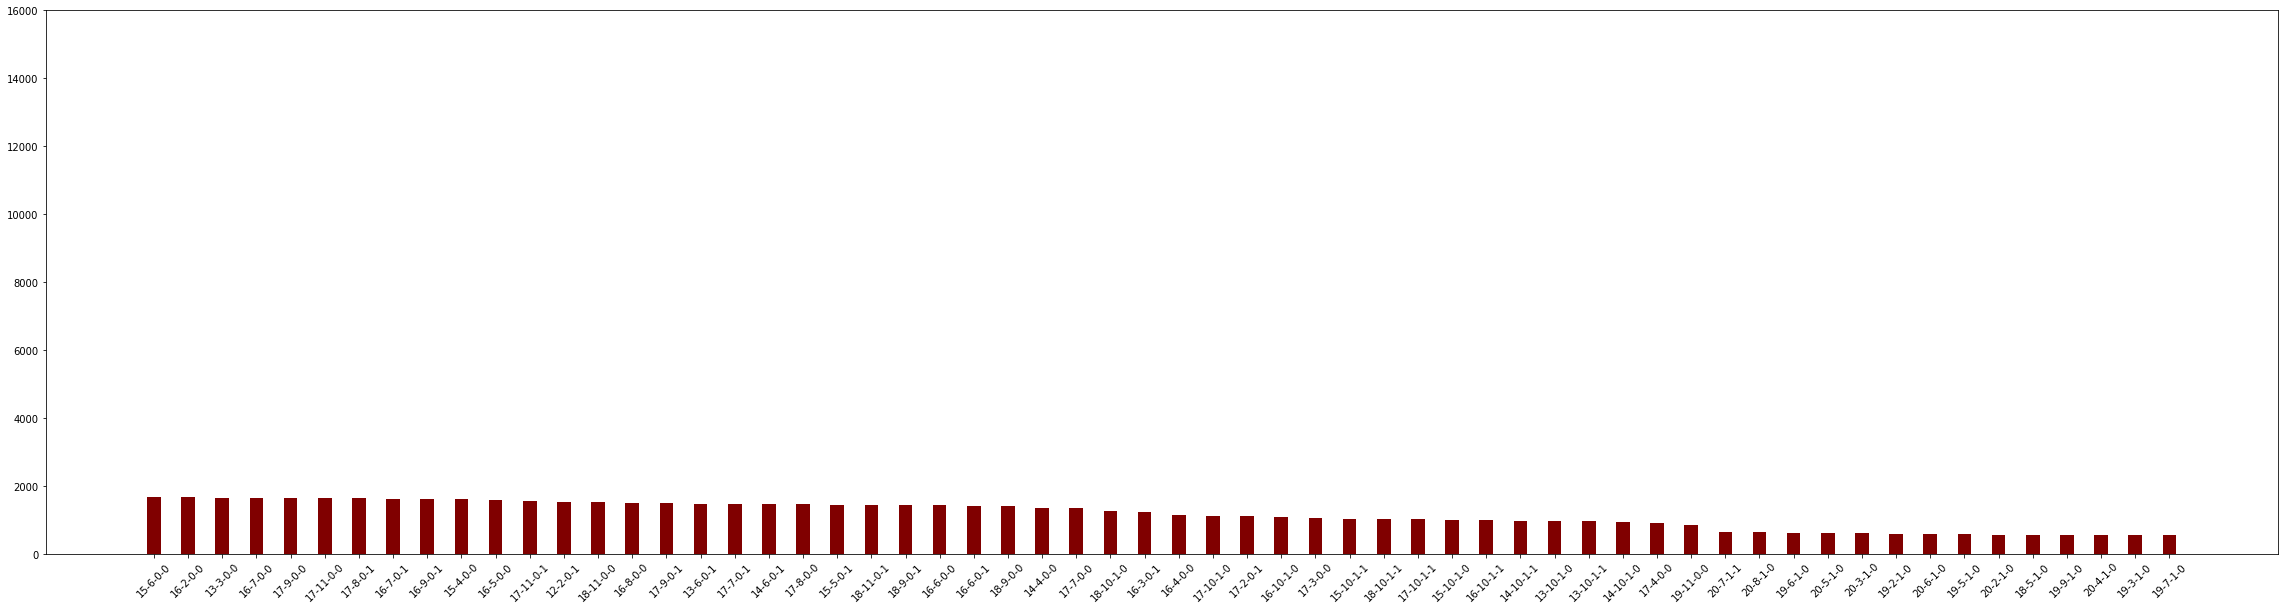

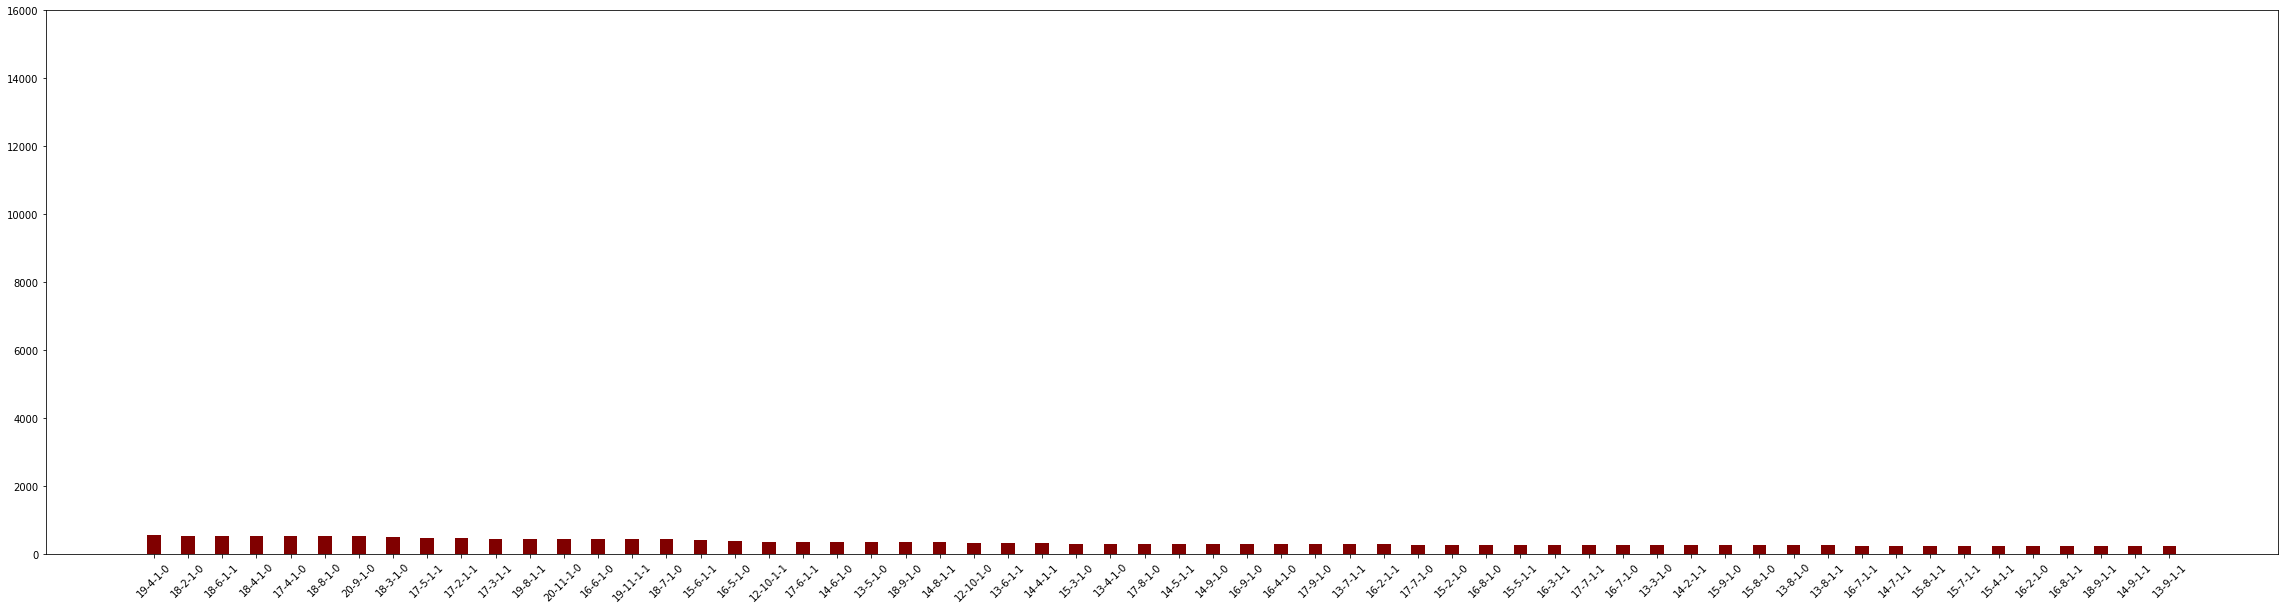

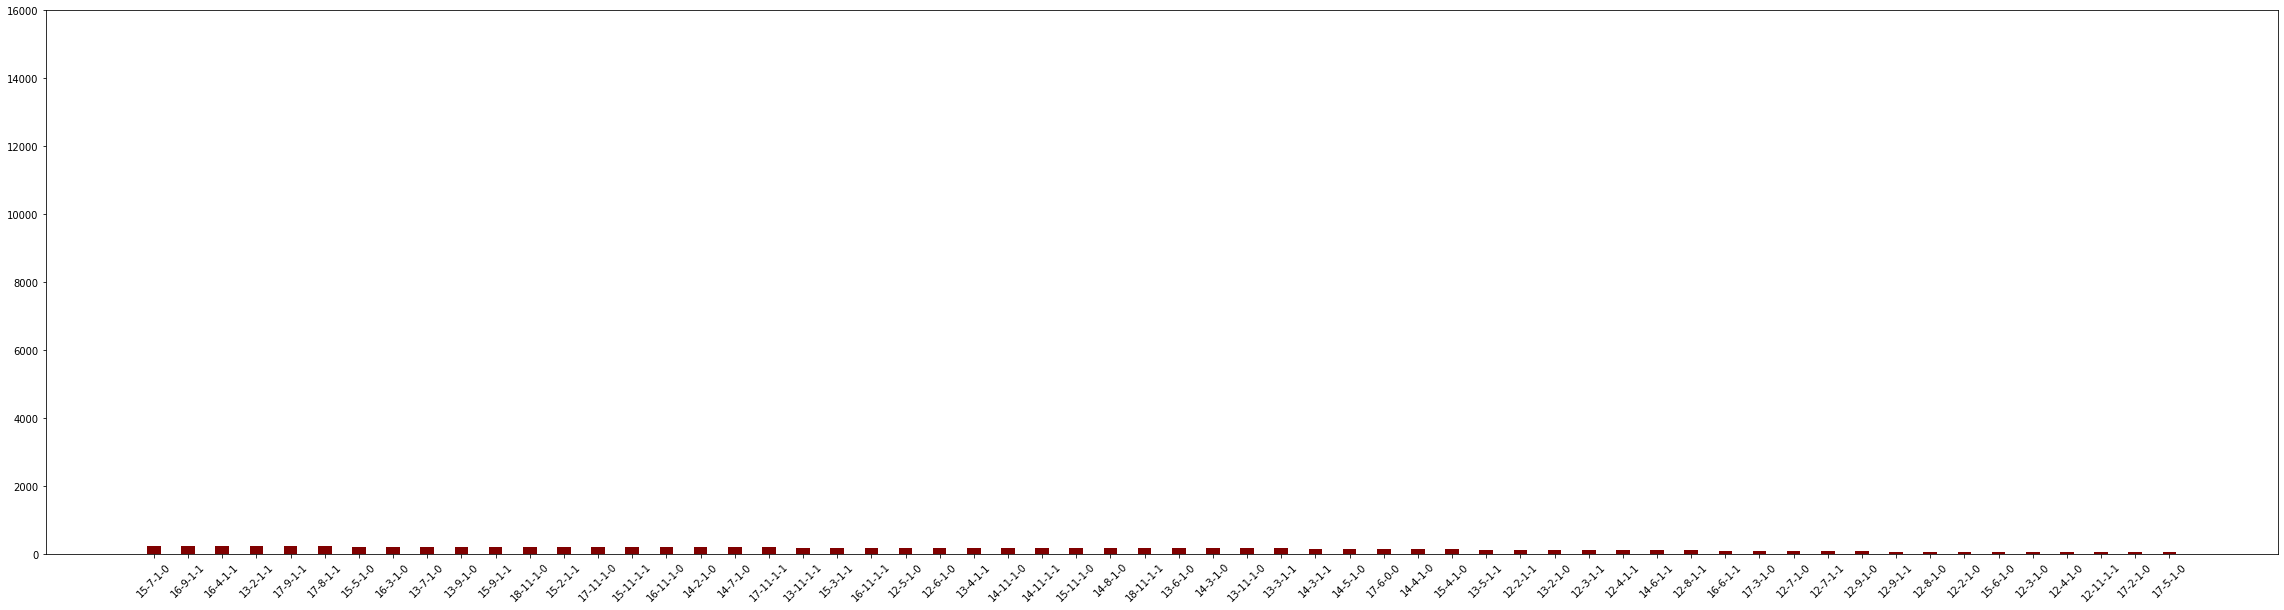

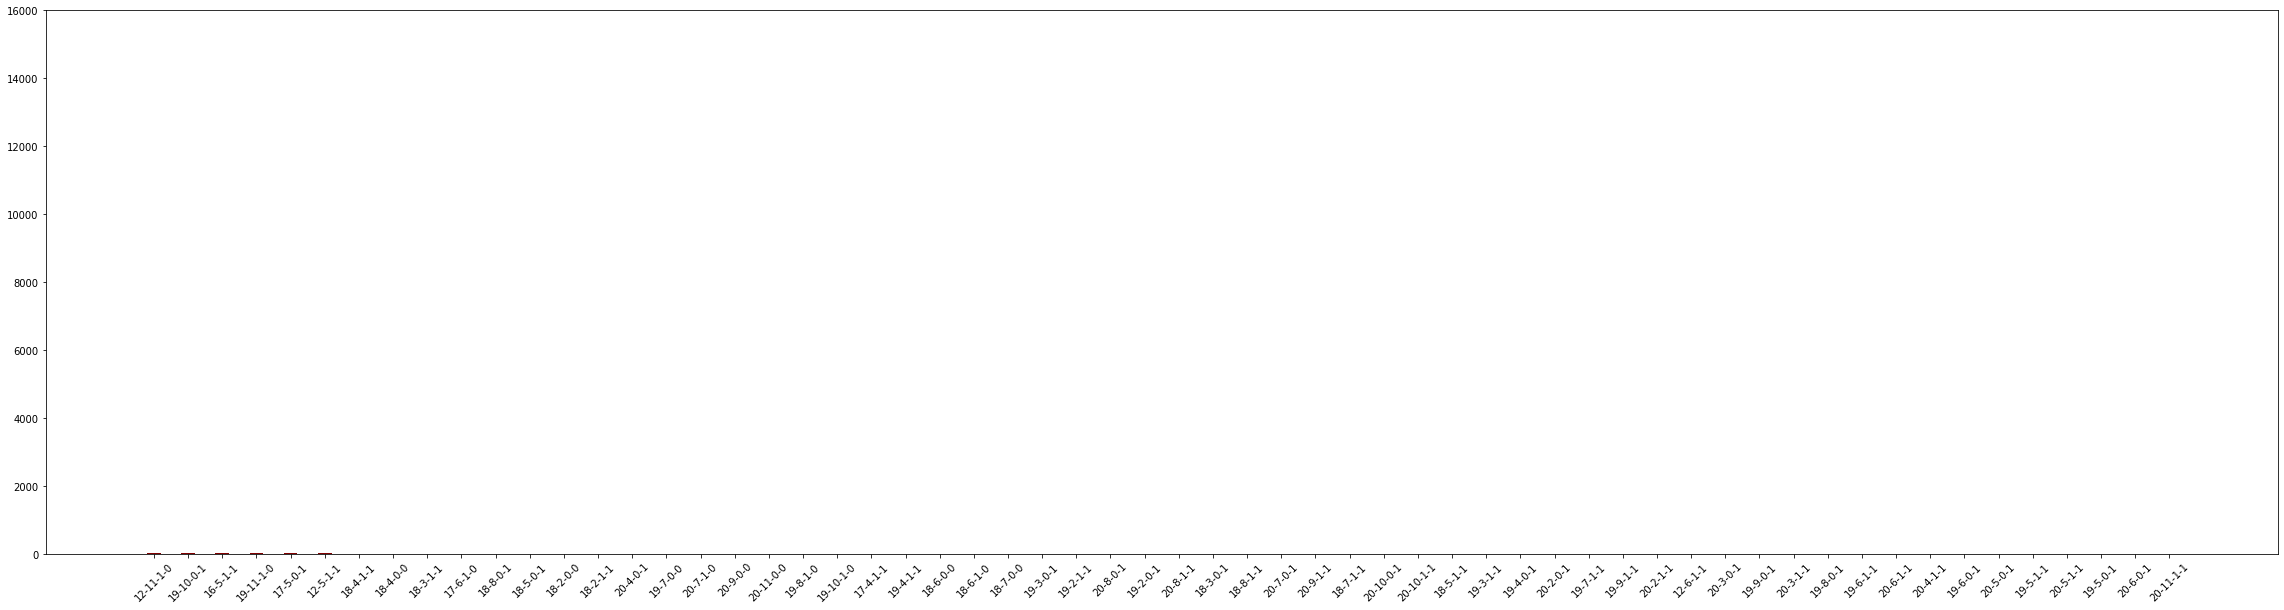

In [23]:
plotQACounts(sarsaE2)

Sarsa with $ ε = e^-k/1000 $

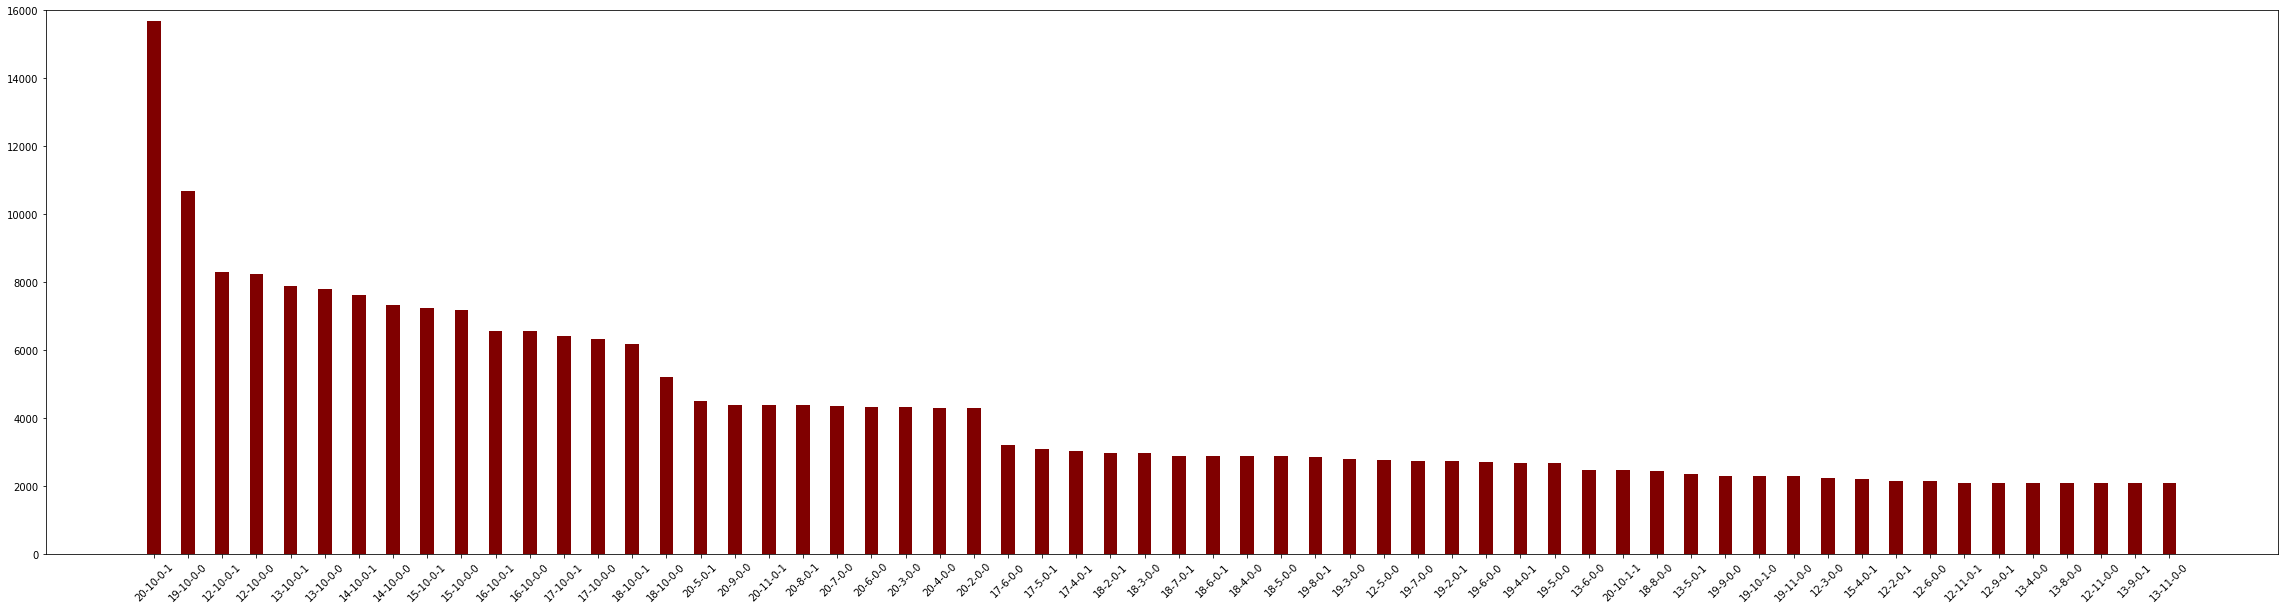

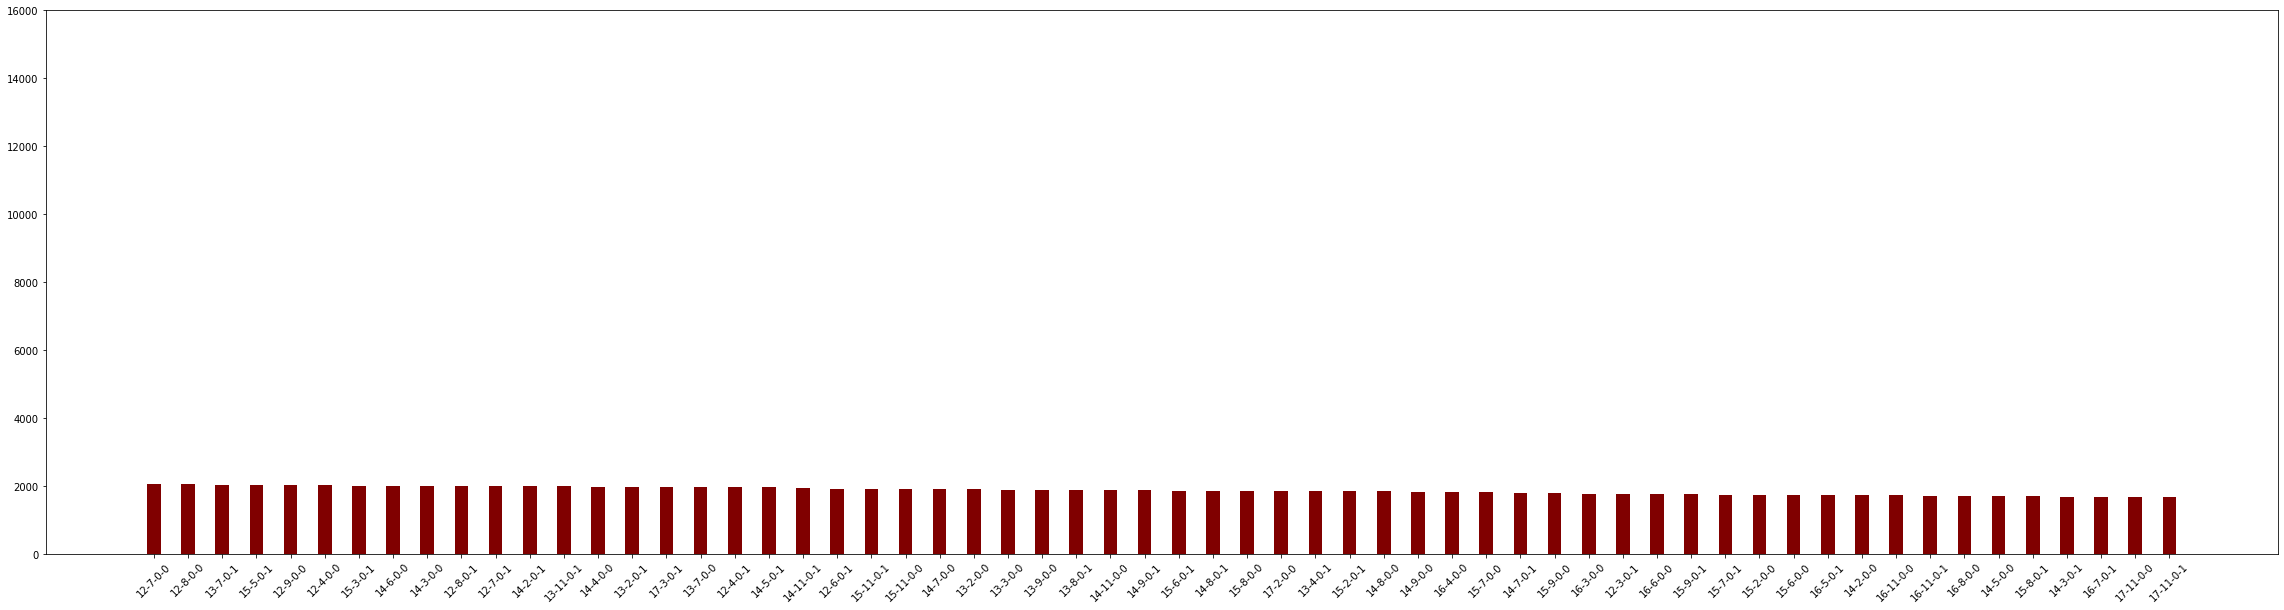

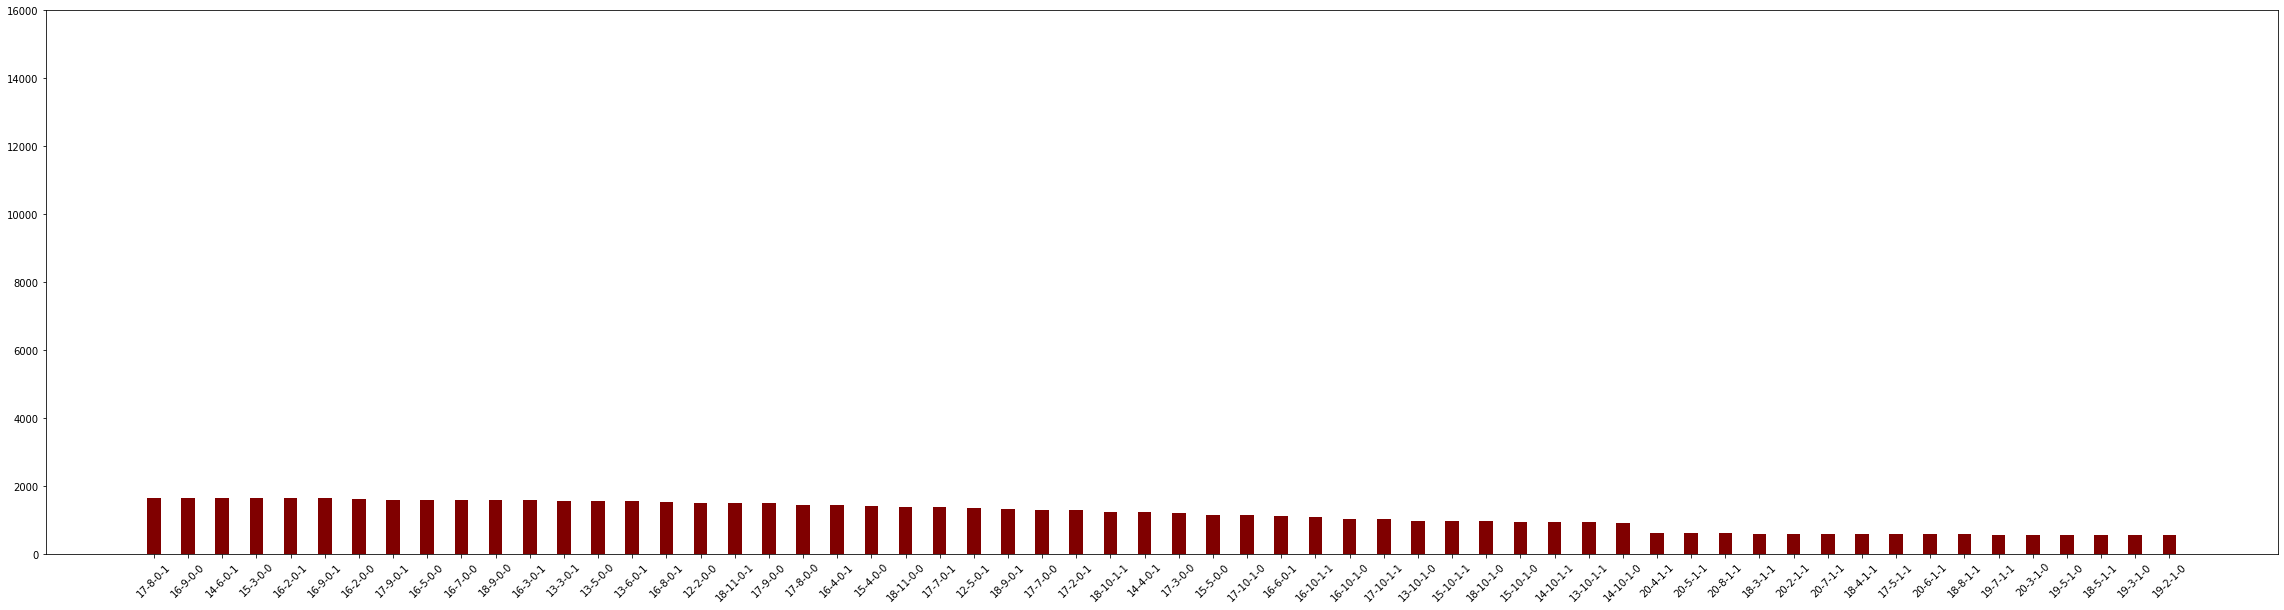

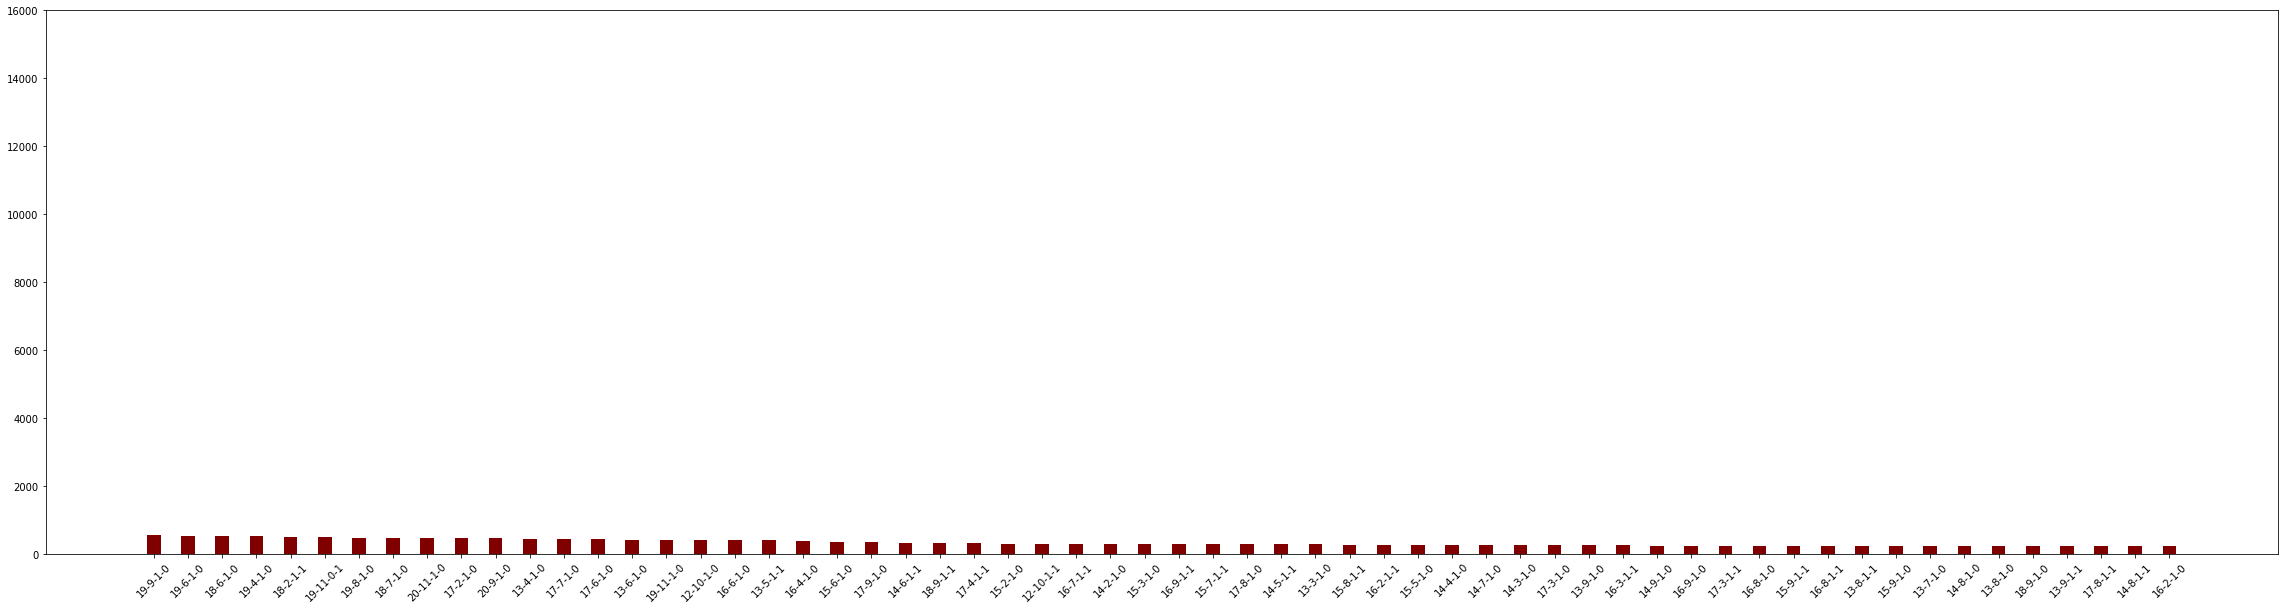

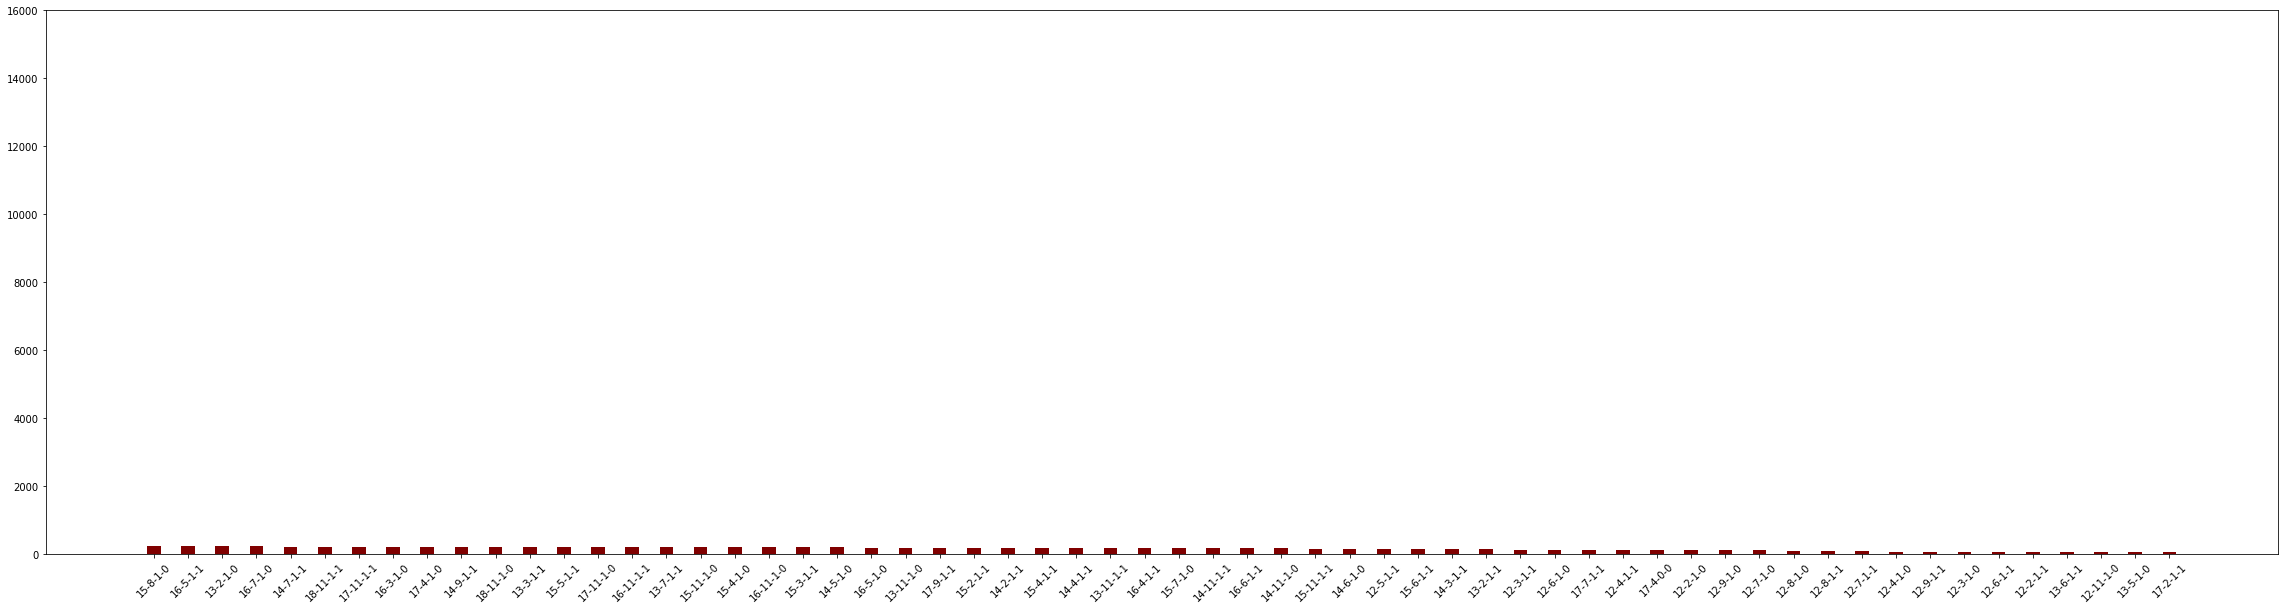

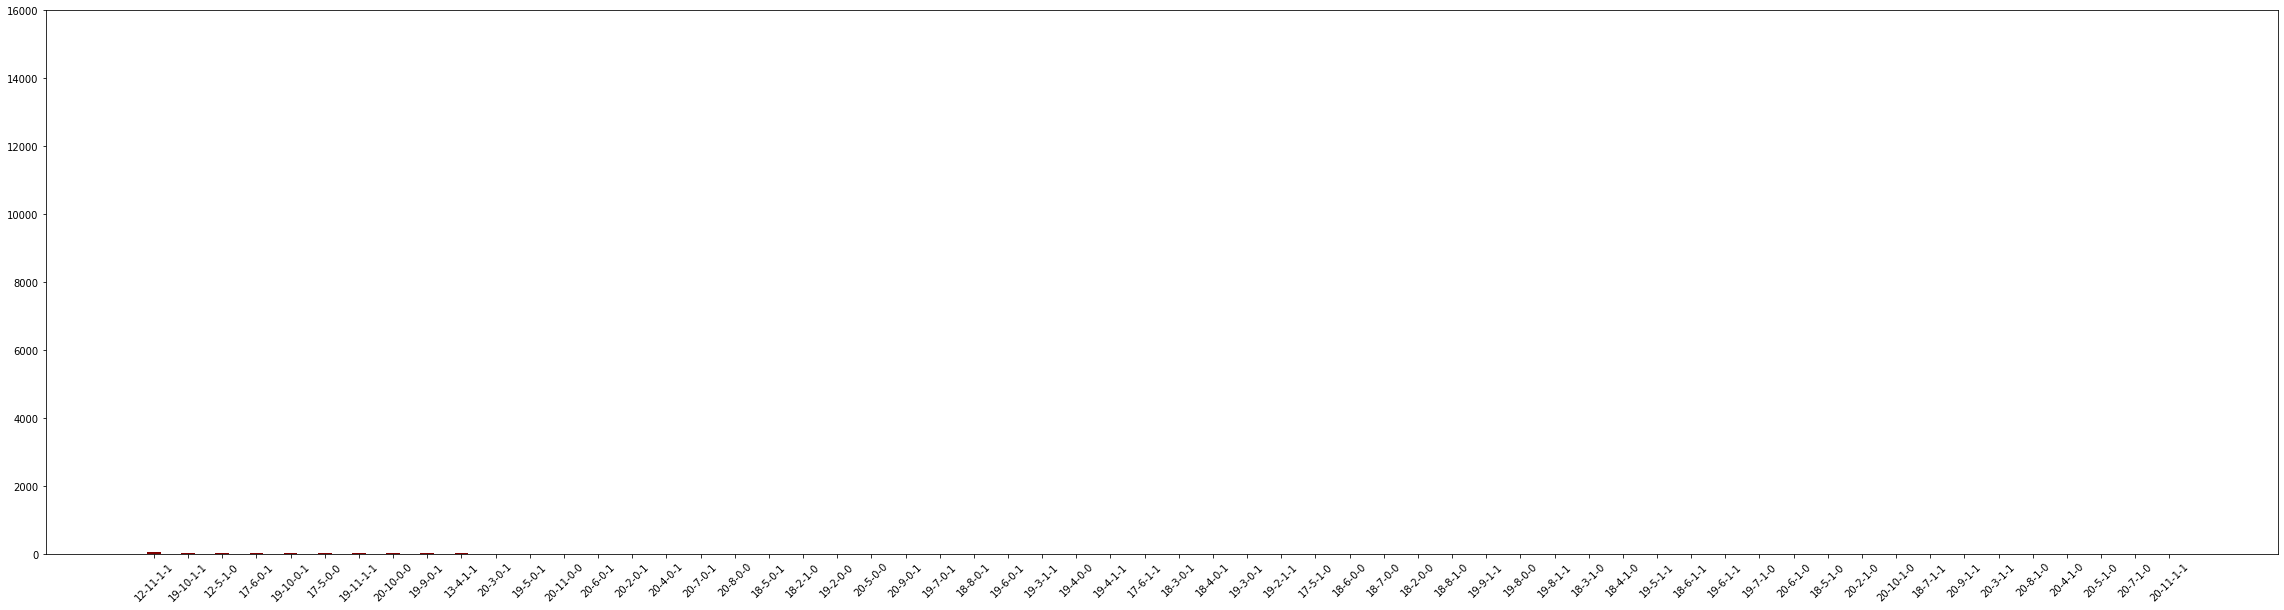

In [24]:
plotQACounts(sarsaE3)

Sarsa with $ ε = e -k/1000 $

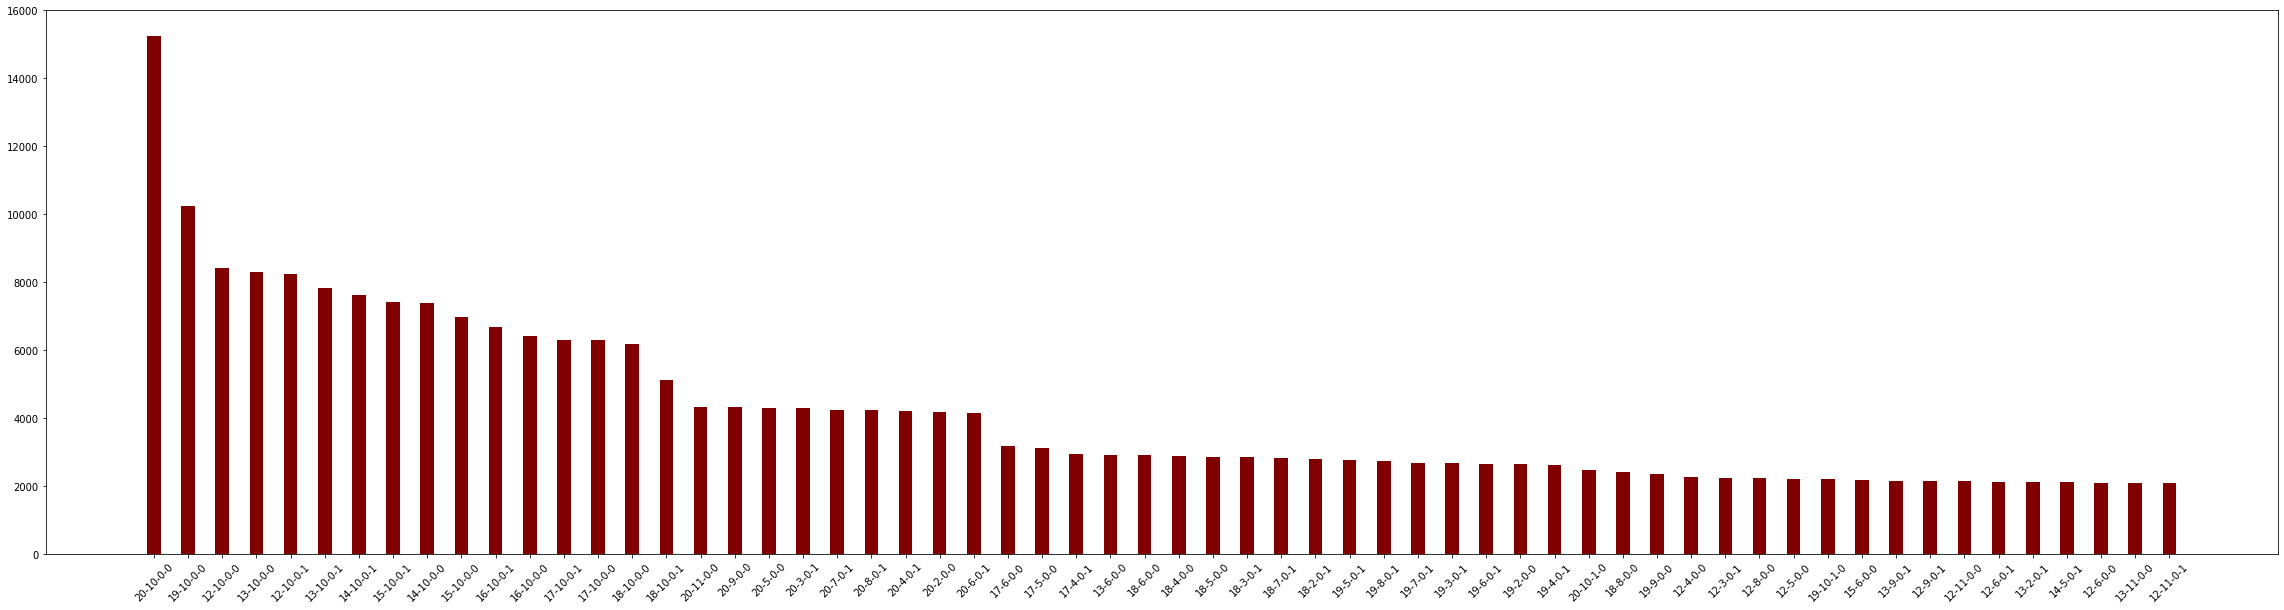

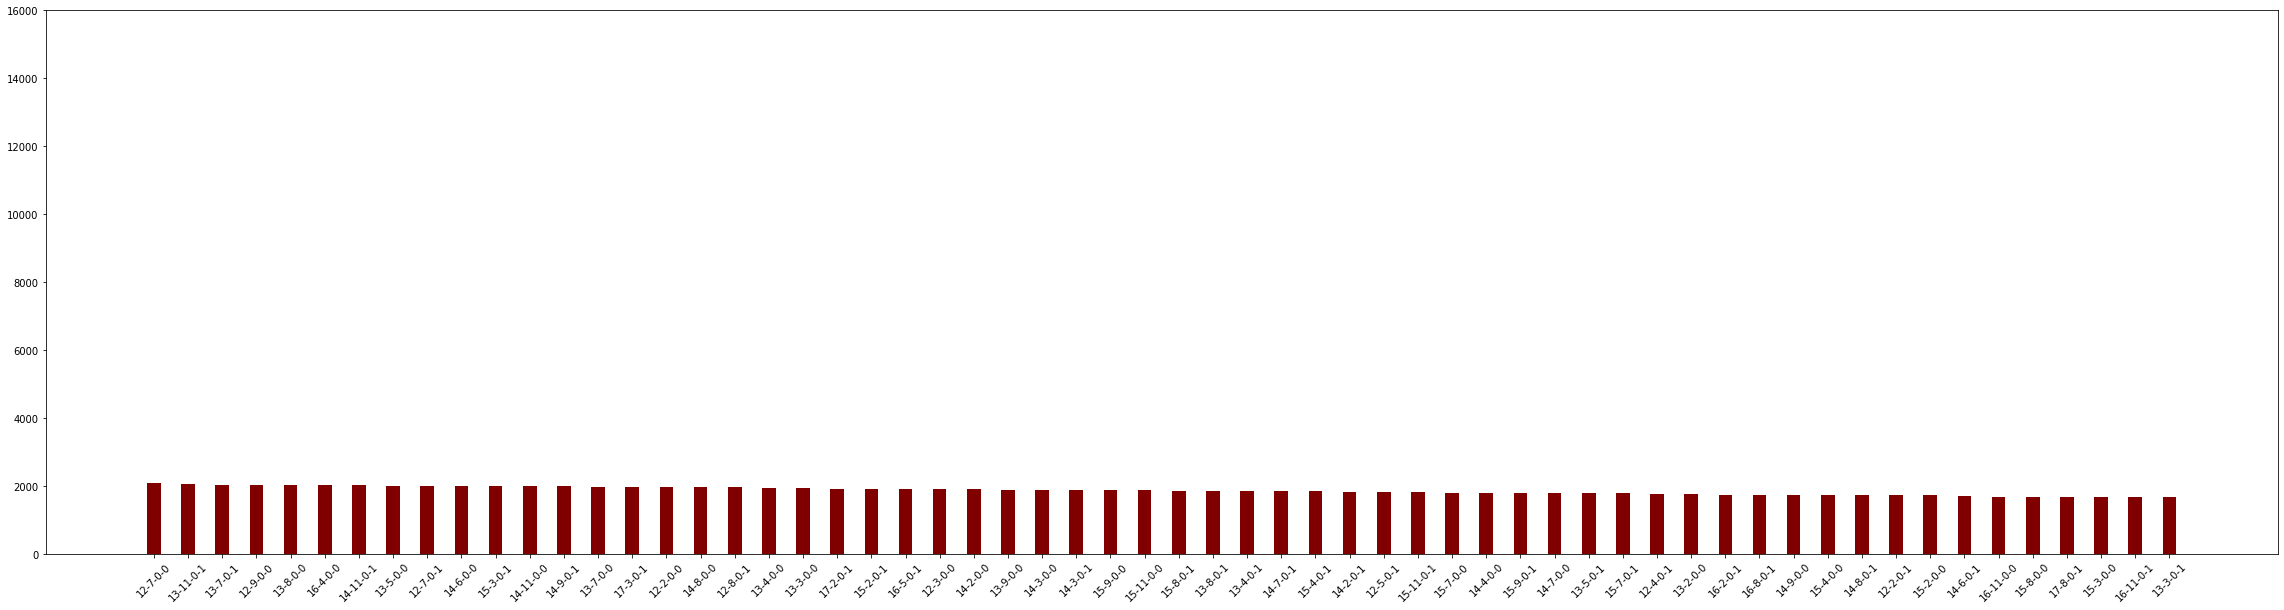

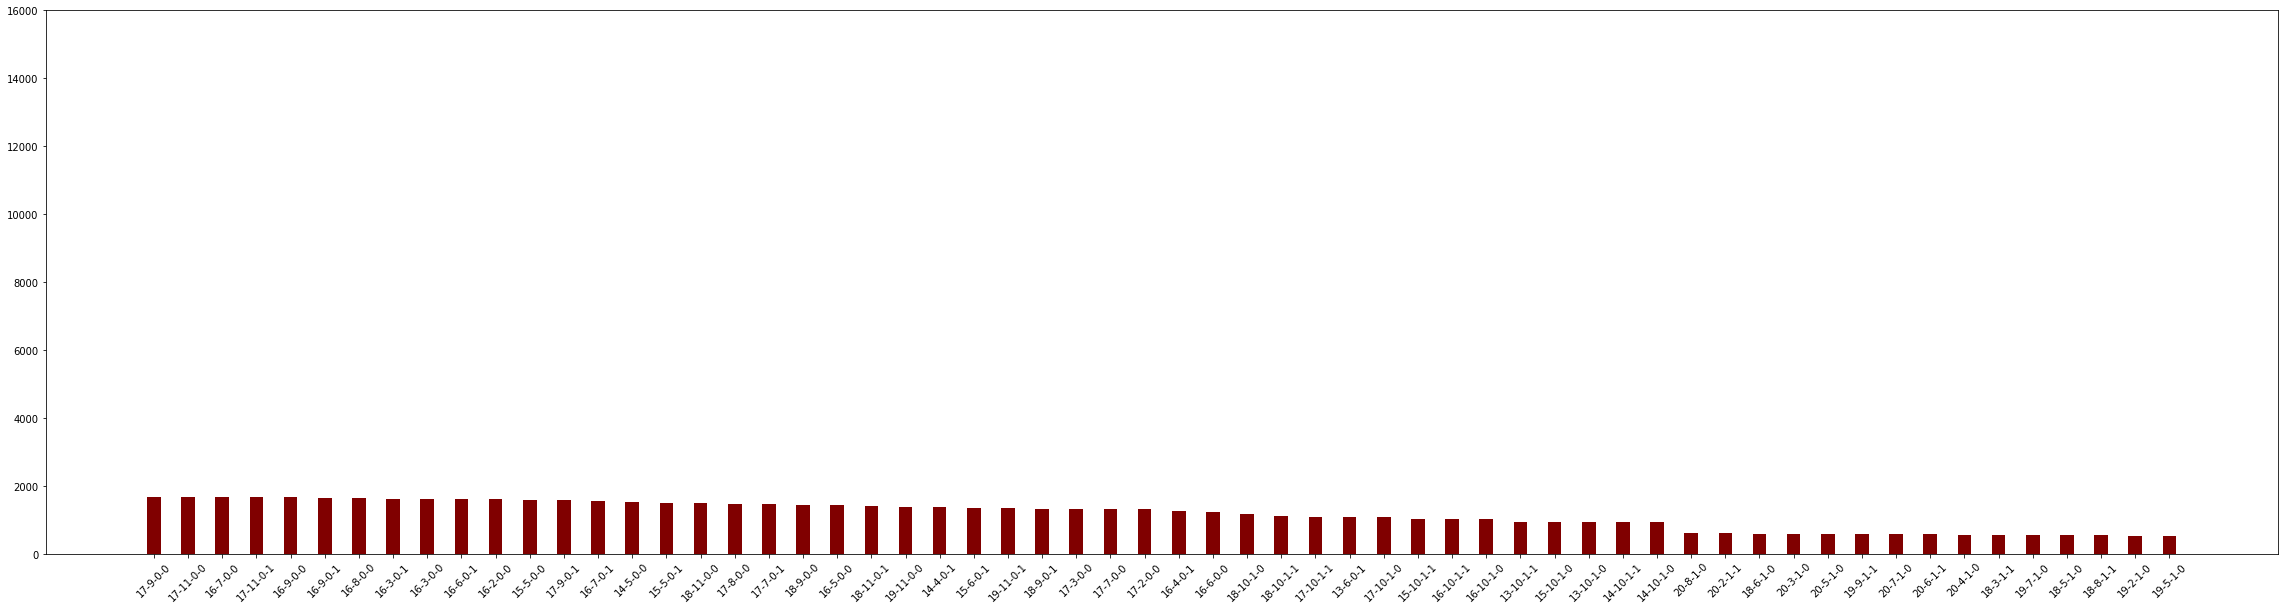

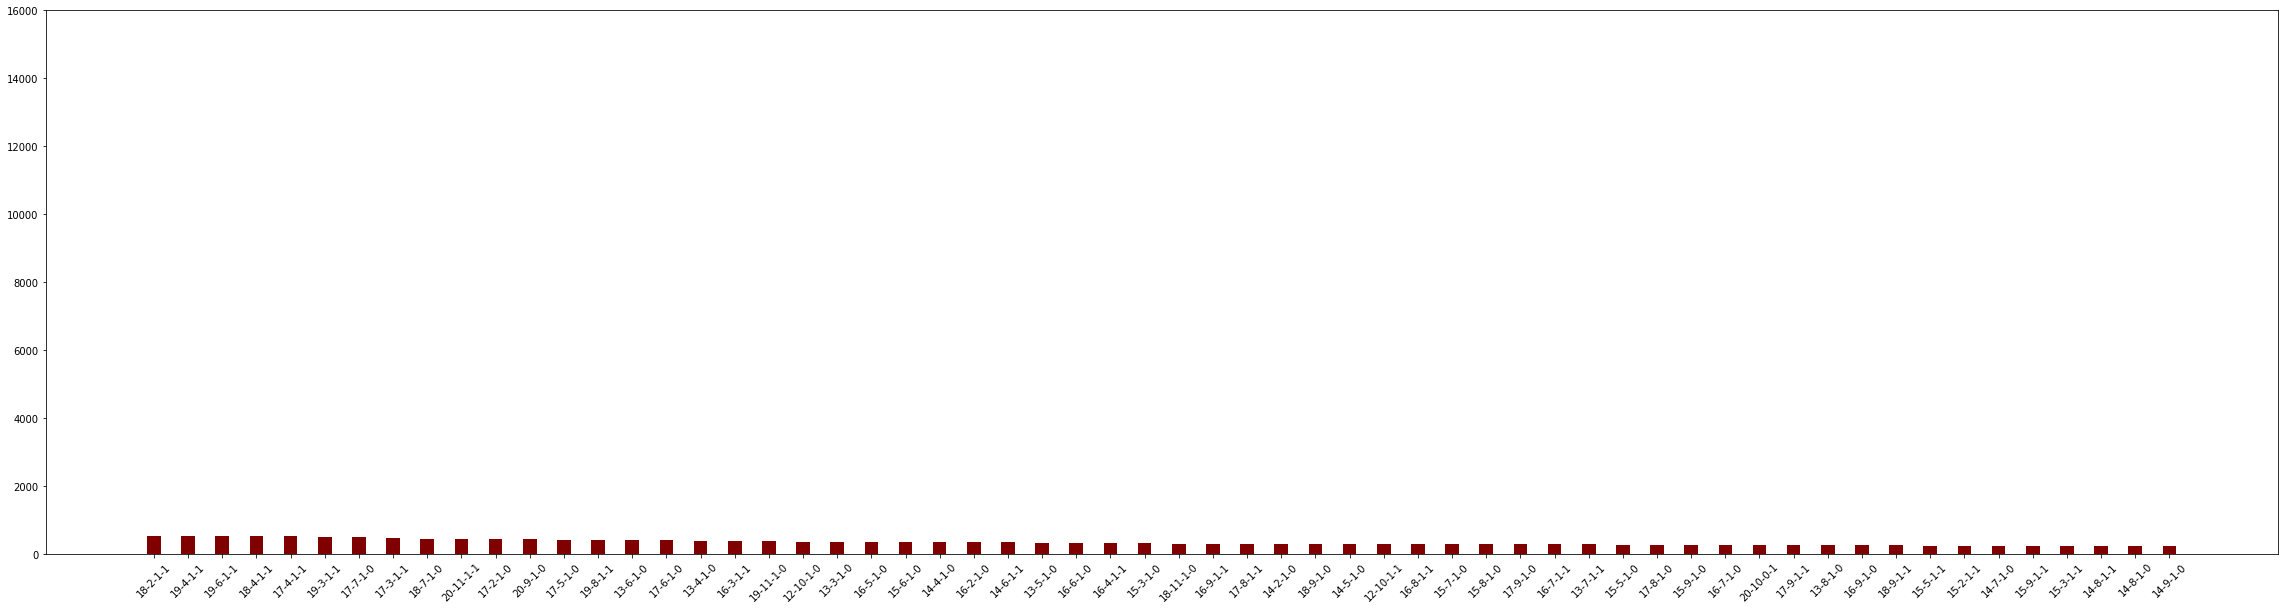

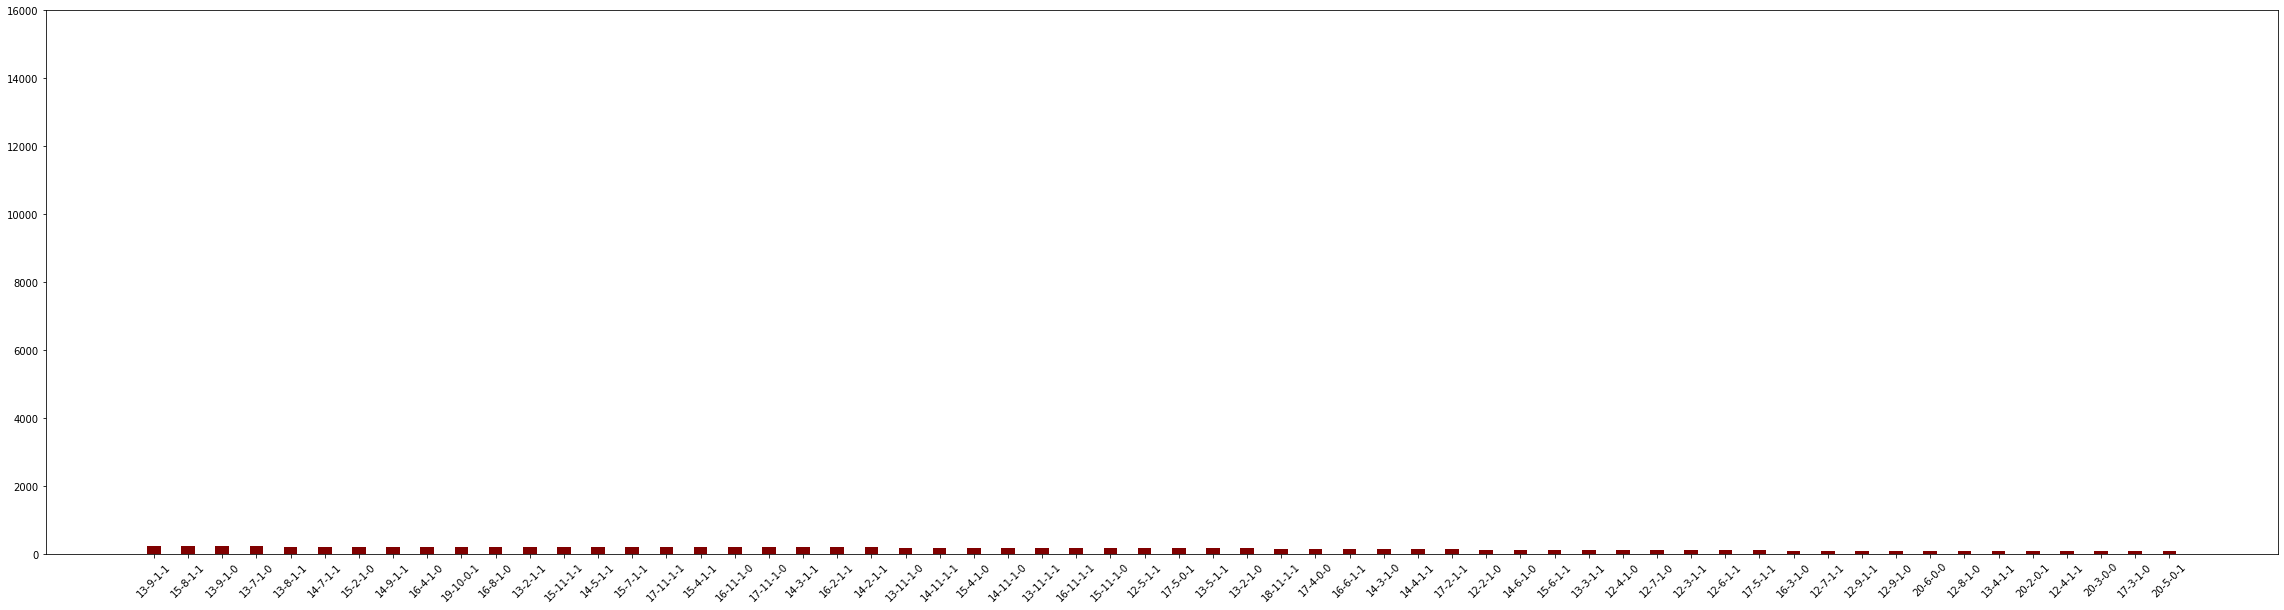

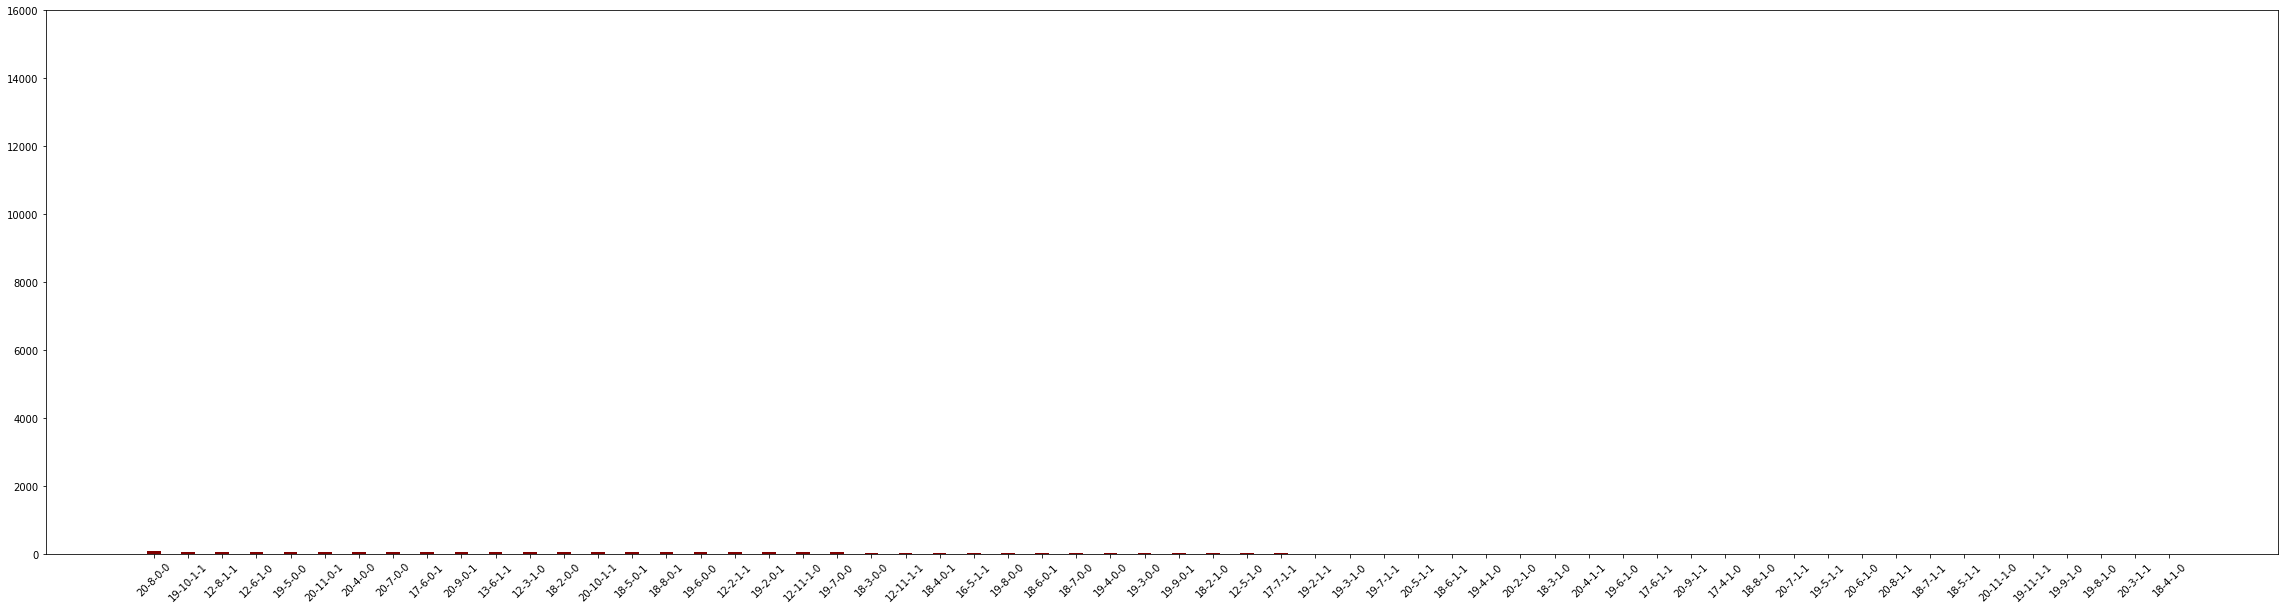

In [25]:
plotQACounts(sarsaE4)

#### Unique state-action pairs for different epsilon values

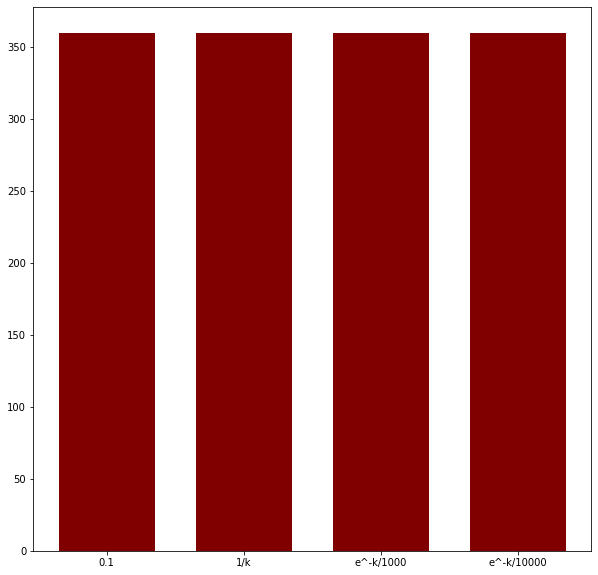

In [68]:
plotHist([sarsaE1, sarsaE2, sarsaE3, sarsaE4], ["0.1", "1/k", "e^-k/1000","e^-k/10000"])

#### Strategy tables for sarsa algorithm 

Sarsa with: $ ε = 0.1 $

In [27]:
print("With No Aces: ")
printStratTable(sarsaE1, 0)
print("\nWith Aces: ")
printStratTable(sarsaE1, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    S    H    H    H    H    S    S    S     S
 13  H    H    S    H    S    S    H    S    H     H
 14  S    H    H    H    S    H    H    S    S     S
 15  H    S    H    H    S    S    H    H    H     H
 16  H    H    S    S    S    S    H    H    S     H
 17  H    H    S    H    S    S    S    S    S     S
 18  S    H    H    H    S    S    S    S    S     H
 19  S    S    S    S    H    S    H    H    H     S
 20  S    S    S    S    S    S    S    S    H     S

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    S    S    S    H    S    H    S    S     S
 13  H    H    H    H    S    H    H    H    S     H
 14  H    H    H    S    S    H    S    H    S     S
 15  H    S    H    S    H    S    S    S    S     S
 16  H    S    H    S    H    H    S    S    S     H
 17  S    

Sarsa with $ ε = 1/k $

In [28]:
print("With No Aces: ")
printStratTable(sarsaE2, 0)
print("\nWith Aces: ")
printStratTable(sarsaE2, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    H    H    H    S    H    H    S    S     S
 13  H    H    S    H    S    H    H    H    S     S
 14  H    H    H    S    H    S    H    H    H     H
 15  H    S    S    S    S    H    S    S    S     S
 16  H    H    S    H    S    H    S    S    H     H
 17  S    H    H    S    H    H    S    S    S     S
 18  H    S    H    S    H    H    S    S    S     H
 19  S    S    S    S    S    H    S    S    S     H
 20  S    S    S    S    S    S    S    H    S     H

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    H    H    S    S    S    H    H    S     H
 13  H    H    H    S    H    H    S    H    H     S
 14  H    S    H    H    S    S    S    S    H     S
 15  S    H    S    H    H    H    H    S    S     H
 16  H    S    H    S    S    S    H    S    H     S
 17  S    

Sarsa with $ ε = e^-k/1000 $

In [29]:
print("With No Aces: ")
printStratTable(sarsaE3, 0)
print("\nWith Aces: ")
printStratTable(sarsaE3, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    S    S    H    S    S    S    H    S     S
 13  S    H    H    H    S    S    S    S    H     H
 14  H    H    H    H    H    S    H    S    S     S
 15  H    S    S    S    S    H    H    H    S     S
 16  S    H    S    S    H    S    H    H    H     H
 17  S    H    H    H    S    H    S    H    H     S
 18  H    S    S    S    H    H    S    H    H     S
 19  H    S    H    S    S    S    H    S    S     S
 20  S    S    S    H    S    S    H    S    H     H

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    H    S    H    H    S    S    H    H     H
 13  H    H    S    H    S    H    H    S    H     S
 14  H    H    S    S    H    S    S    S    S     S
 15  S    S    H    S    H    H    S    S    H     S
 16  H    H    H    S    S    S    H    S    H     S
 17  S    

Sarsa with $ ε = e -k/1000 $

In [30]:
print("With No Aces: ")
printStratTable(sarsaE4, 0)
print("\nWith Aces: ")
printStratTable(sarsaE4, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    S    H    H    H    H    S    H    H     S
 13  H    H    S    S    S    H    S    S    H     S
 14  H    S    S    S    S    S    H    S    S     H
 15  H    H    H    H    H    H    H    S    H     H
 16  S    S    H    S    H    H    S    H    S     H
 17  S    H    H    S    S    S    S    S    H     H
 18  H    H    S    S    S    H    S    H    S     H
 19  S    H    H    H    H    H    H    S    S     H
 20  S    H    H    S    H    H    H    S    S     S

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    H    H    H    S    H    S    H    S     S
 13  H    S    H    S    S    S    S    H    S     H
 14  H    H    S    S    H    S    H    H    S     S
 15  H    H    H    S    H    S    H    H    S     H
 16  S    H    H    S    H    S    H    S    S     S
 17  S    

### SARSAMAX Algorithm

#### Training the algorithm

Training was done using 4 different values for epsilon 

In [31]:
sarsamaxE1 = SARSAMAX()
sarsamaxE2 = SARSAMAX()
sarsamaxE3 = SARSAMAX()
sarsamaxE4 = SARSAMAX()   


sarsamaxE1.training(numOfEps, E1)
sarsamaxE2.training(numOfEps, E2)
sarsamaxE3.training(numOfEps, E3)
sarsamaxE4.training(numOfEps, E4)

#### Wins - Draws - Losses

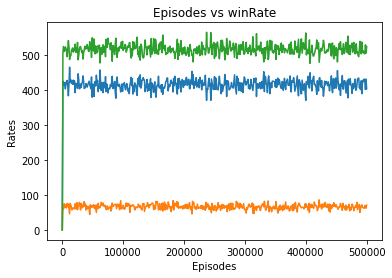

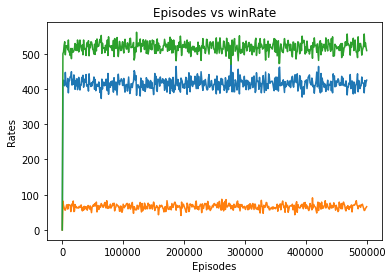

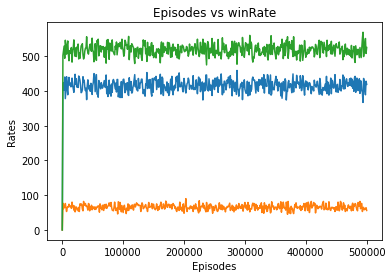

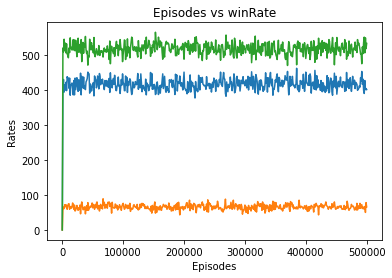

In [32]:
plotOutcomes(numOfEps, sarsamaxE1)
plotOutcomes(numOfEps, sarsamaxE2)
plotOutcomes(numOfEps, sarsamaxE3)
plotOutcomes(numOfEps, sarsamaxE4)

#### Explored states for sarsamax algorithms
Sarsamax with: $ ε = 0.1 $

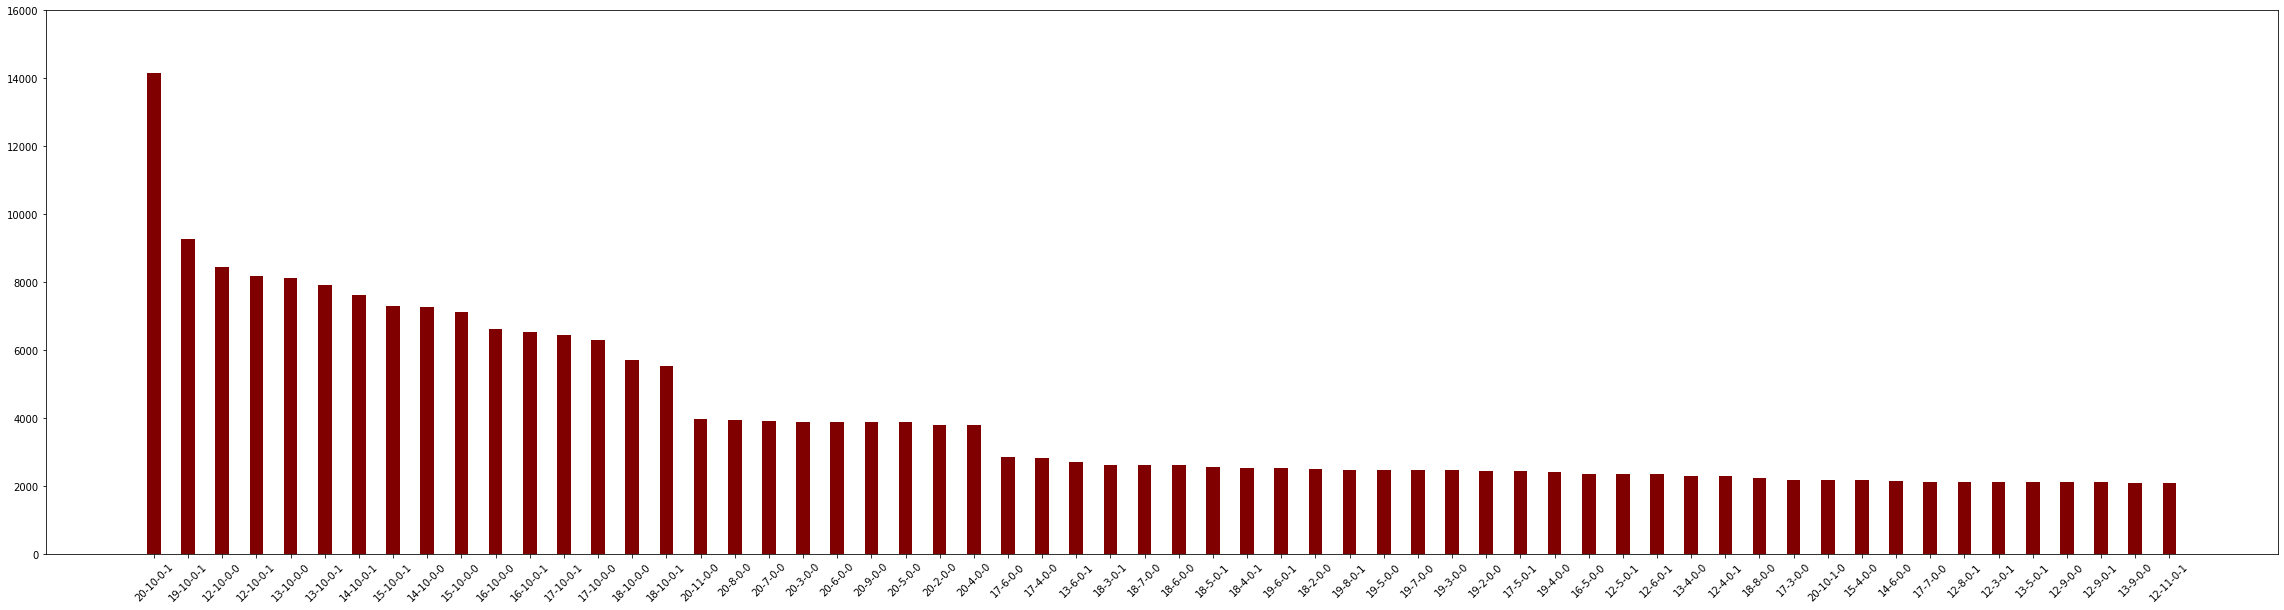

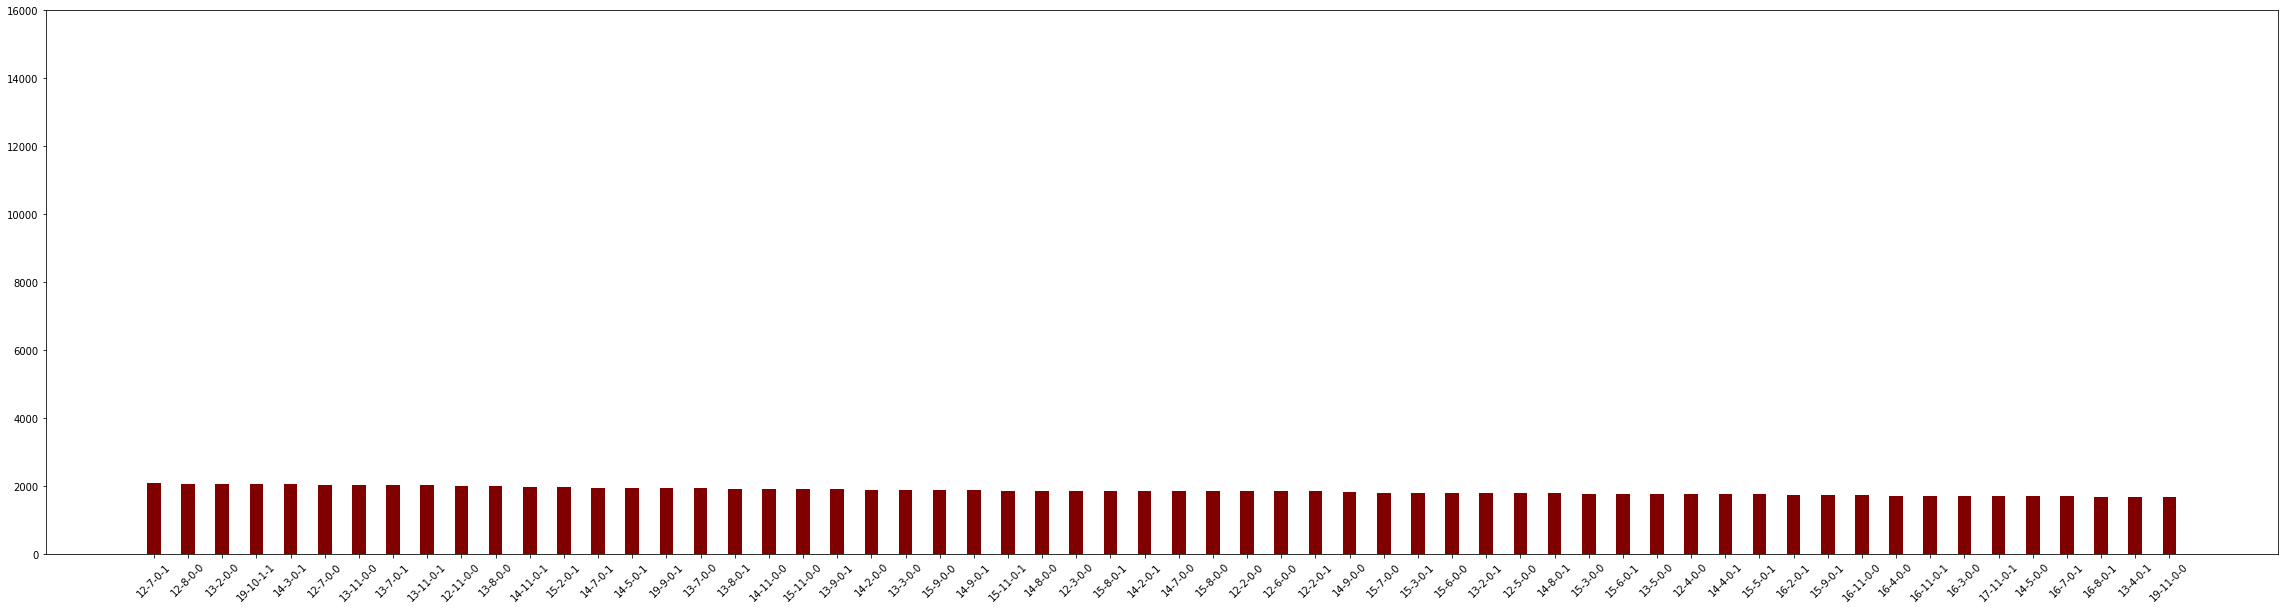

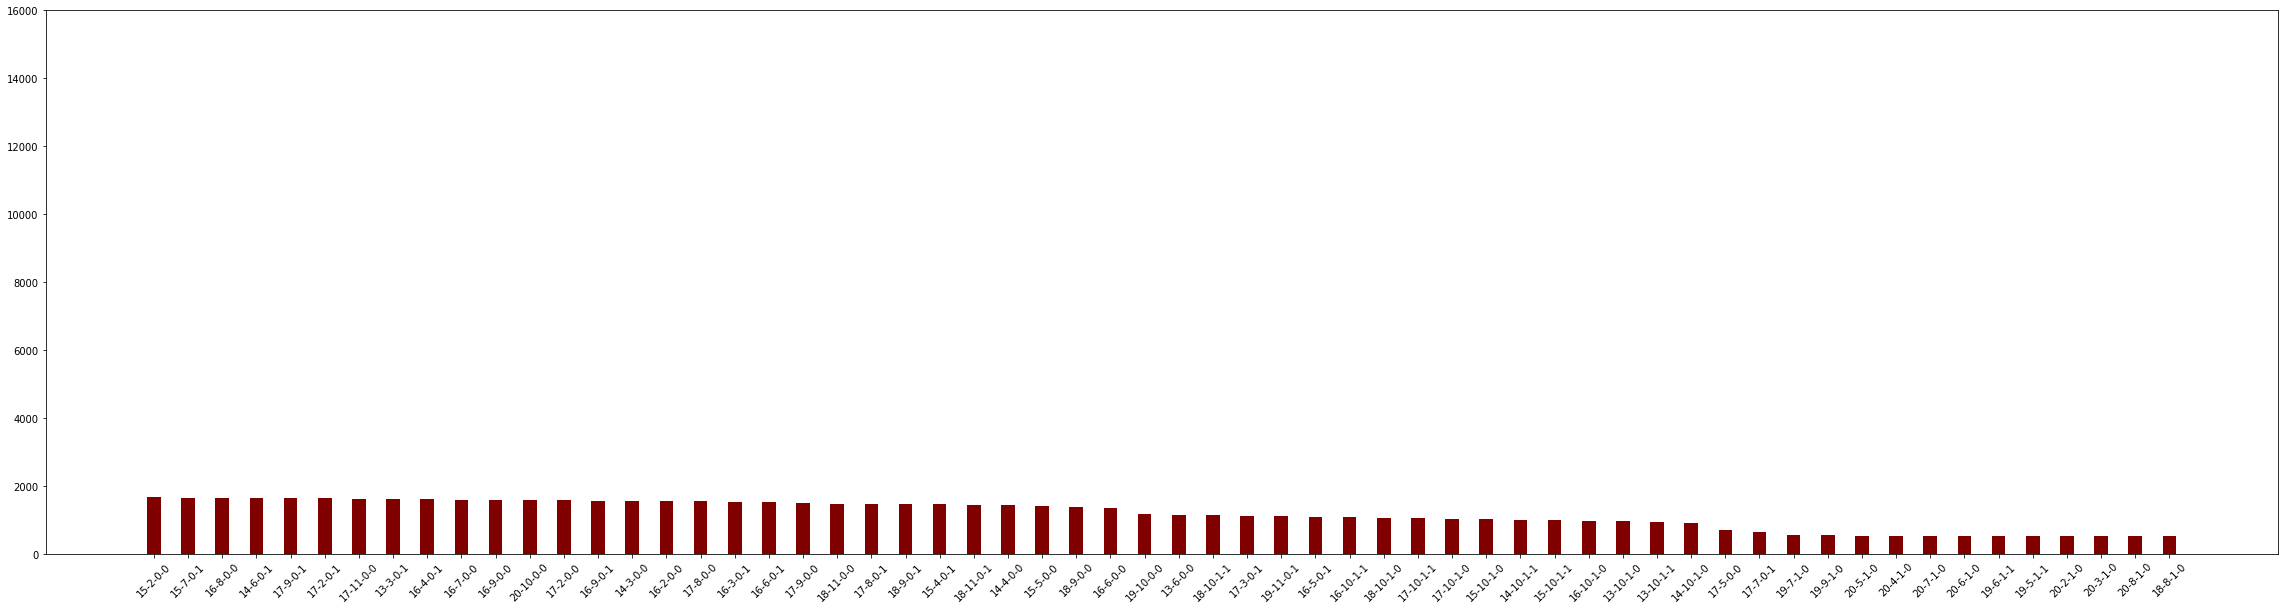

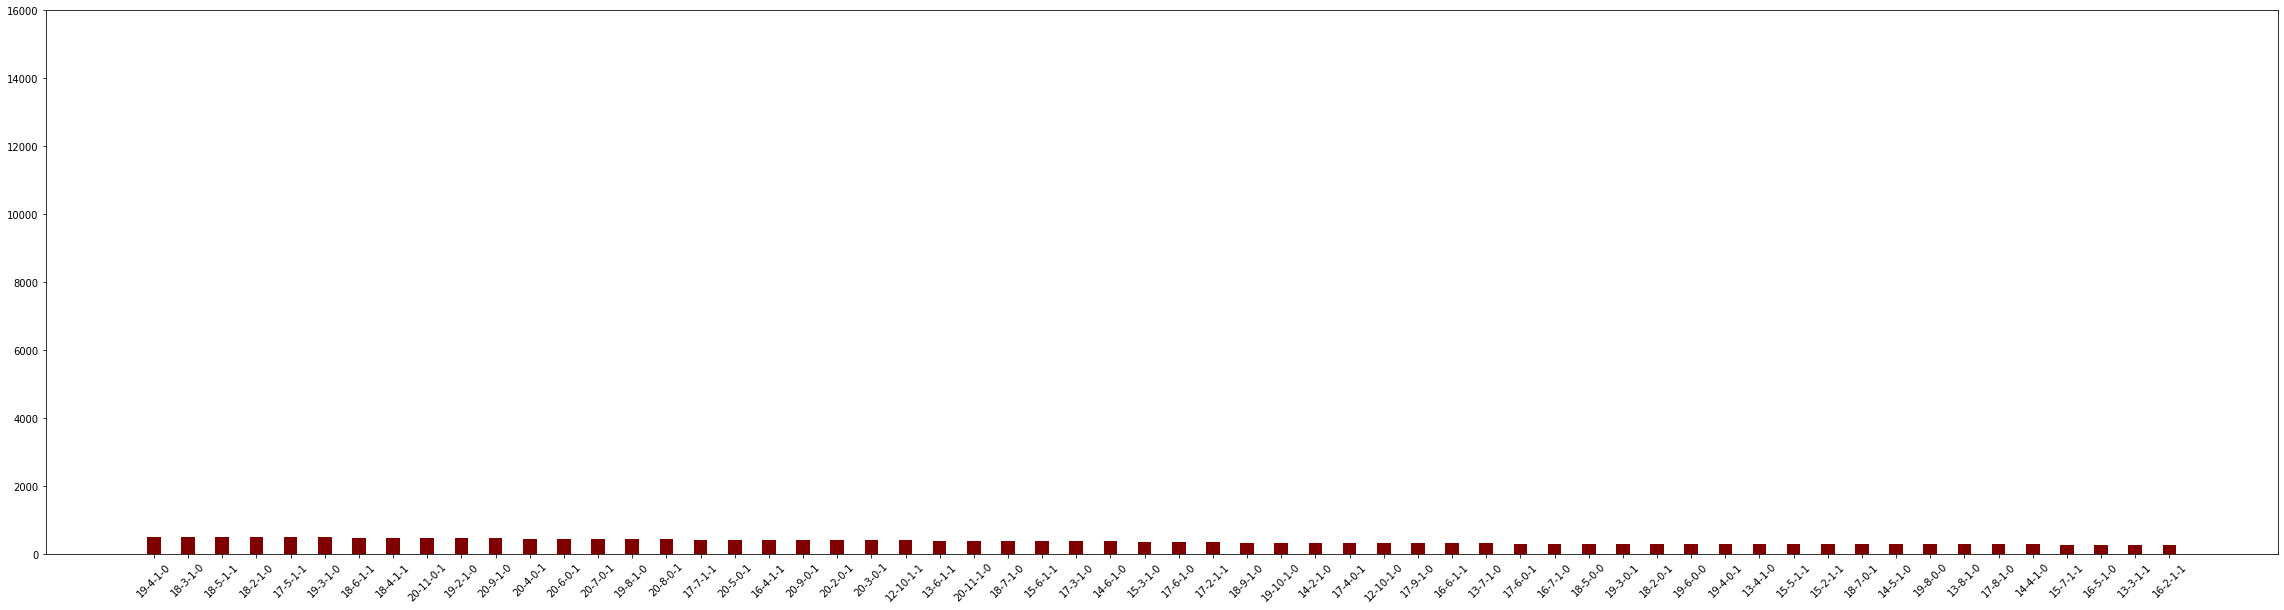

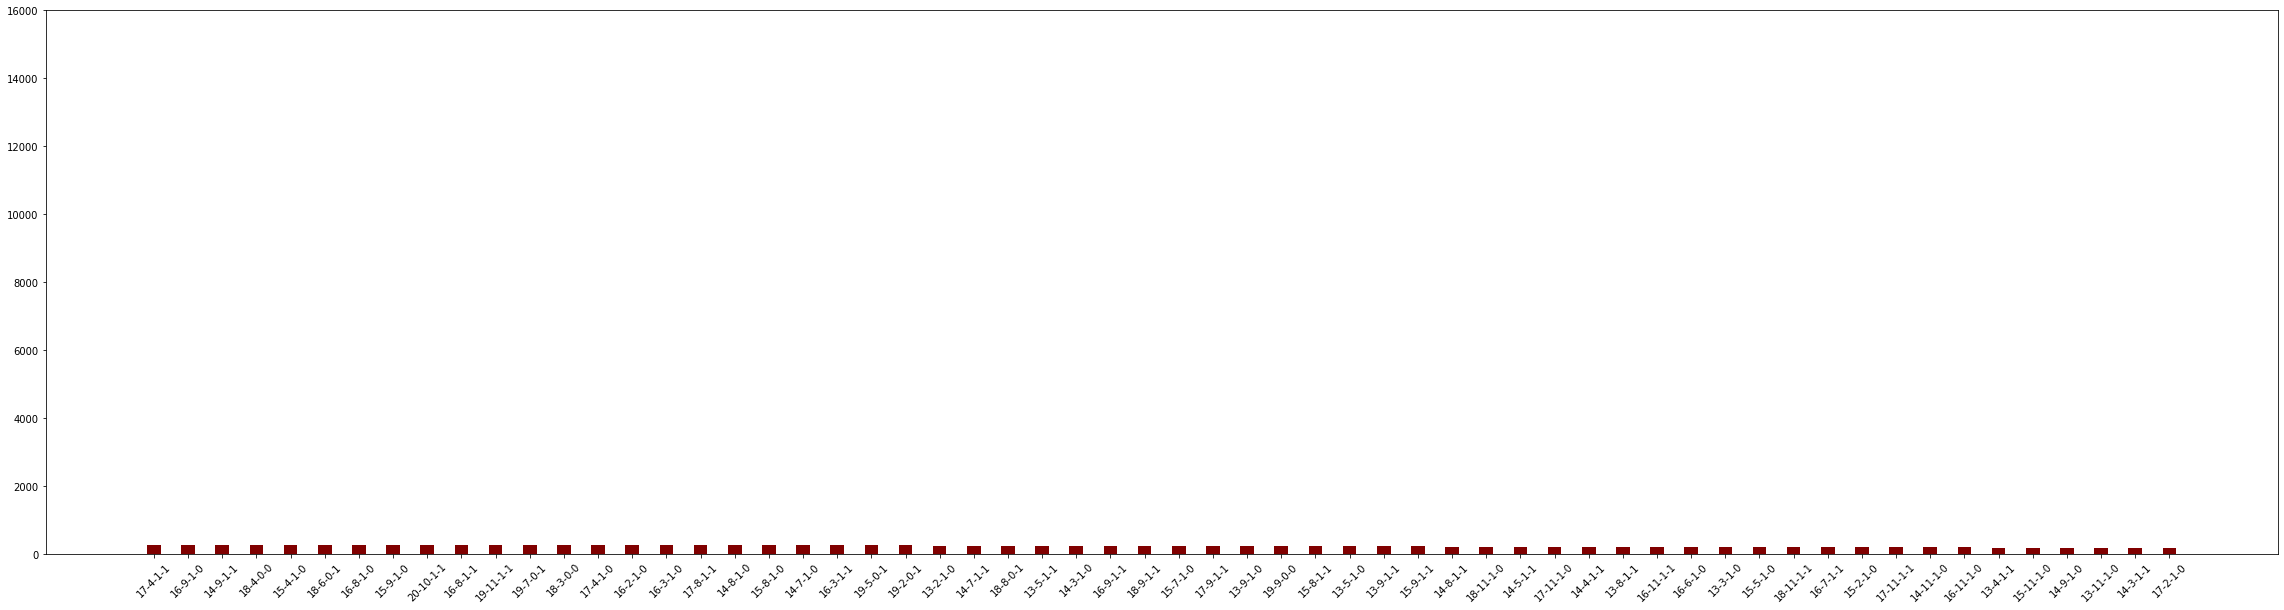

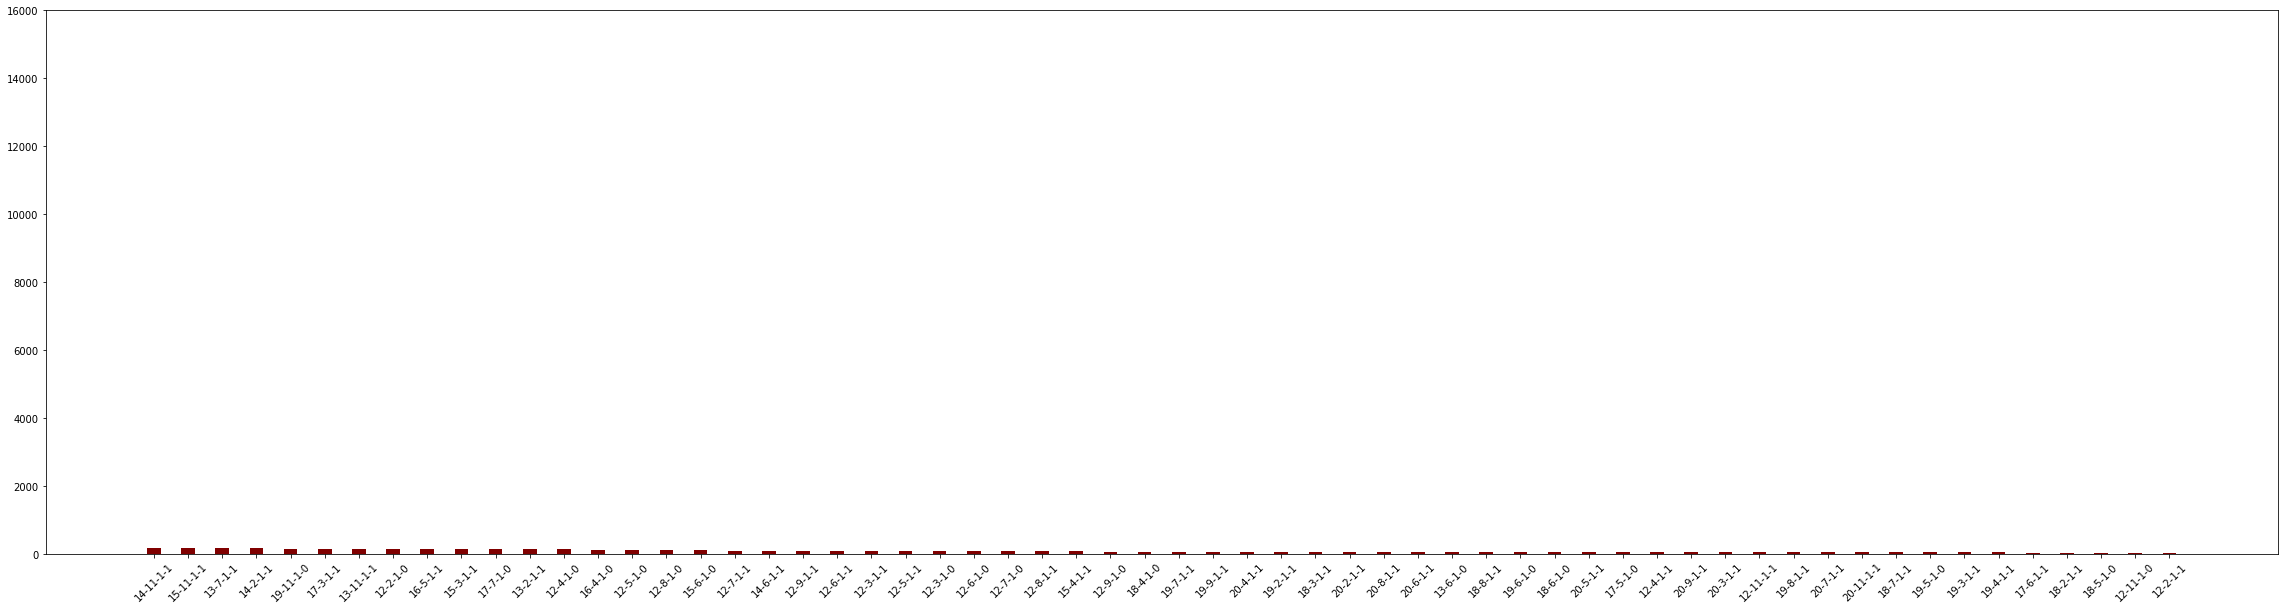

In [33]:
plotQACounts(sarsaE1)

Sarsamax with: $ ε = 1/k $

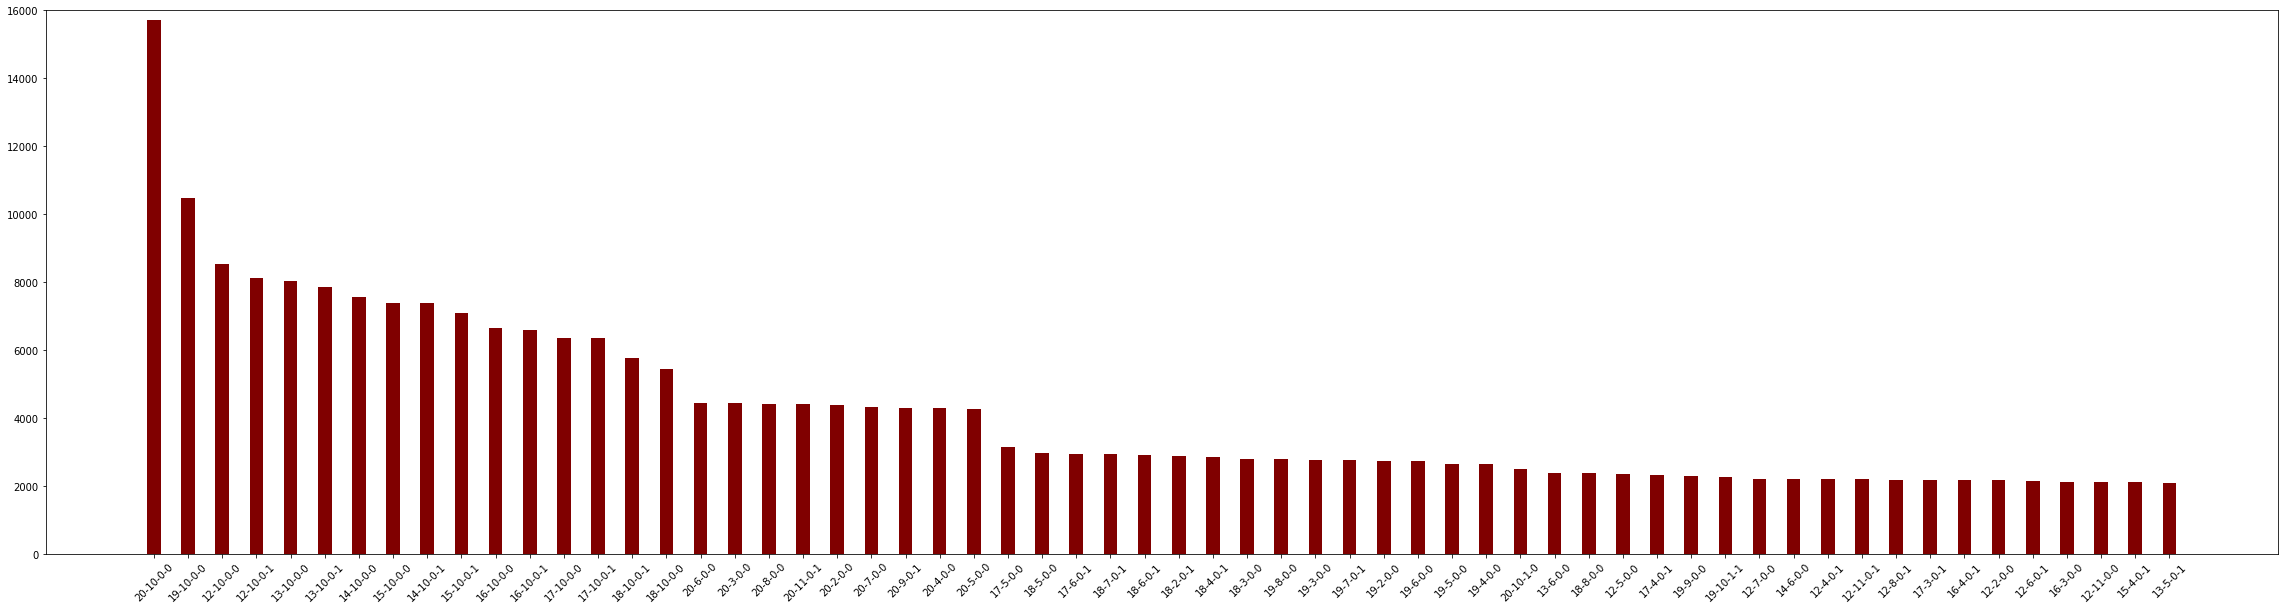

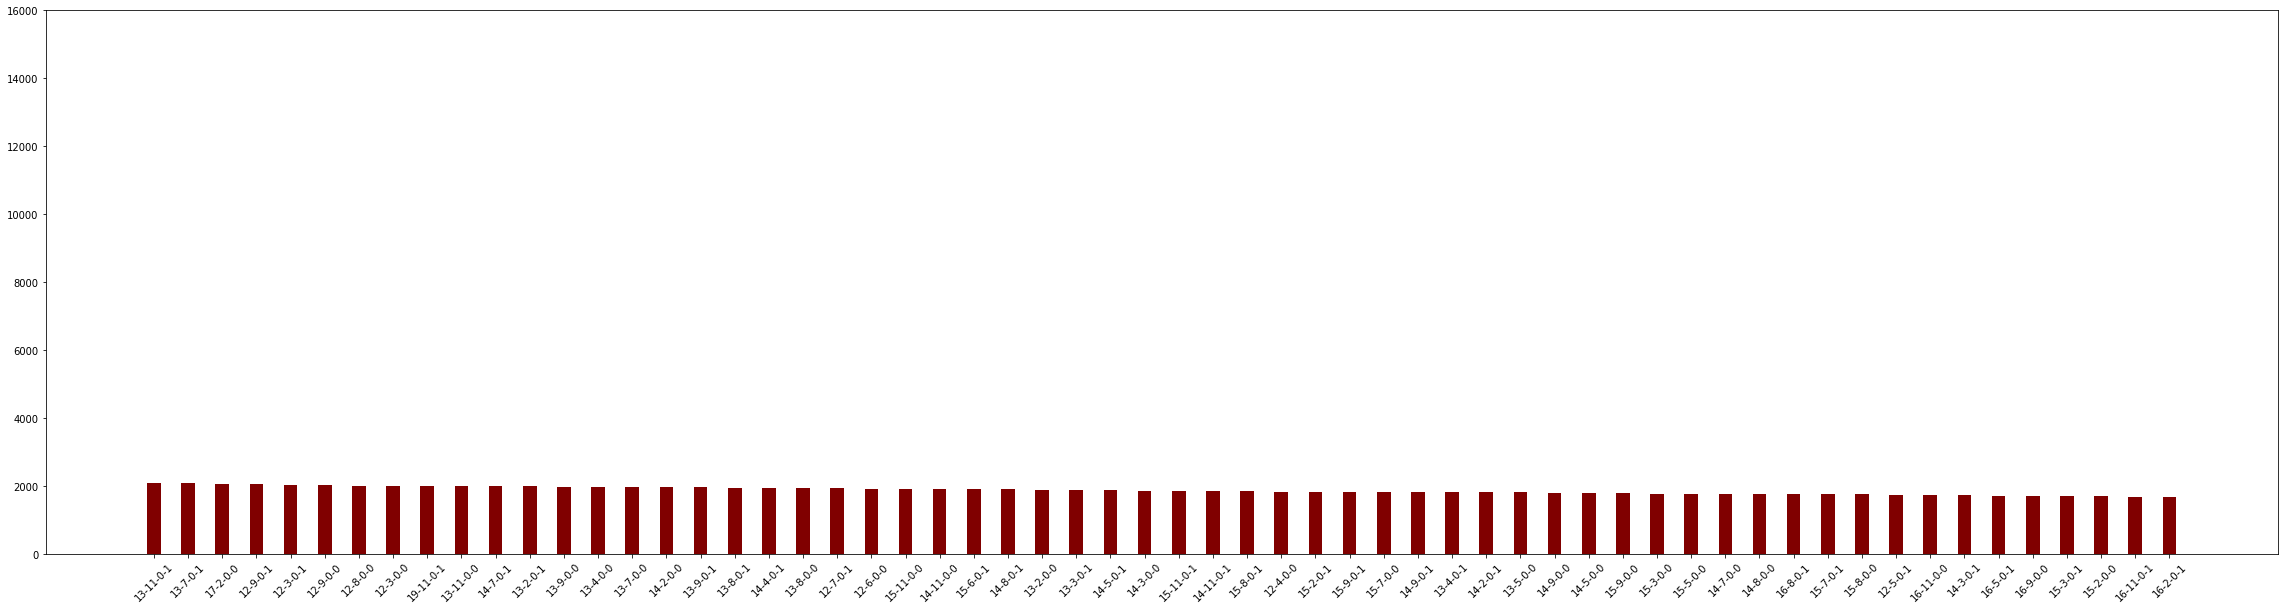

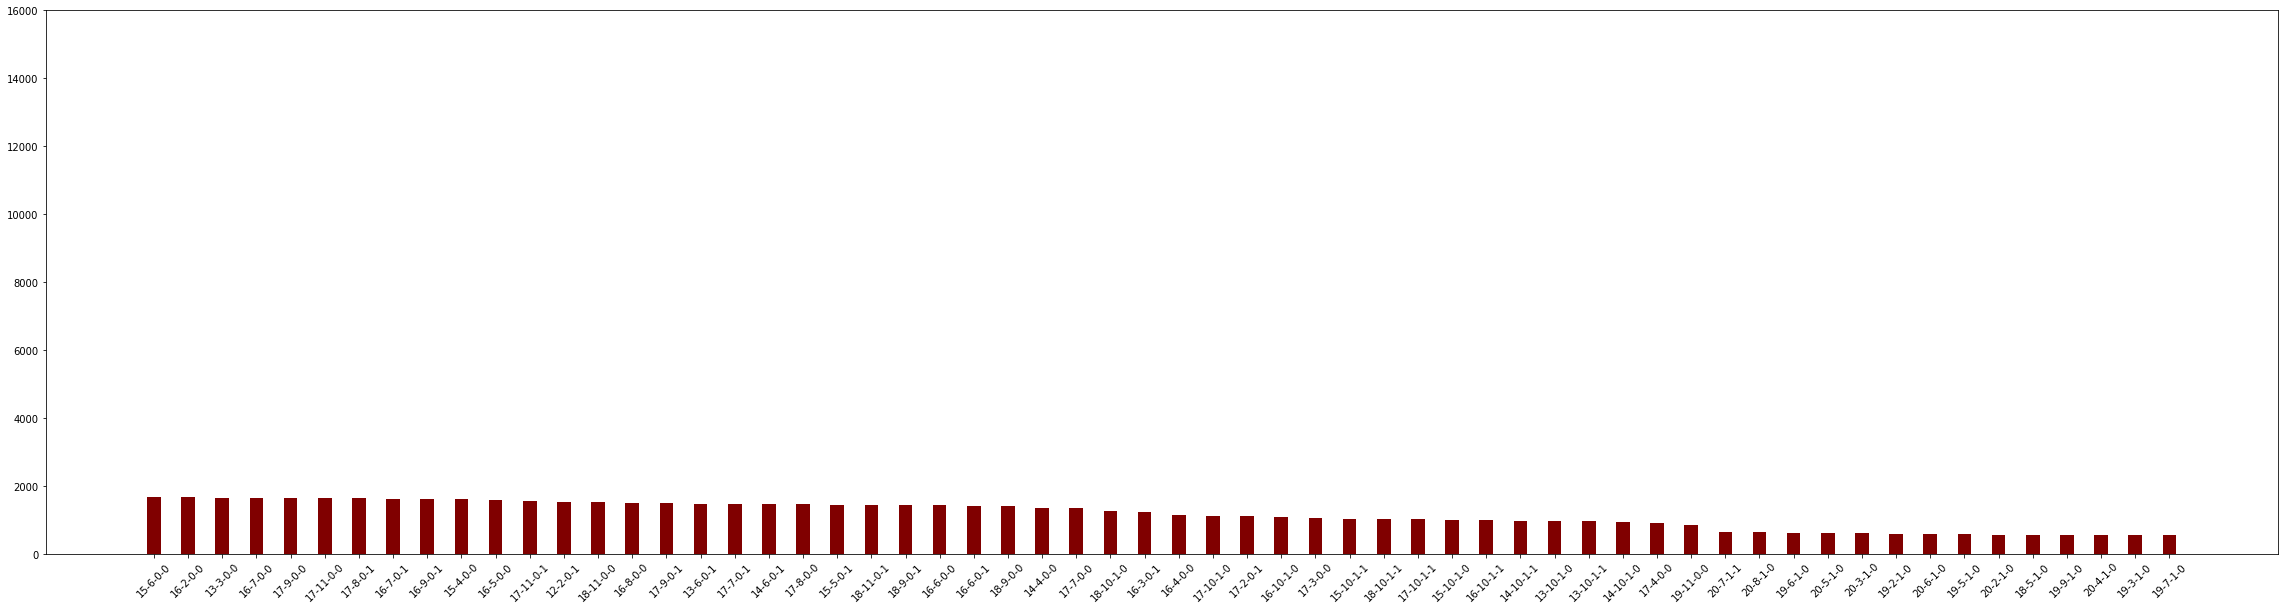

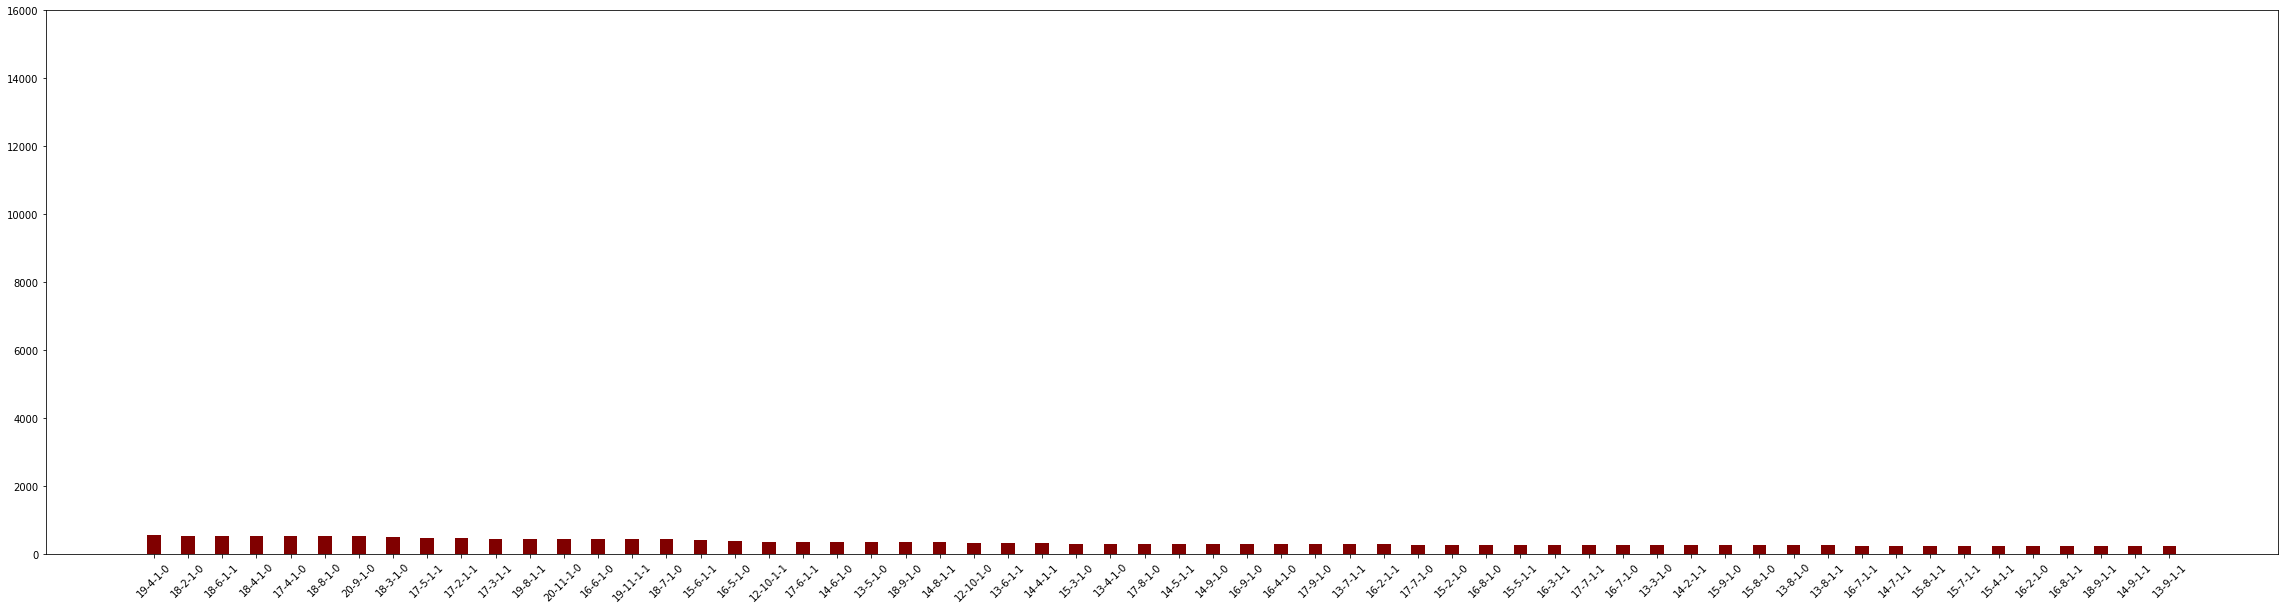

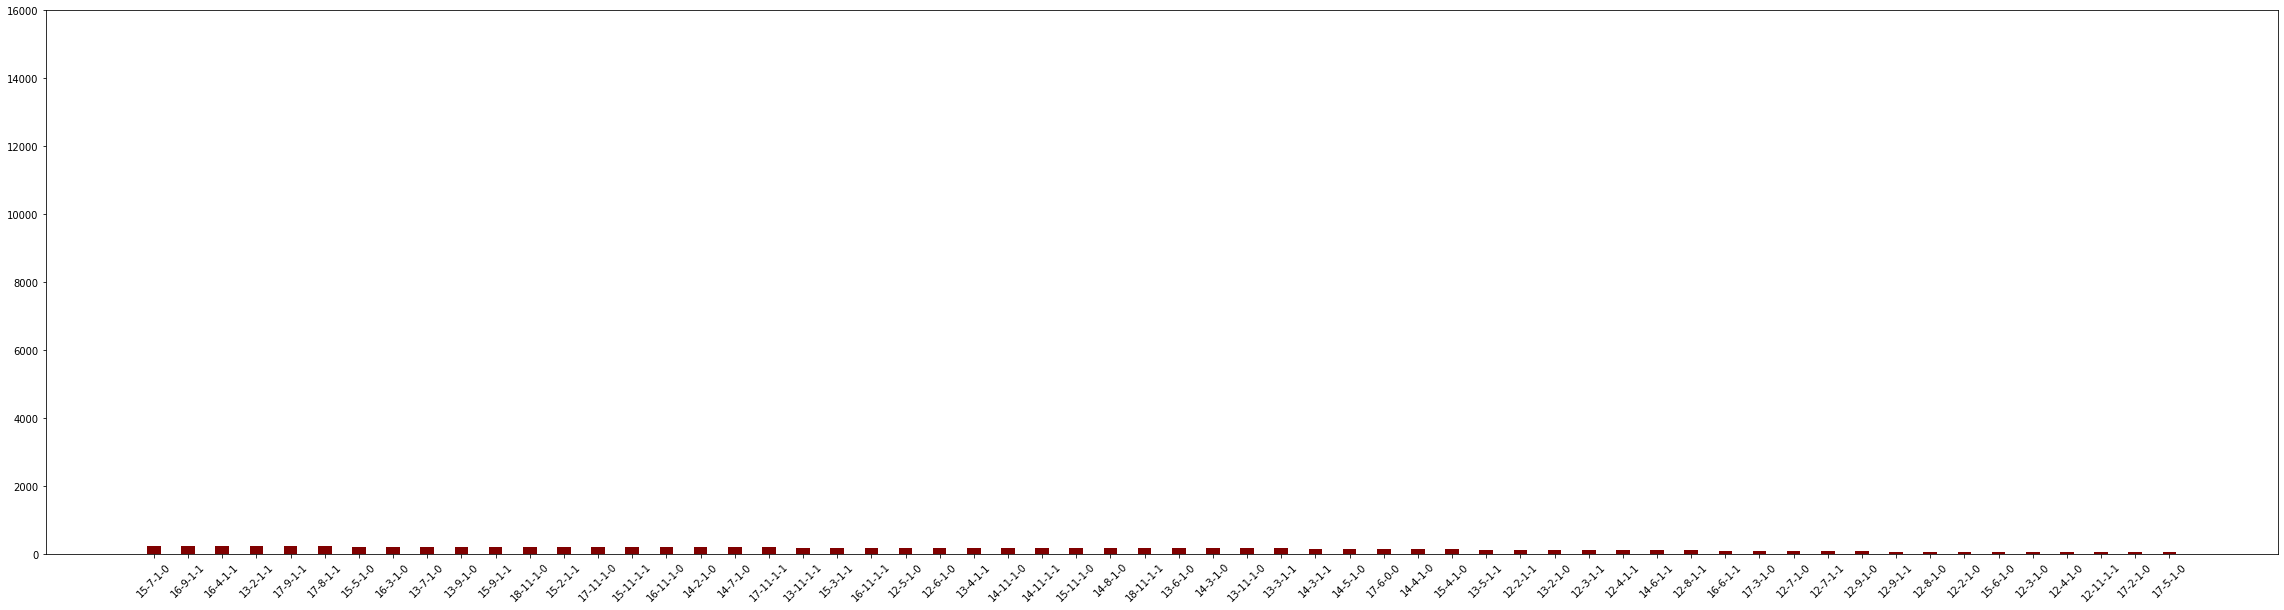

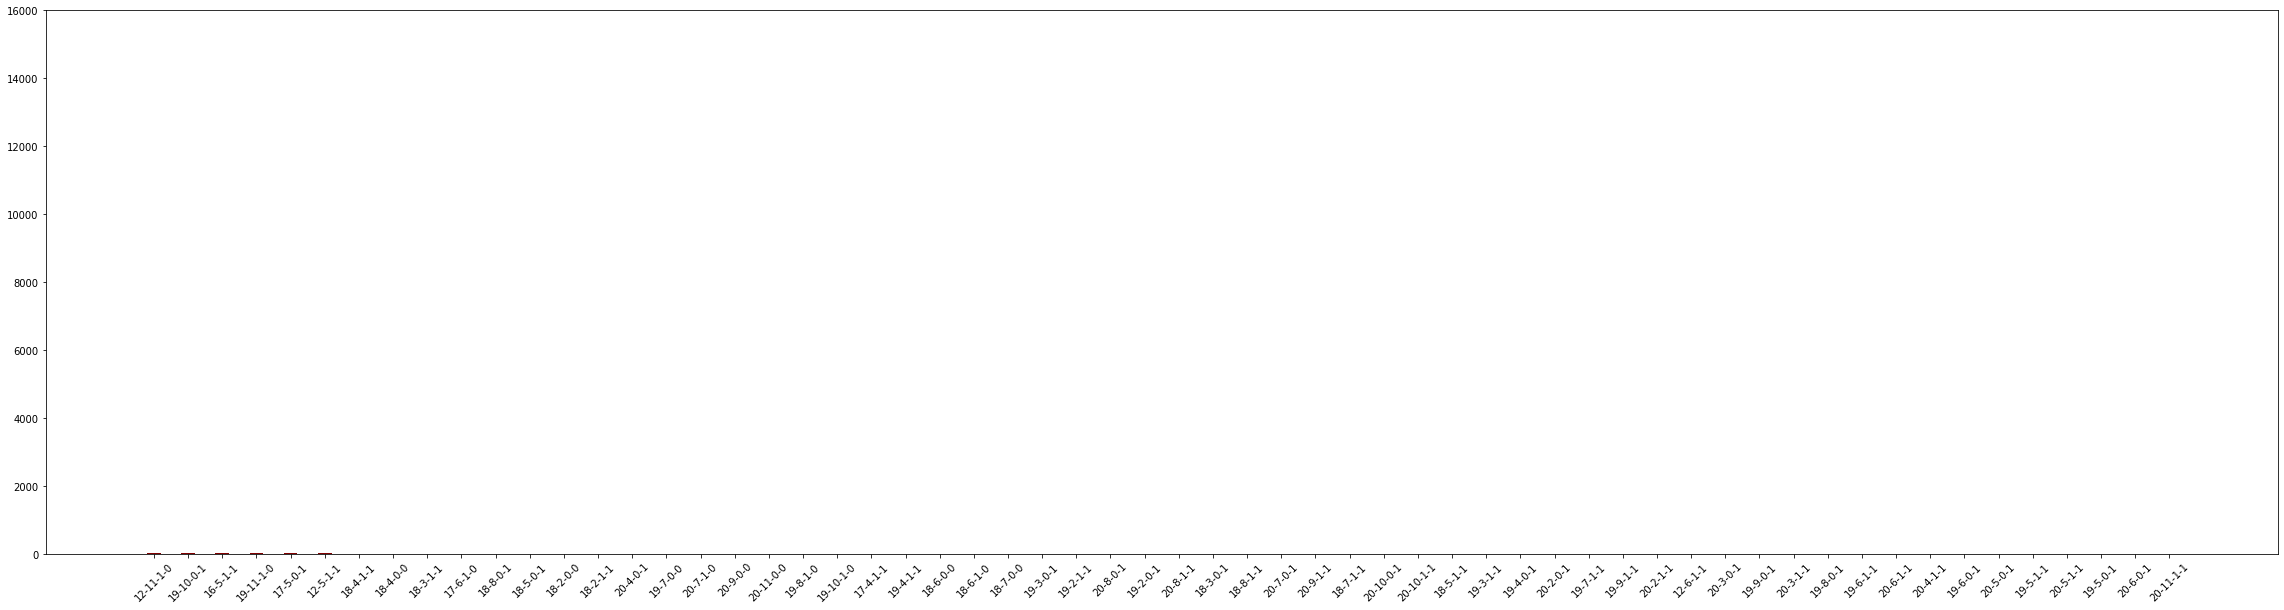

In [34]:
plotQACounts(sarsaE2)

Sarsamax with: $ ε = e^-k/1000 $

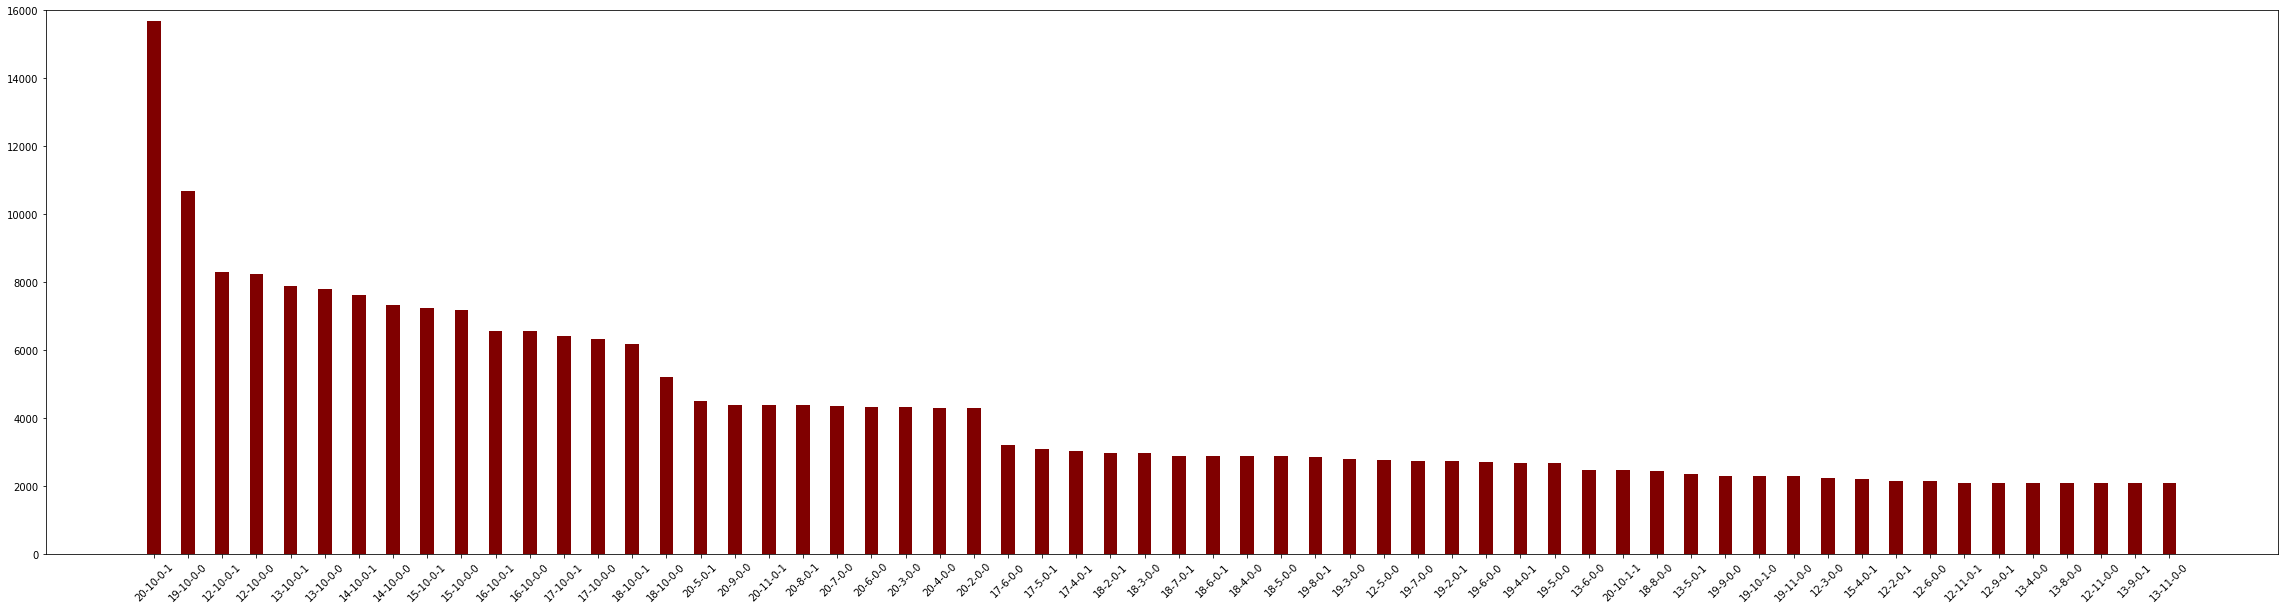

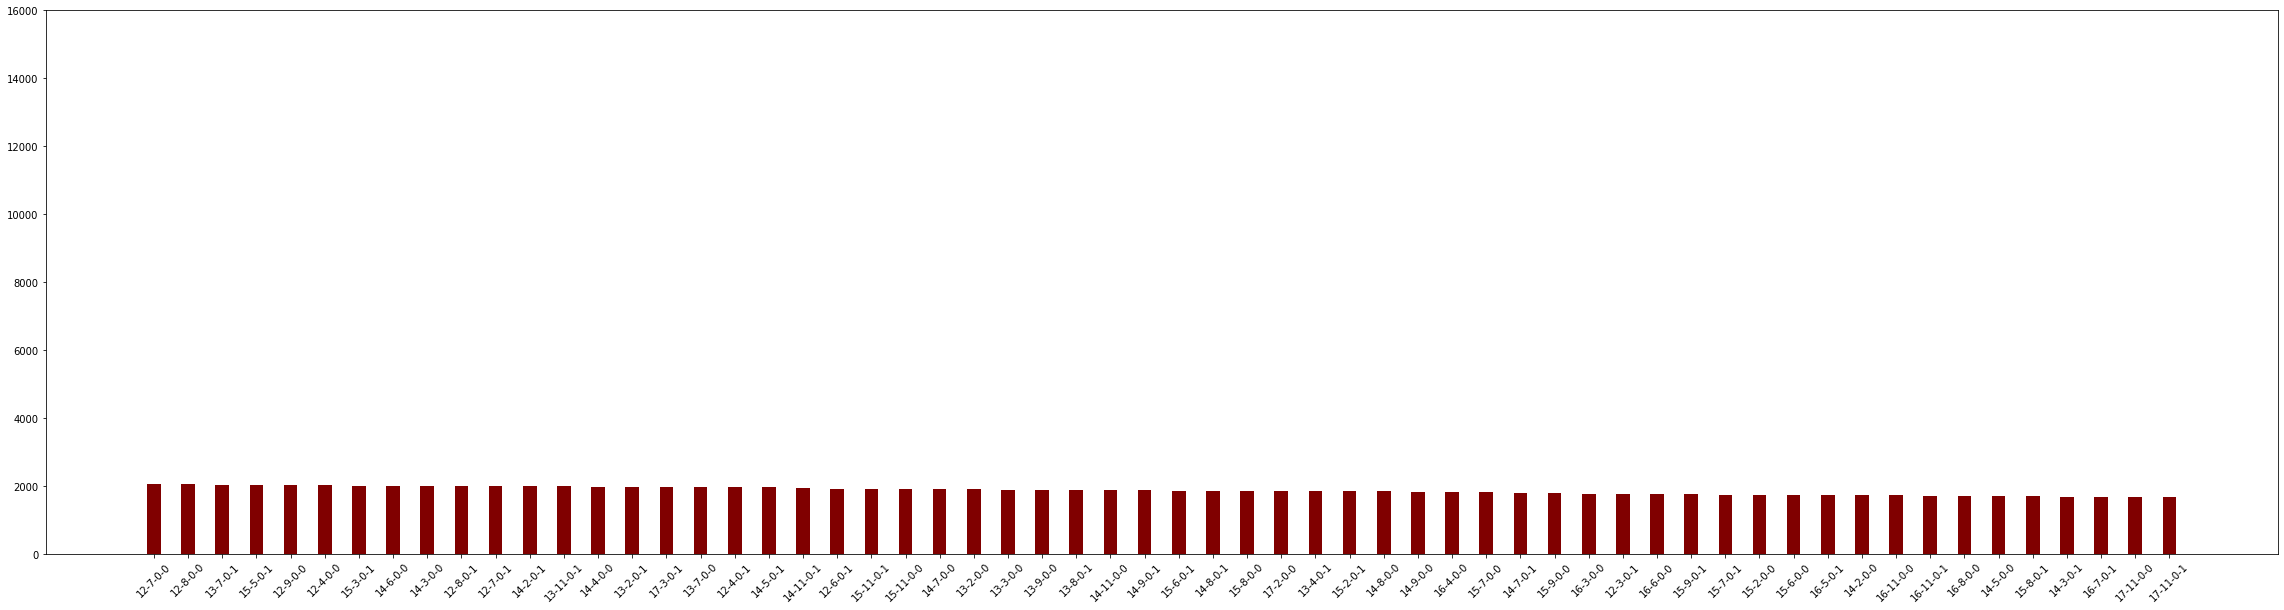

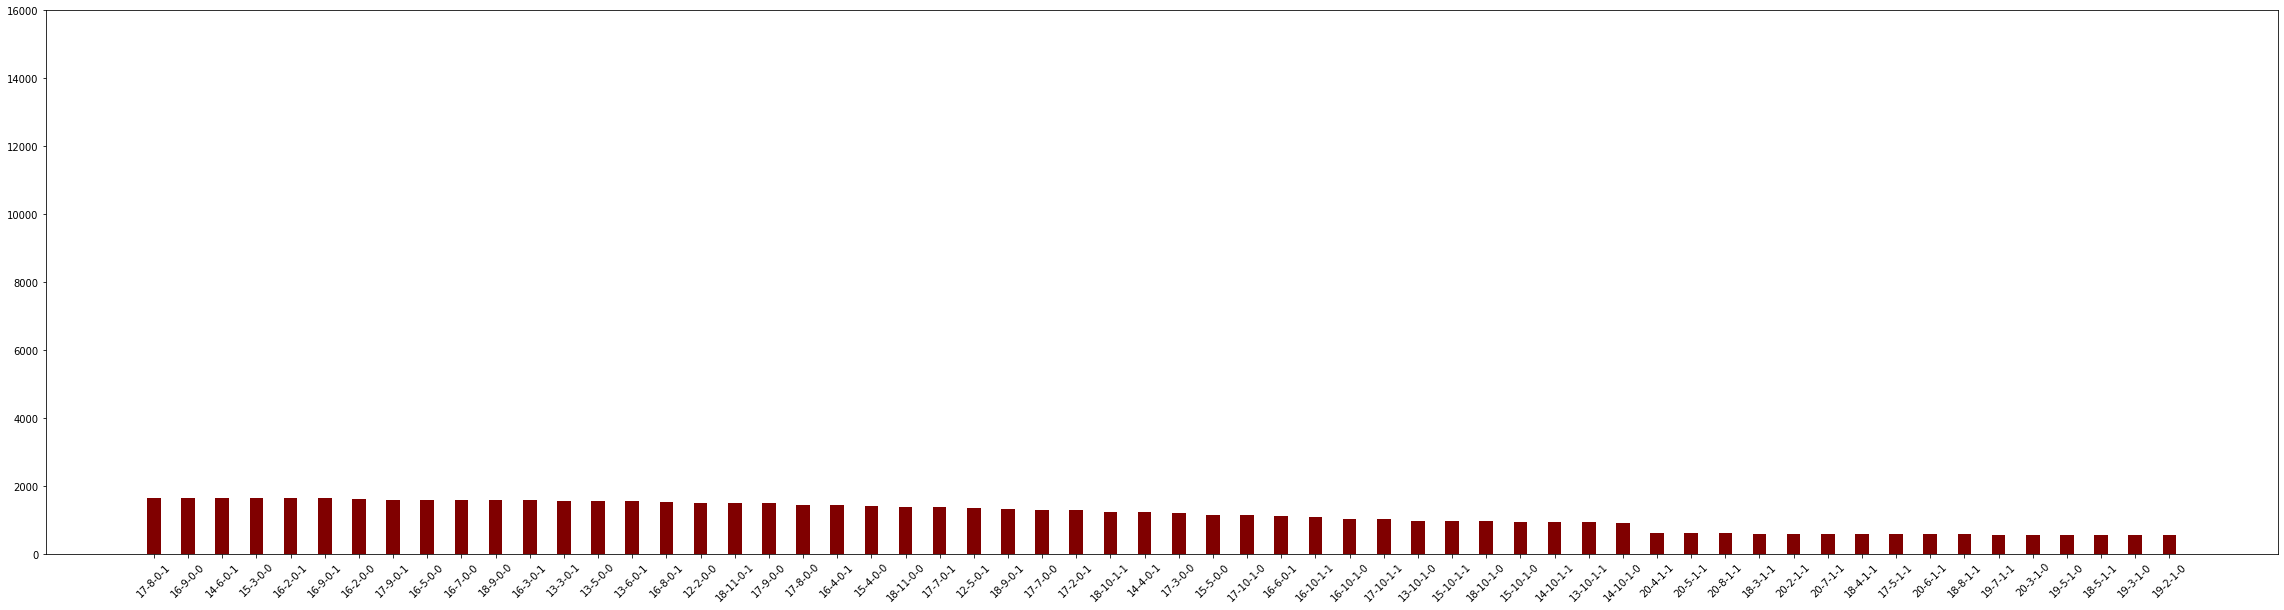

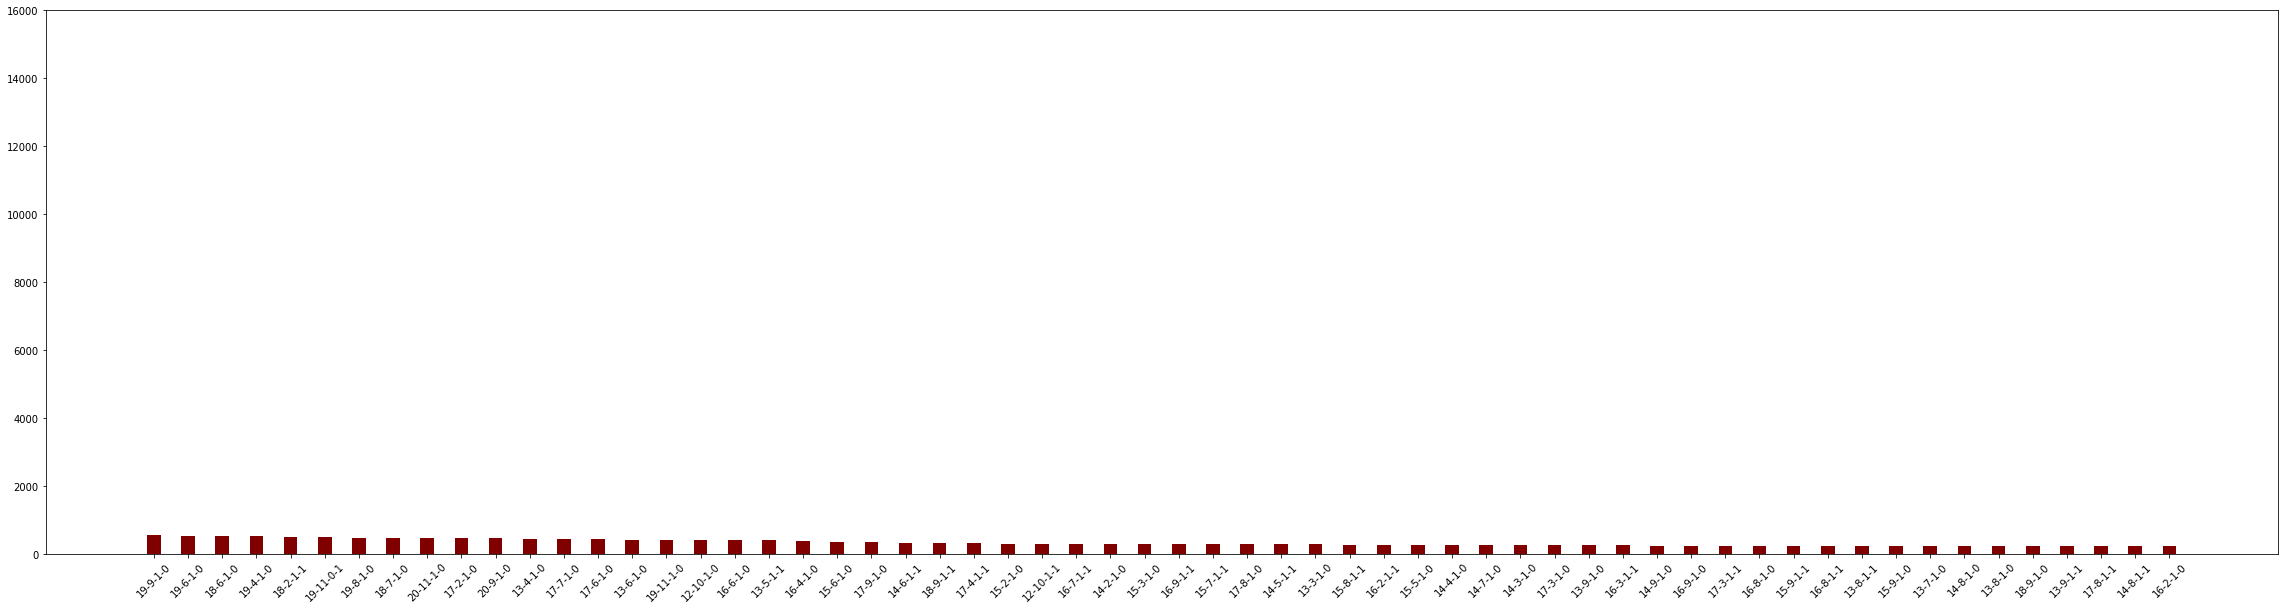

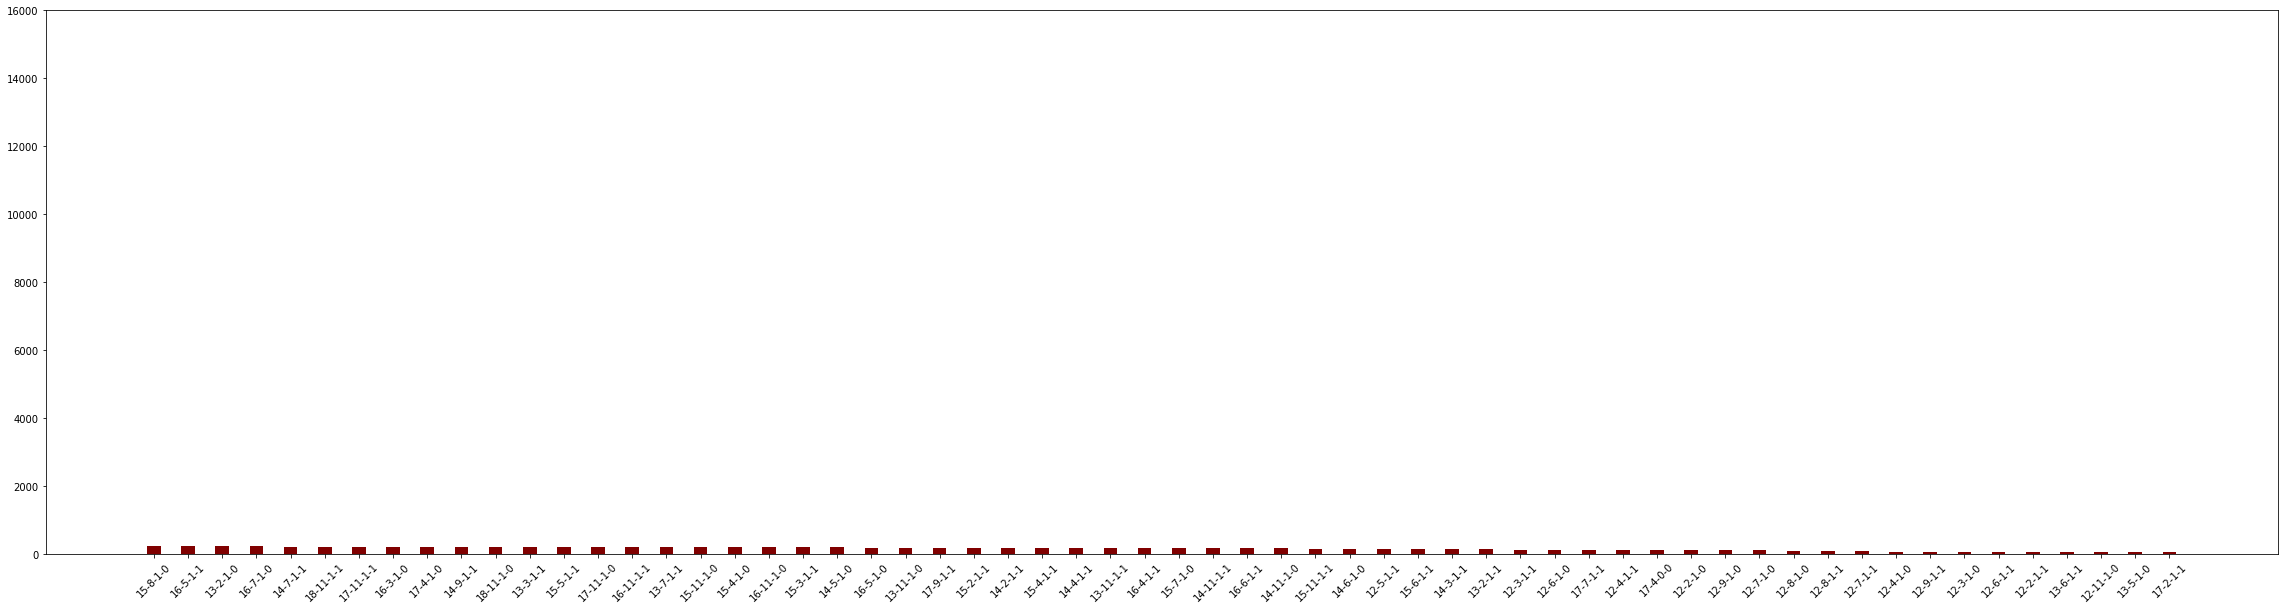

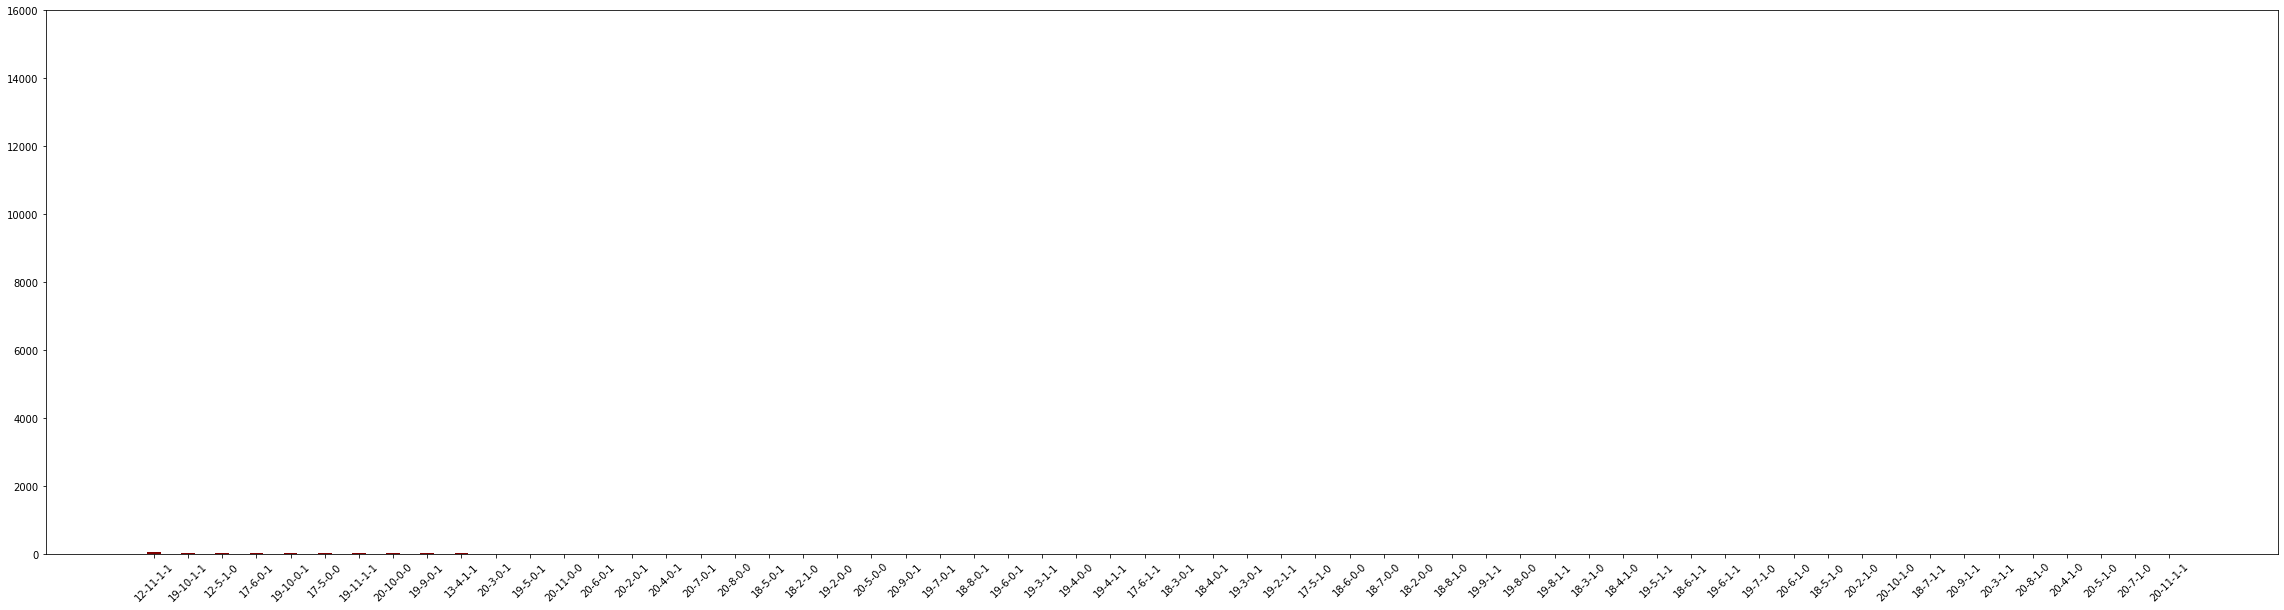

In [35]:
plotQACounts(sarsaE3)

Sarsamax with: $ ε = e^-k/10000 $

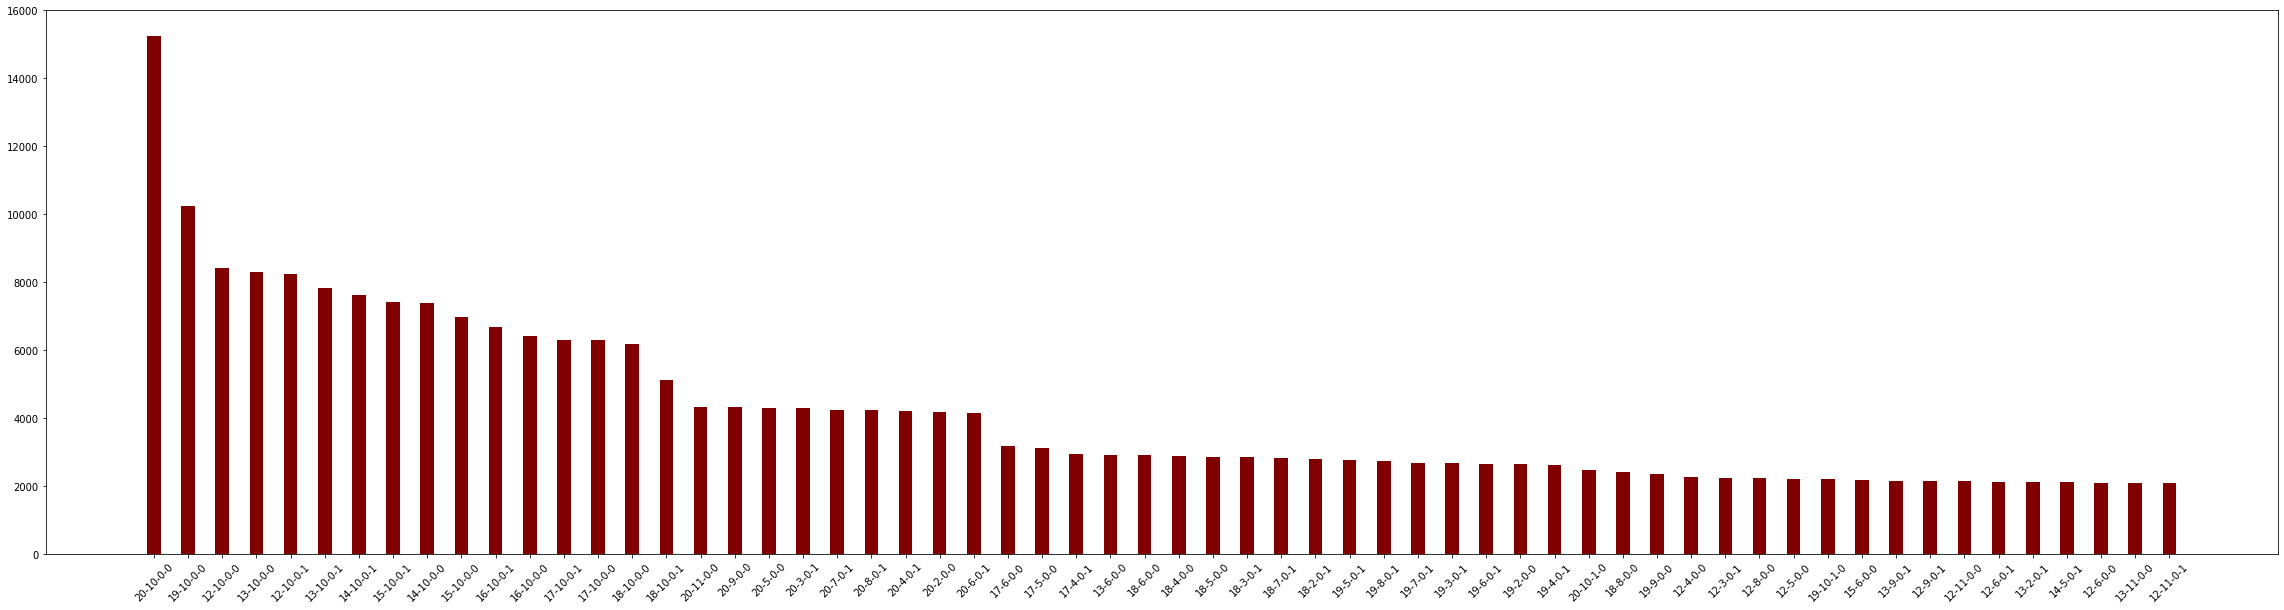

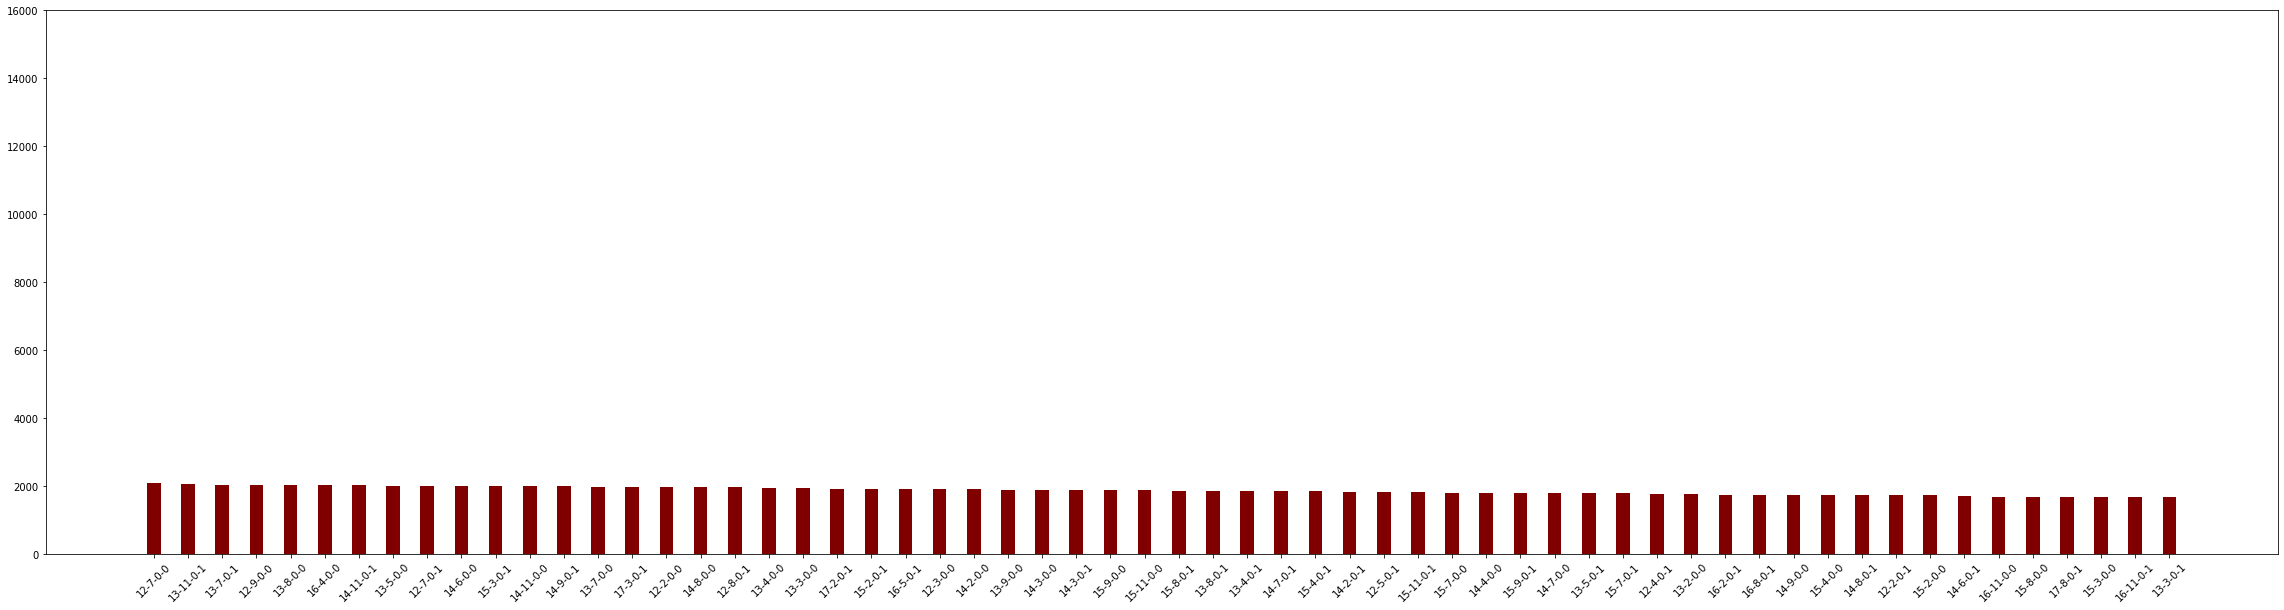

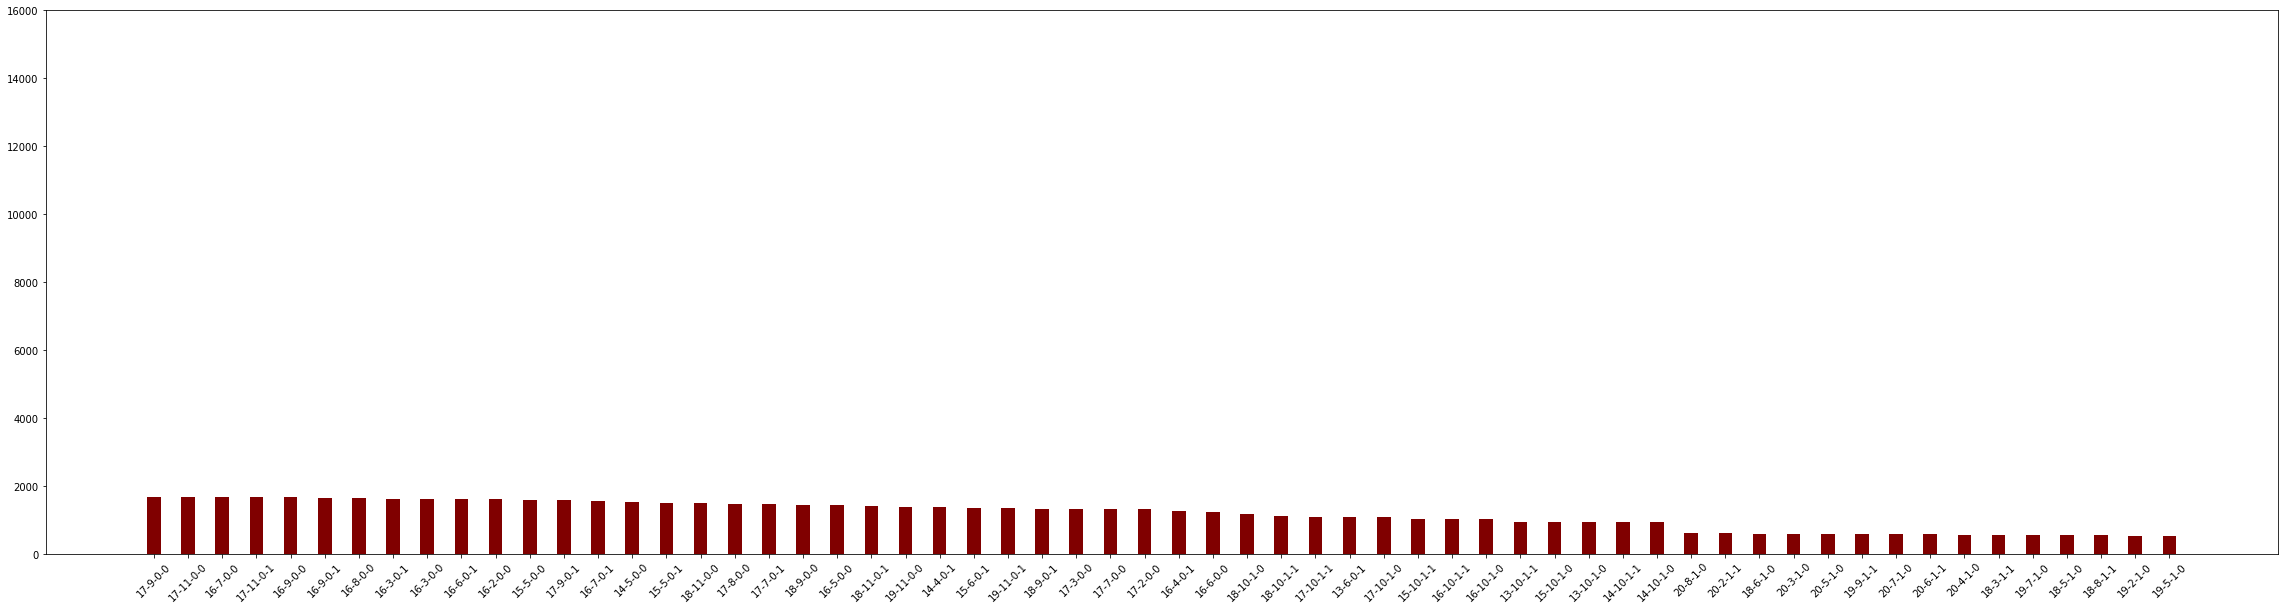

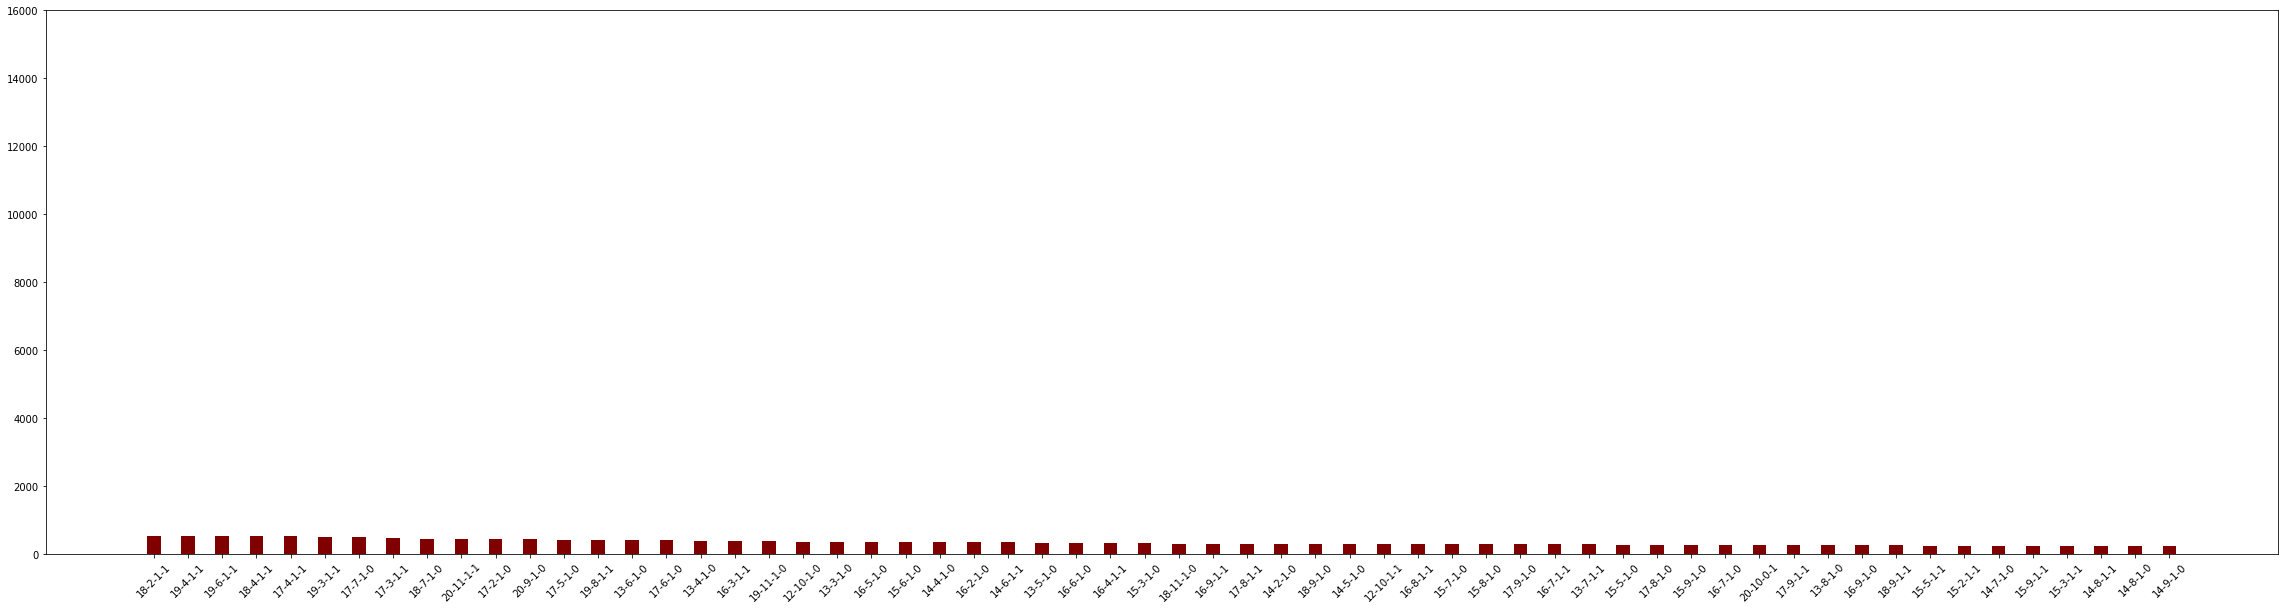

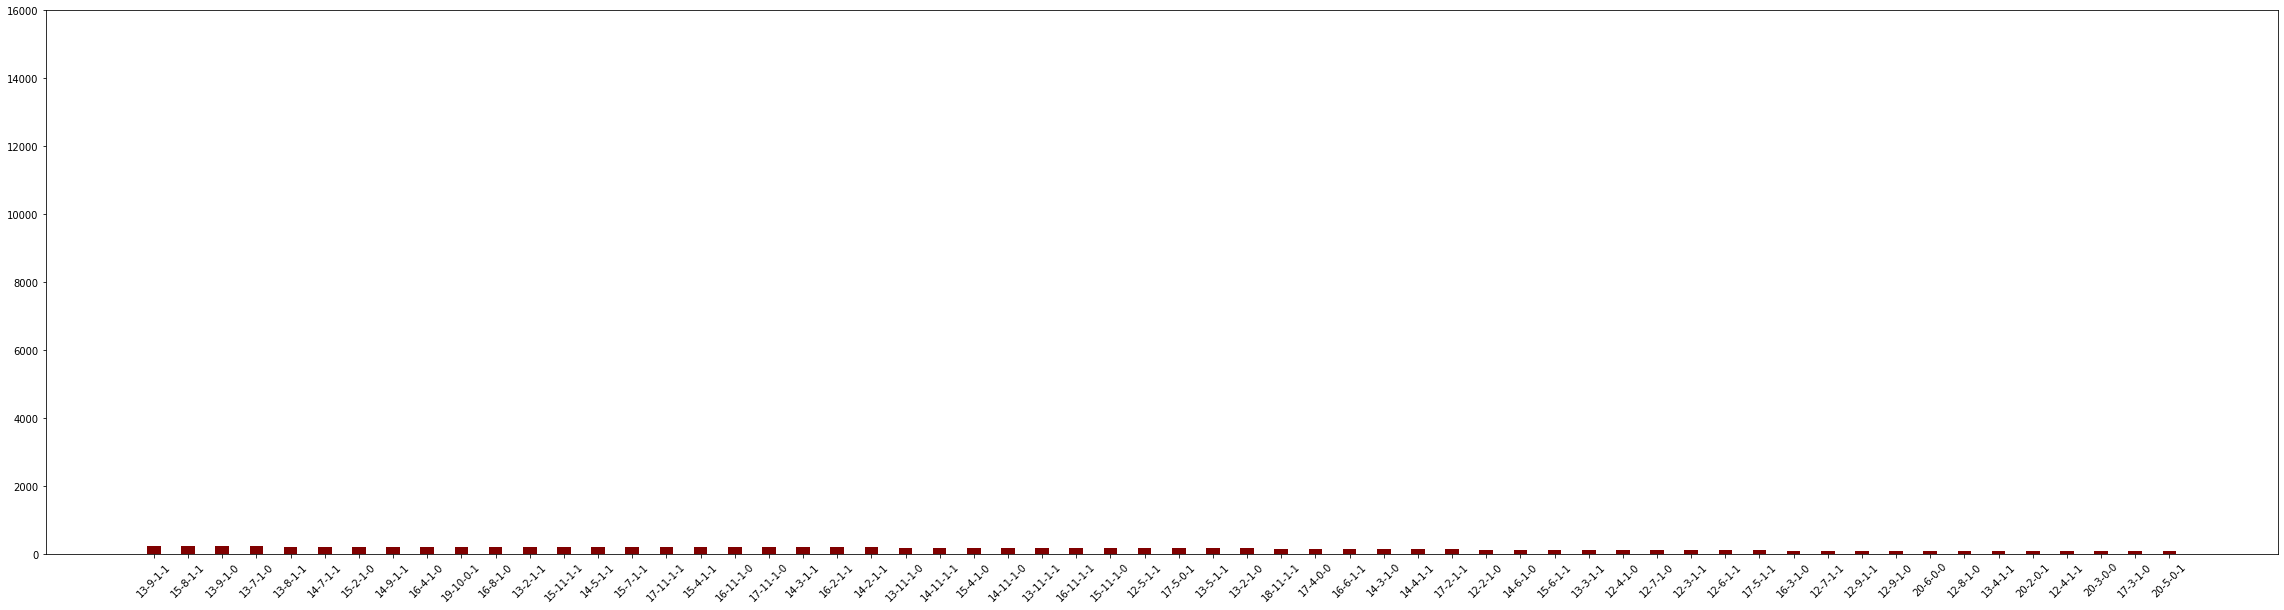

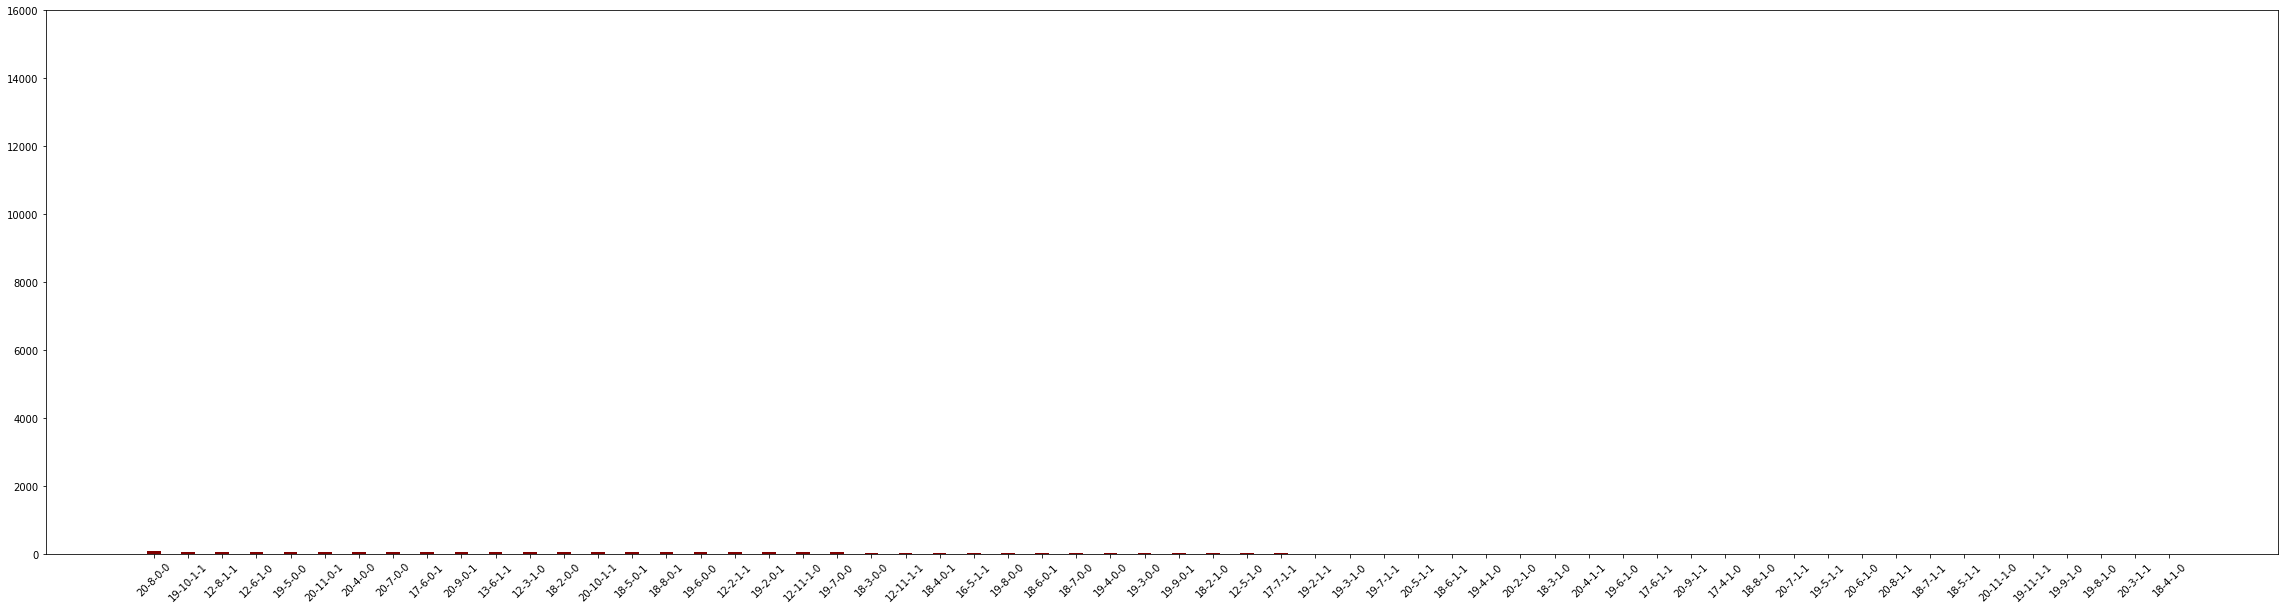

In [36]:
plotQACounts(sarsaE4)

#### Unique state-action pairs for sarsa

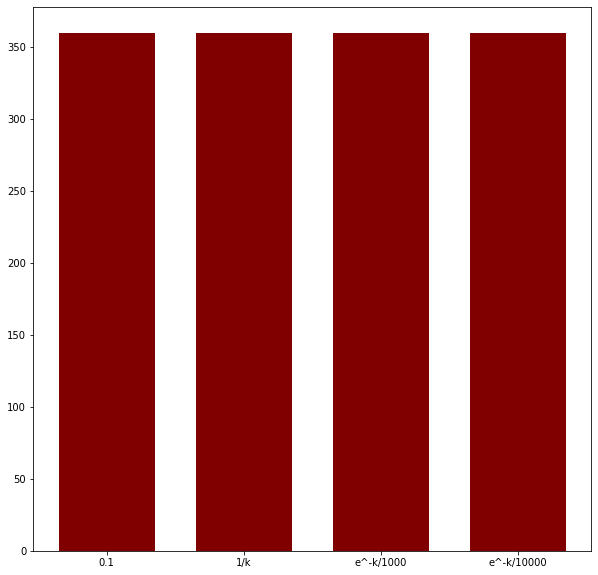

In [69]:
plotHist([sarsamaxE1, sarsamaxE2, sarsamaxE3, sarsamaxE4], ["0.1", "1/k", "e^-k/1000","e^-k/10000"])

#### Strategy tables for sarsa algorithm 
Sarsamax with: $ ε = 0.1 $

In [38]:
print("With No Aces: ")
printStratTable(sarsaE1, 0)
print("\nWith Aces: ")
printStratTable(sarsaE1, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    S    H    H    H    H    S    S    S     S
 13  H    H    S    H    S    S    H    S    H     H
 14  S    H    H    H    S    H    H    S    S     S
 15  H    S    H    H    S    S    H    H    H     H
 16  H    H    S    S    S    S    H    H    S     H
 17  H    H    S    H    S    S    S    S    S     S
 18  S    H    H    H    S    S    S    S    S     H
 19  S    S    S    S    H    S    H    H    H     S
 20  S    S    S    S    S    S    S    S    H     S

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    S    S    S    H    S    H    S    S     S
 13  H    H    H    H    S    H    H    H    S     H
 14  H    H    H    S    S    H    S    H    S     S
 15  H    S    H    S    H    S    S    S    S     S
 16  H    S    H    S    H    H    S    S    S     H
 17  S    

Sarsamax with: $ ε = 1/k $

In [39]:
print("With No Aces: ")
printStratTable(sarsaE2, 0)
print("\nWith Aces: ")
printStratTable(sarsaE2, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    H    H    H    S    H    H    S    S     S
 13  H    H    S    H    S    H    H    H    S     S
 14  H    H    H    S    H    S    H    H    H     H
 15  H    S    S    S    S    H    S    S    S     S
 16  H    H    S    H    S    H    S    S    H     H
 17  S    H    H    S    H    H    S    S    S     S
 18  H    S    H    S    H    H    S    S    S     H
 19  S    S    S    S    S    H    S    S    S     H
 20  S    S    S    S    S    S    S    H    S     H

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    H    H    S    S    S    H    H    S     H
 13  H    H    H    S    H    H    S    H    H     S
 14  H    S    H    H    S    S    S    S    H     S
 15  S    H    S    H    H    H    H    S    S     H
 16  H    S    H    S    S    S    H    S    H     S
 17  S    

Sarsamax with: $ ε = e^-k/1000 $

In [40]:
print("With No Aces: ")
printStratTable(sarsaE3, 0)
print("\nWith Aces: ")
printStratTable(sarsaE3, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    S    S    H    S    S    S    H    S     S
 13  S    H    H    H    S    S    S    S    H     H
 14  H    H    H    H    H    S    H    S    S     S
 15  H    S    S    S    S    H    H    H    S     S
 16  S    H    S    S    H    S    H    H    H     H
 17  S    H    H    H    S    H    S    H    H     S
 18  H    S    S    S    H    H    S    H    H     S
 19  H    S    H    S    S    S    H    S    S     S
 20  S    S    S    H    S    S    H    S    H     H

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    H    S    H    H    S    S    H    H     H
 13  H    H    S    H    S    H    H    S    H     S
 14  H    H    S    S    H    S    S    S    S     S
 15  S    S    H    S    H    H    S    S    H     S
 16  H    H    H    S    S    S    H    S    H     S
 17  S    

Sarsamax with: $ ε = e^-k/10000 $

In [41]:
print("With No Aces: ")
printStratTable(sarsaE4, 0)
print("\nWith Aces: ")
printStratTable(sarsaE4, 1)

With No Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  H    S    H    H    H    H    S    H    H     S
 13  H    H    S    S    S    H    S    S    H     S
 14  H    S    S    S    S    S    H    S    S     H
 15  H    H    H    H    H    H    H    S    H     H
 16  S    S    H    S    H    H    S    H    S     H
 17  S    H    H    S    S    S    S    S    H     H
 18  H    H    S    S    S    H    S    H    S     H
 19  S    H    H    H    H    H    H    S    S     H
 20  S    H    H    S    H    H    H    S    S     S

With Aces: 
     2    3    4    5    6    7    8    9    10    11
---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----
 12  S    H    H    H    S    H    S    H    S     S
 13  H    S    H    S    S    S    S    H    S     H
 14  H    H    S    S    H    S    H    H    S     S
 15  H    H    H    S    H    S    H    H    S     H
 16  S    H    H    S    H    S    H    S    S     S
 17  S    

### Evaluation of all the algorithms

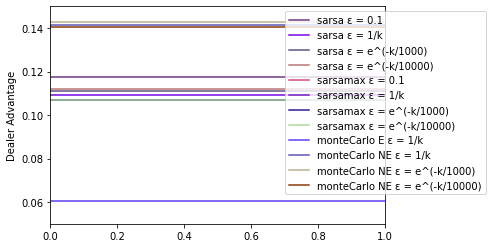

In [74]:
algs = [[sarsaE1, "sarsa ε = 0.1"], [sarsaE2, "sarsa ε = 1/k"], [sarsaE3, "sarsa ε = e^(-k/1000)"], [sarsaE4, "sarsa ε = e^(-k/10000)"], 
[sarsamaxE1, "sarsamax ε = 0.1"], [sarsamaxE1, "sarsamax ε = 1/k"], [sarsamaxE1, "sarsamax ε = e^(-k/1000)"], [sarsamaxE1, "sarsamax ε = e^(-k/10000)"],
[mc, "monteCarlo E ε = 1/k"], [mc2, "monteCarlo NE ε = 1/k"], [mc3, "monteCarlo NE ε = e^(-k/1000)"],[mc4, "monteCarlo NE ε = e^(-k/10000)"]]
for alg in algs:
    dealerAdv = getDealerAdvantage(alg[0])
    col = (np.random.random(), np.random.random(), np.random.random())
    plt.axhline(y = dealerAdv, color = col, linestyle = 'solid', label = alg[1])

plt.ylabel('Dealer Advantage')
plt.ylim(0.05,0.15)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')